## 회귀 분석 프로젝트 - 아파트 경매가 예측

- 성수동에서 집을 살 수 있는 방법은 무엇이 있을까?
    - 1. 부동산 중개 업소 방문
    - 2. 청약 통장을 사용한 분양 받기
    - 3. 부동산 경매 참여
    
    

- 부동산 규제로 대출이 제한되면서 내집 마련의 기회는 적어지고 있다. 최소한의 종잣돈으로 내집 마련을 할 수 있는 부동산 경매 시장에 눈을 돌려보고자 한다. 참여하기 전, 경매가에 영향을 미치는 요소를 찾아보고 예측 하고자 한다.


- 부동산 경매 전문 업체 인포케오옥션 데이터를 활용하여 경매가 예측에 필요한 변수와 회귀분석을 진행하고자 한다.

### 데이터 정보
- 서울, 부산 지역 약 2700개 최근 2년간 아파트 경매물의 등기부, 임차, 감정가, 유찰횟수, 낙찰가 제공. 아파트 낙찰가 예측
- Datas
    - master_train/test : 서울/부산 지역의 낙찰가를 포함하여 경매 물건 아파트의 위치, 감정가, 경매 개시/종결일 등의 기본 정보(최근 2년). test에 낙찰가 없음
    - regist : 아파트에 대한 등기 정보
        - 개별 경매 : 1개의 사건번호에 여러 물건으로 경매 진행될 경우
        - 과다등기: 등기명의인 수가 100인(말소등기포함)을 초과하는 경우
        - 개별 경매 중 다음과 같은 사항이 발생 시, 등기 정보가 누락될 수 있음
            a. 모든 물건의 등기부등본이 동일한 경우(1개만 발급받은 경우)
            b. 과다등기로 인한 등기부등본 발급이 어려운 경우
                (예: 등기부등본에 채권자, 소유주 등 등재인이 너무 많아 등기부등본 발급이 안되는 경우)
    - result : 경매일자, 감정가, 최저매각가격, 경매 결과 데이터
    - rent : 해당 아파트에 임차인이 있는 경우, 전입/점유 여부, 보증금, 월세 등의 데이터
    

- 강제경매 : 법원에 소송을 제기하여 판결을 얻은 후 집행권원에 따라 경매를 진행
- 임의경매 : 등기부등본 담보권(저당권, 가압류 등)으로 경매를 진행,
- 유찰: 경매일에 낙찰되지 않음
- 낙찰: 최고가 입찰
- 대납: 낙찰 후 낙찰허가결정이 나면 대금을 납부
- 배당: 납부된 대금으로 채권자의 순위에 따라 돈을 배당
- 낙찰과 배당의 차이: 
    - 경매 진행은 1. 경매진행(낙찰) > 2. 낙찰허가결정 > 3. 대금납부 > 4. 배당 후 종결로 이뤄짐. 
    - 낙찰자가 최고가로 입찰(1)해서 낙찰허가(2)를 받으면 대금납부기한 낙찰금을 입금(3). 법원은 납부된 낙찰름을 가지고 채권자에게 순위에 의한 배당(4)을 해주고 경매는 종결됨.
        

In [2]:
pd.set_option("display.max_columns", 45)

In [3]:
train = pd.read_csv('Auction_master_train.csv')
train = pd.DataFrame(train)
test = pd.read_csv('Auction_master_test.csv')
test = pd.DataFrame(test)
regist_ = pd.read_csv('Auction_regist.csv')
regist = pd.DataFrame(regist_)
rent_ = pd.read_csv('Auction_rent.csv')
rent = pd.DataFrame(rent_)
result_ = pd.read_csv('Auction_result.csv')
result = pd.DataFrame(result_)

In [4]:
train.drop(['addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2', 'road_name', 'road_bunji1', 'road_bunji2'], axis=1, inplace=True)

In [5]:
train

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Final_result,Creditor,addr_do,addr_si,addr_dong,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,181.77,836000000,668800000,2018-02-13 00:00:00,2018-03-20 00:00:00,낙찰,베리타스자산관리대부,부산,해운대구,우동,해운대엑소디움 5층 101-502호,주상복합,2009-07-14 00:00:00,45,5,NaN,N,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,118.38,1073000000,858400000,2016-12-29 00:00:00,2017-02-02 00:00:00,낙찰,흥국저축은행,부산,해운대구,우동,해운대두산위브더제니스 103동 51층 5103호,아파트,2011-12-16 00:00:00,70,51,NaN,N,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,49.94,119000000,76160000,2017-07-28 00:00:00,2017-10-13 00:00:00,낙찰,국민은행,부산,사상구,모라동,백양그린 206동 14층 1403호,아파트,1992-07-31 00:00:00,15,14,NaN,N,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,84.91,288400000,230720000,2017-07-20 00:00:00,2017-11-02 00:00:00,낙찰,고려저축은행,부산,남구,대연동,대연청구 109동 11층 1102호,아파트,2001-07-13 00:00:00,20,11,NaN,N,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,84.96,170000000,136000000,2016-07-06 00:00:00,2016-08-03 00:00:00,낙찰,Private,부산,사하구,괴정동,동조리젠시 7층 703호,아파트,2001-11-27 00:00:00,7,7,NaN,N,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1567,강제,일반,280000000,삼창감정,2017-02-16 00:00:00,1,0,66419.3,40.55,40.55,84.87,84.87,401000000,401000000,2017-06-19 00:00:00,2017-06-19 00:00:00,낙찰,Private,서울,도봉구,창동,삼성 110동 15층 1501호,아파트,1992-08-29 00:00:00,21,15,NaN,N,2017-08-30 00:00:00,배당,37.648810,127.048683,402500000
1929,1295,임의,일반,200000000,삼상감정,2015-02-21 00:00:00,2,1,20433.8,39.60,39.60,114.81,114.81,454000000,363200000,2017-02-13 00:00:00,2017-03-13 00:00:00,낙찰,중소기업은행,서울,노원구,상계동,상계불암대림 205동 23층 2303호,아파트,2000-05-30 00:00:00,23,23,NaN,N,2017-05-24 00:00:00,배당,37.663291,127.077063,430234600
1930,254,임의,일반,354805459,서초감정,2016-10-21 00:00:00,2,1,7460.8,19.03,19.03,133.98,133.98,1285000000,1028000000,2017-12-21 00:00:00,2018-01-18 00:00:00,낙찰,우리은행,서울,중구,회현동1가,",회현동2가 89 남산롯데캐슬아이리스 19층 102-1905호",주상복합,2011-12-13 00:00:00,32,19,NaN,N,2018-03-29 00:00:00,배당,37.558319,126.981994,1118999990
1931,1486,강제,일반,80000000,한미감정,2016-06-17 00:00:00,2,1,16875.8,42.20,42.20,84.94,84.94,407000000,325600000,2016-10-10 00:00:00,2016-11-14 00:00:00,낙찰,Private,서울,도봉구,쌍문동,삼성래미안 110동 11층 1102호,아파트,2002-11-07 00:00:00,15,11,NaN,N,2017-01-24 00:00:00,배당,37.647061,127.028002,403000000


- 'Auction_key' : 경매 아파트 고유키 값, 
- 'Auction_class' : 경매구분 
- 'Bid_class' : 입찰구분(일반/개별/일괄), 
- 'Claim_price' : 경매 신청인의 청구 금액,
- 'Appraisal_date' : 감정일자, 
- 'Auction_count' : 총 경매 횟수, 
- 'Appraisal_company' : 감정사,
- 'Auction_miscarriage_count' : 총 유찰 횟수,
- 'Total_land_gross_area' : 총 토지 전체면적($m^2$),
- 'Total_land_real_area' : 총 토지 실면적($m^2$), 
- 'Total_land_auction_area' : 총 토지 경매면적($m^2$),
- 'Total_building_area' : 총 건물면적($m^2$), 
- 'Total_building_auction_area' : 총 건물 경매면적($m^2$),
- 'Total_appraisal_price' : 총감정가,
- 'Minimum_sales_price' : 최저 매각가격, 입찰 시 입찰인이 최저로 제시해야만 하는 금액, 
- 'First_auction_date' : 최초 경매일,
- 'Final_auction_date' : 최종 경매일, 
- 'Final_result' : 최종결과, 
- 'Creditor' : 채권자, 경매 신청인, 
- 'addr_do' : 주소_시도
- 'addr_si' : 주소_시군구
- 'addr_dong' : 주소_읍면동
- 'addr_etc' : 주소_기타주소,
- 'Apartment_usage' : 건물(토지)의 대표 용도, 
- 'Preserve_regist_date': 보존등기일, 건물을 신축하고 처음으로 등기, 
- 'Total_floor' : 총 층수,
- 'Current_floor' : 현재 층수, 
- 'Share_auction_YorN' : 지분 경매 여부(Y), 하나의 부동산이 전체가 아닌 일부만 경매가 진행(하나의 부동산의 공유자가 지분으로 소유권을 가지고 있을 때 그 중 일부 지분만 경매가 진행), 
- 'Specific' : 기타_특이사항, 
- 'Close_date' : 종국일자,
- 'Close_result' : 종국결과,
- 'point.y' : 위도, 
- 'point.x' : 경도, 
- 'Hammer_price' : 낙찰가

In [6]:
# 전체 결측값 확인 - 사용 변수 결측 없음
train.isnull().sum()

Auction_key                       0
Auction_class                     0
Bid_class                         0
Claim_price                       0
Appraisal_company                 0
Appraisal_date                    0
Auction_count                     0
Auction_miscarriage_count         0
Total_land_gross_area             0
Total_land_real_area              0
Total_land_auction_area           0
Total_building_area               0
Total_building_auction_area       0
Total_appraisal_price             0
Minimum_sales_price               0
First_auction_date                0
Final_auction_date                0
Final_result                      0
Creditor                          0
addr_do                           0
addr_si                           0
addr_dong                         0
addr_etc                          0
Apartment_usage                   0
Preserve_regist_date              0
Total_floor                       0
Current_floor                     0
Specific                    

In [7]:
len(train.Auction_key.unique())

1933

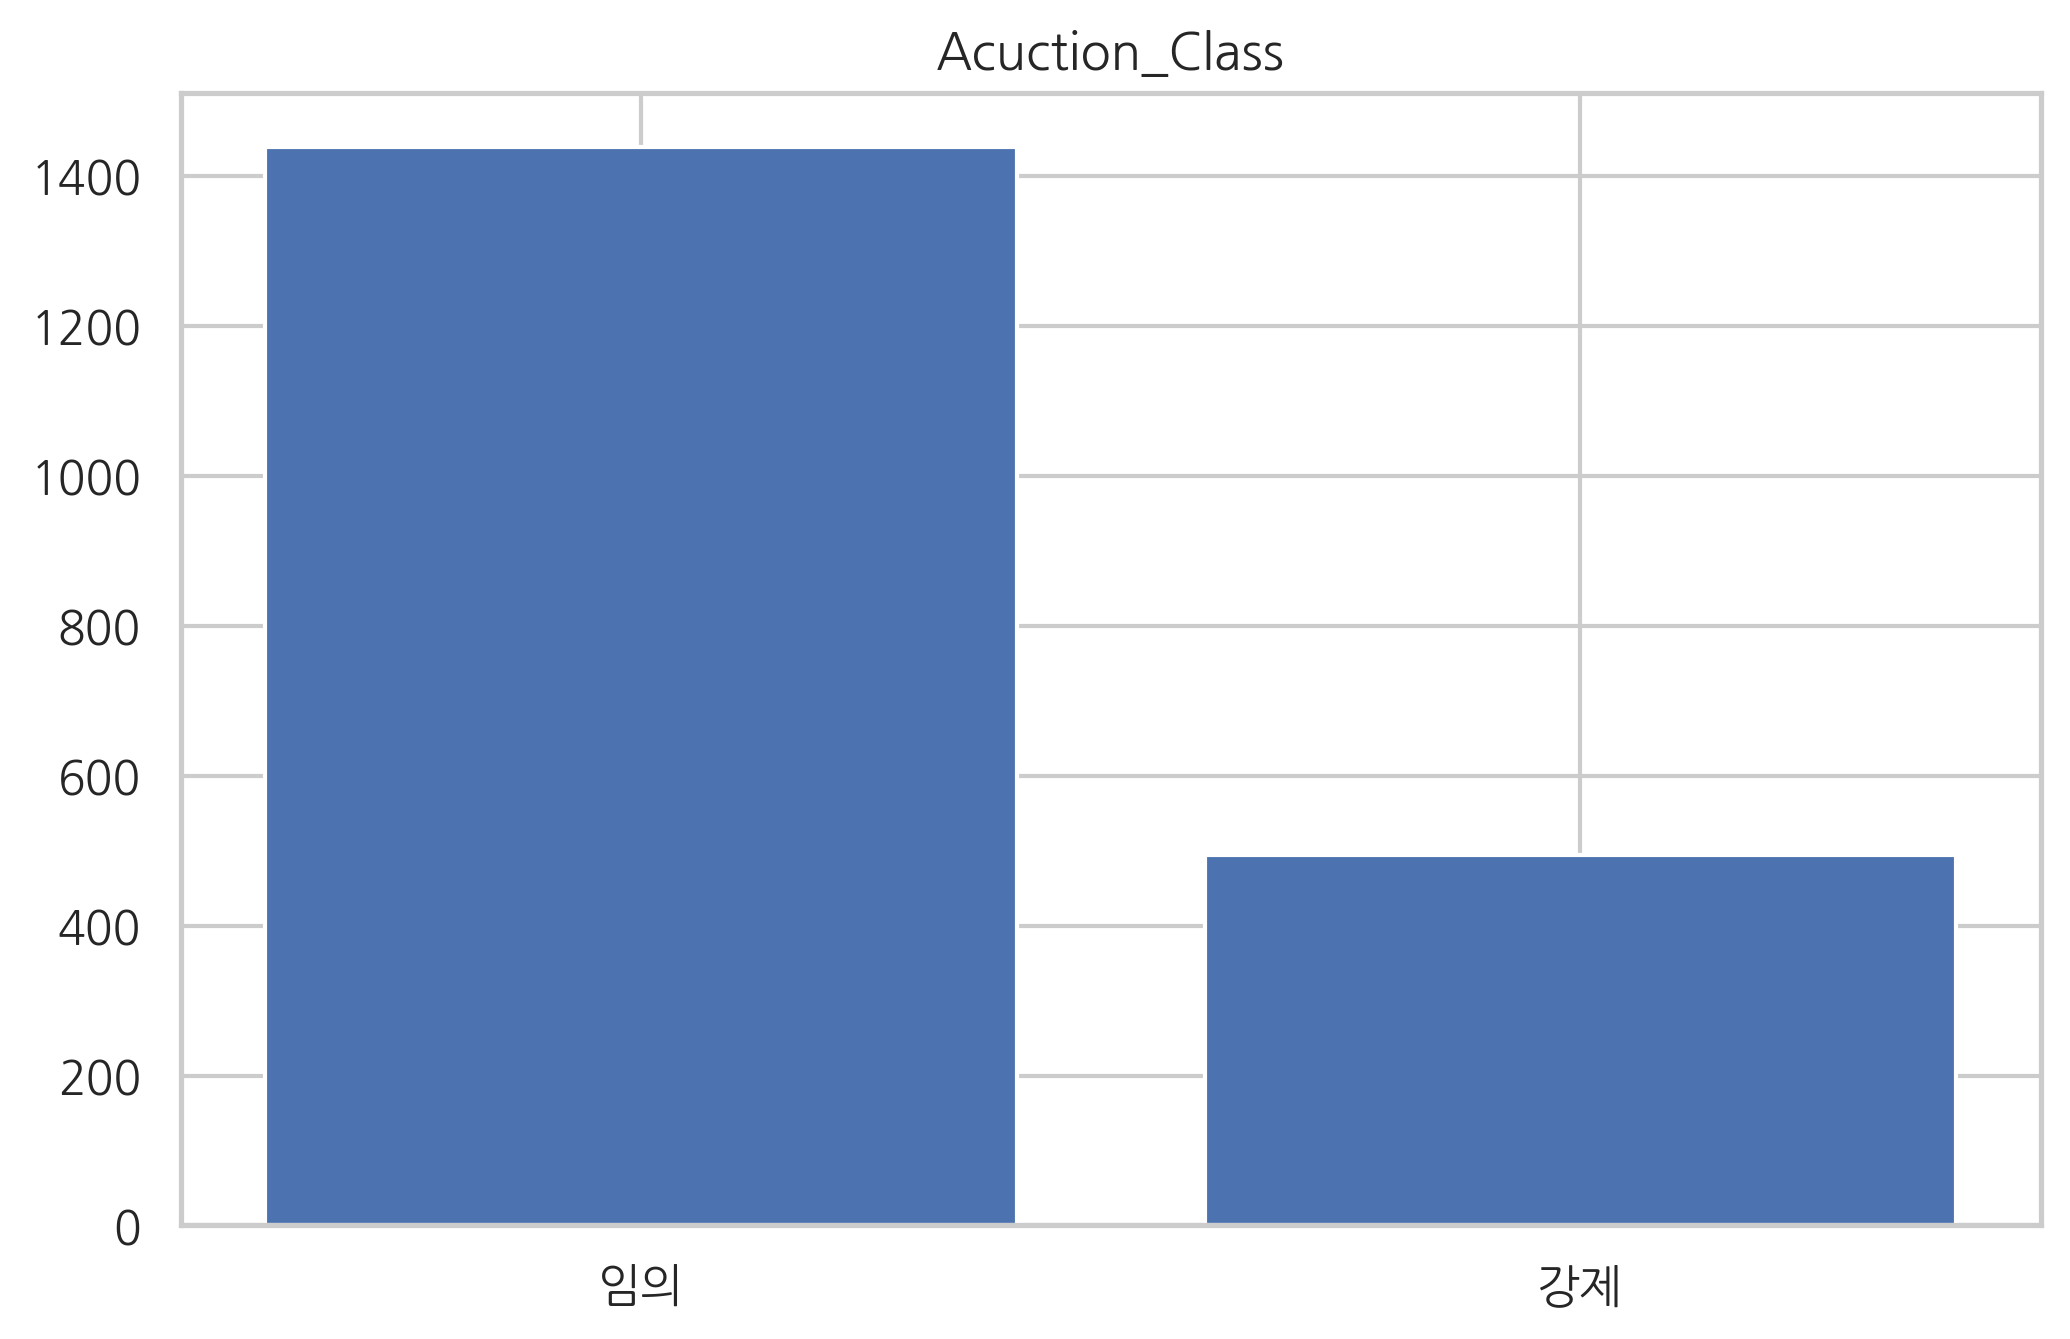

In [10]:
# Acuction_Class
Auc_cl = pd.Series.value_counts(train.Auction_class)
plt.bar(Auc_cl.index, Auc_cl)
plt.title("Acuction_Class")
plt.show()

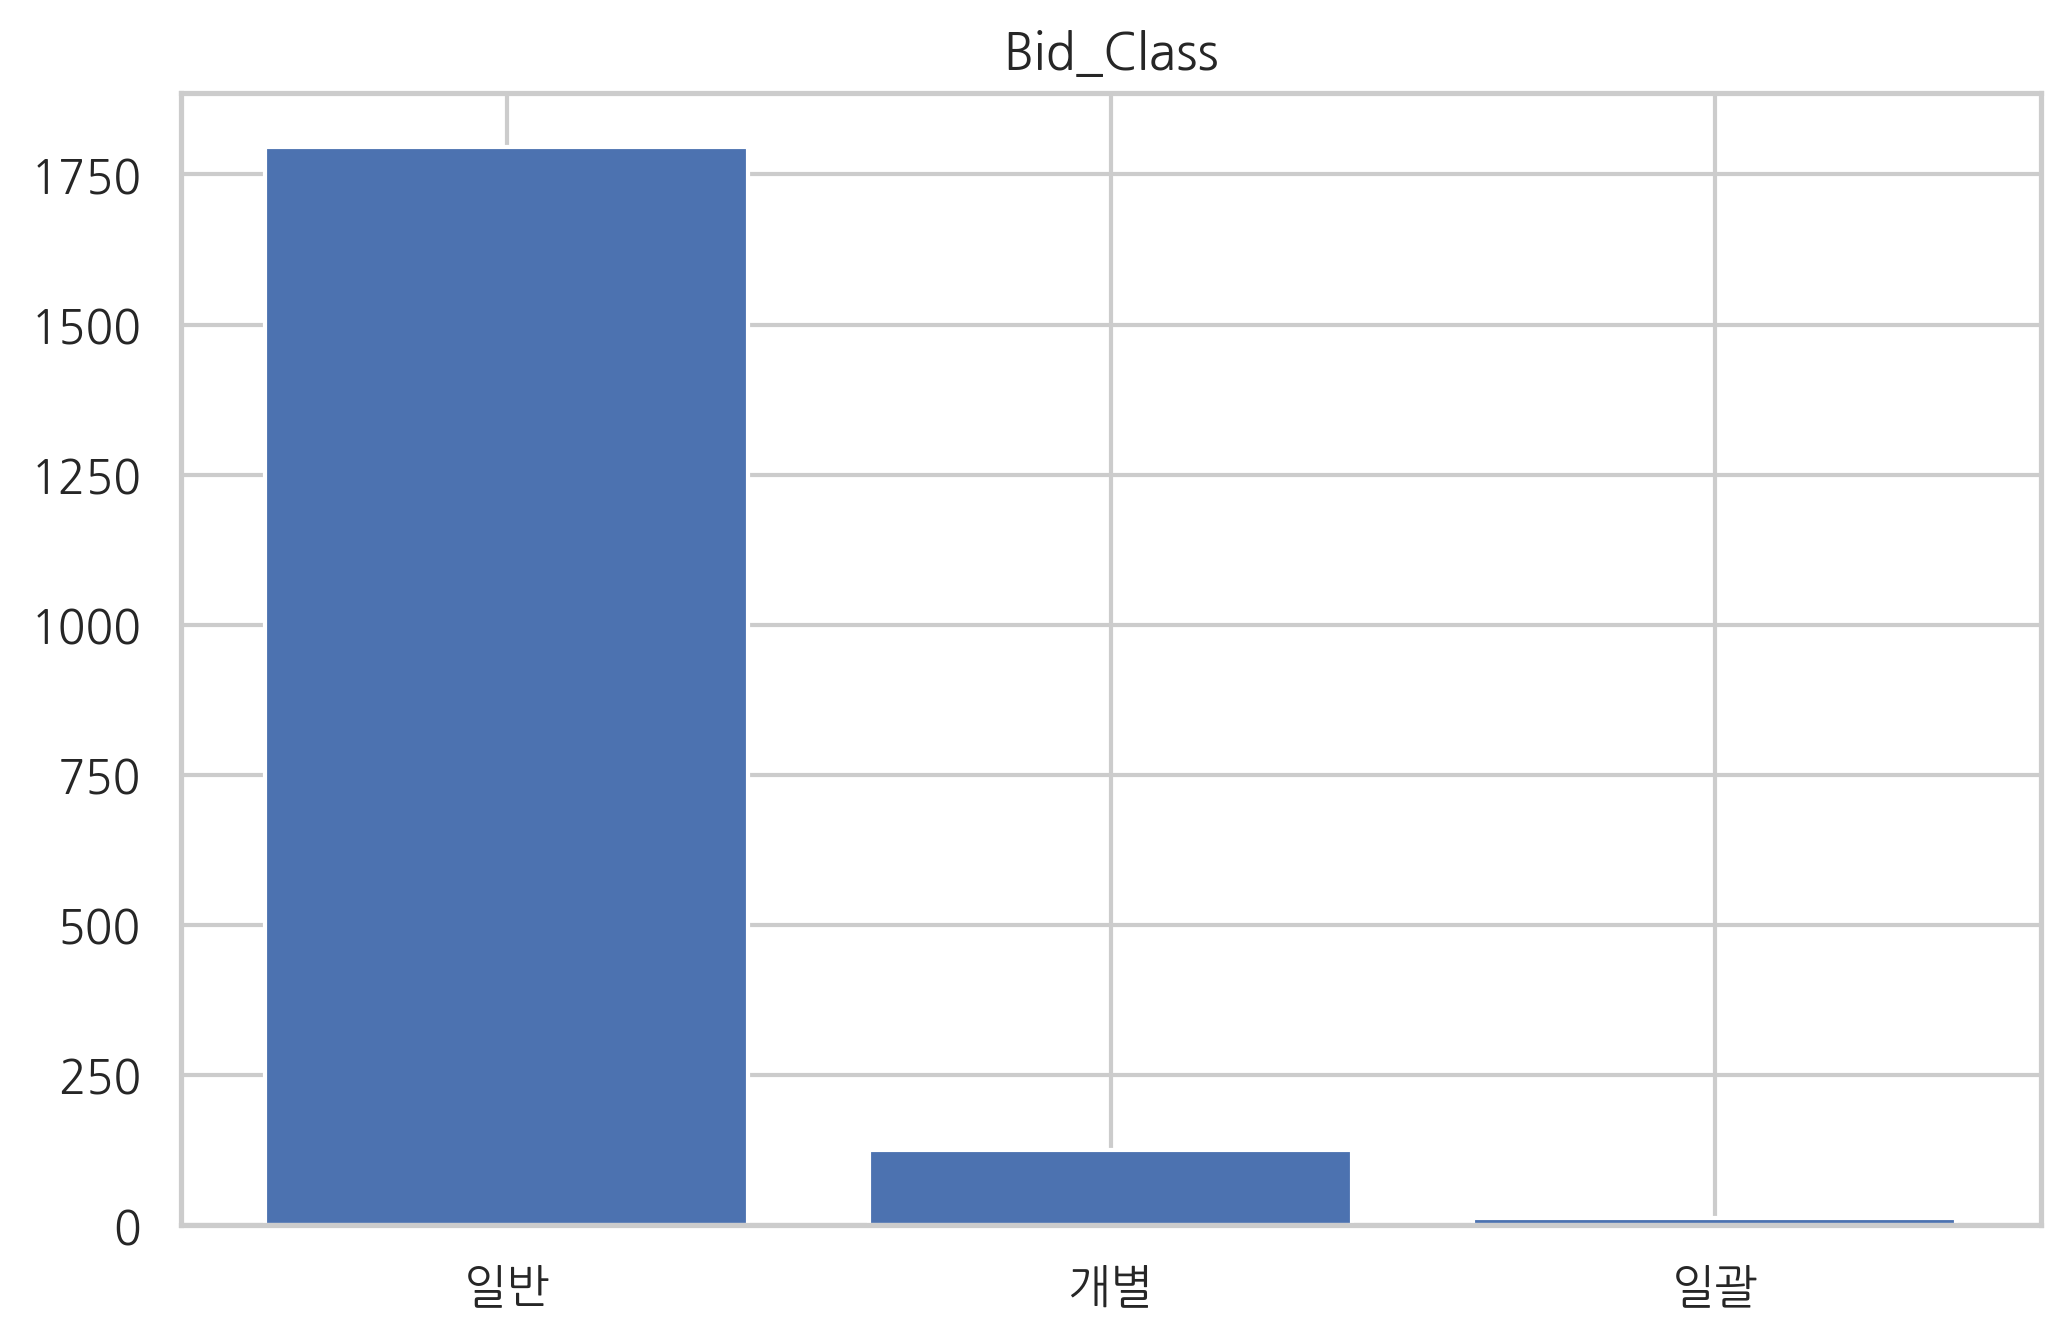

In [16]:
#Bid_Class
Bid_cl = pd.Series.value_counts(train.Bid_class)
plt.bar(Bid_cl.index, Bid_cl)
plt.title("Bid_Class")
plt.show()

In [11]:
pd.Series.value_counts(train.Bid_class)

일반    1796
개별     125
일괄      12
Name: Bid_class, dtype: int64

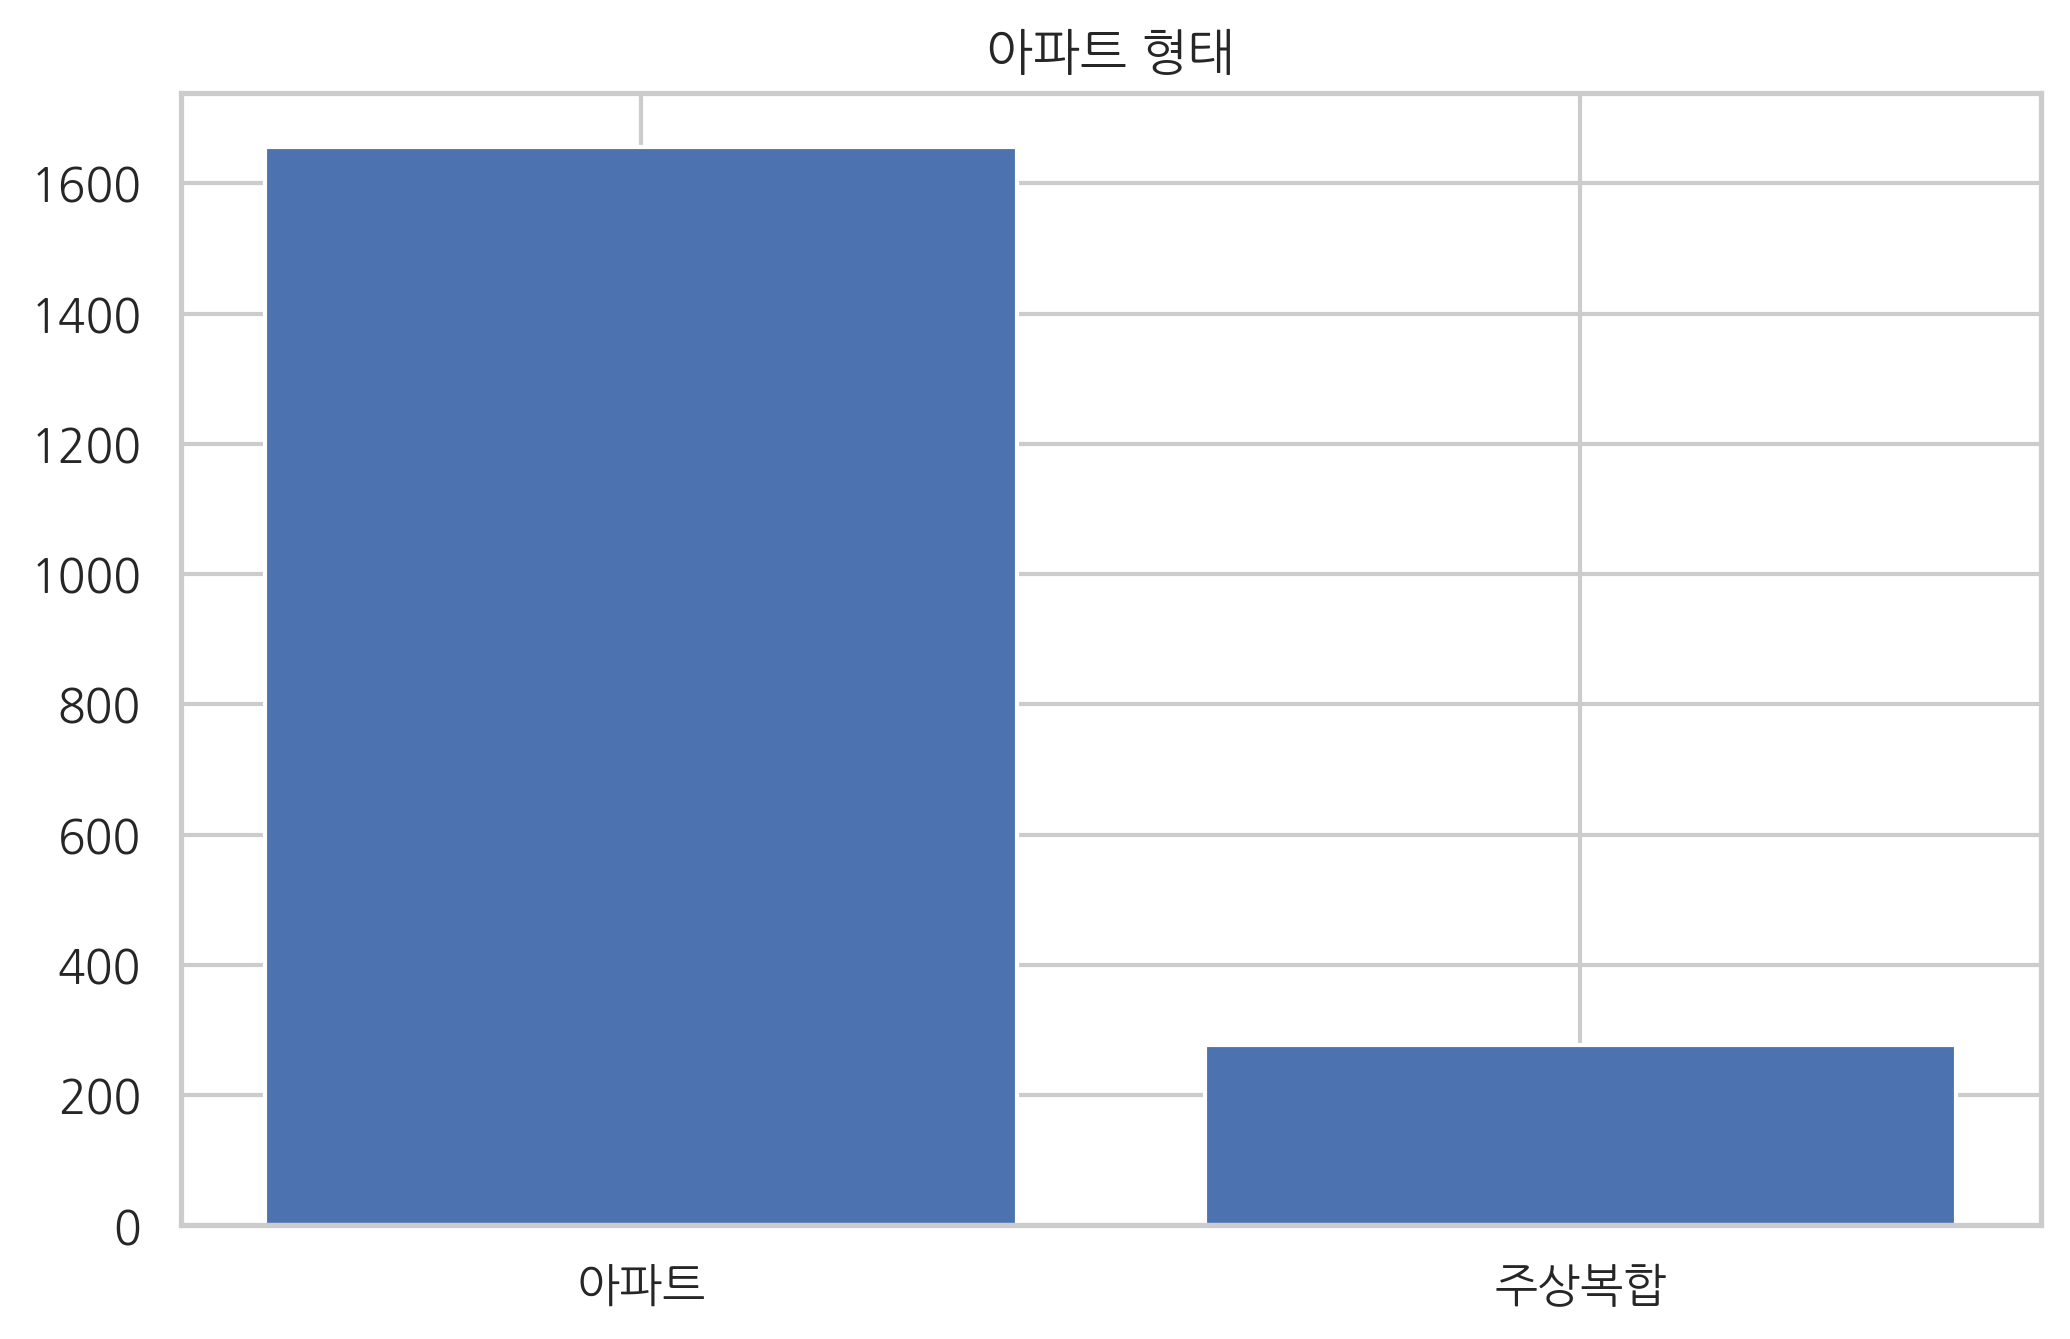

In [88]:
#Apartment_usage
Ap_us = pd.Series.value_counts(train.Apartment_usage)
plt.bar(Ap_us.index, Ap_us)
plt.title("아파트 형태")
plt.show()

In [89]:
#Total_floor
print(sorted(pd.Series.unique(train.Total_floor)))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 55, 58, 59, 66, 69, 70, 71, 75, 80]


In [90]:
#Total_floor
print(sorted(pd.Series.unique(train.Current_floor)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 44, 46, 49, 50, 51, 57, 58, 61, 63, 65]


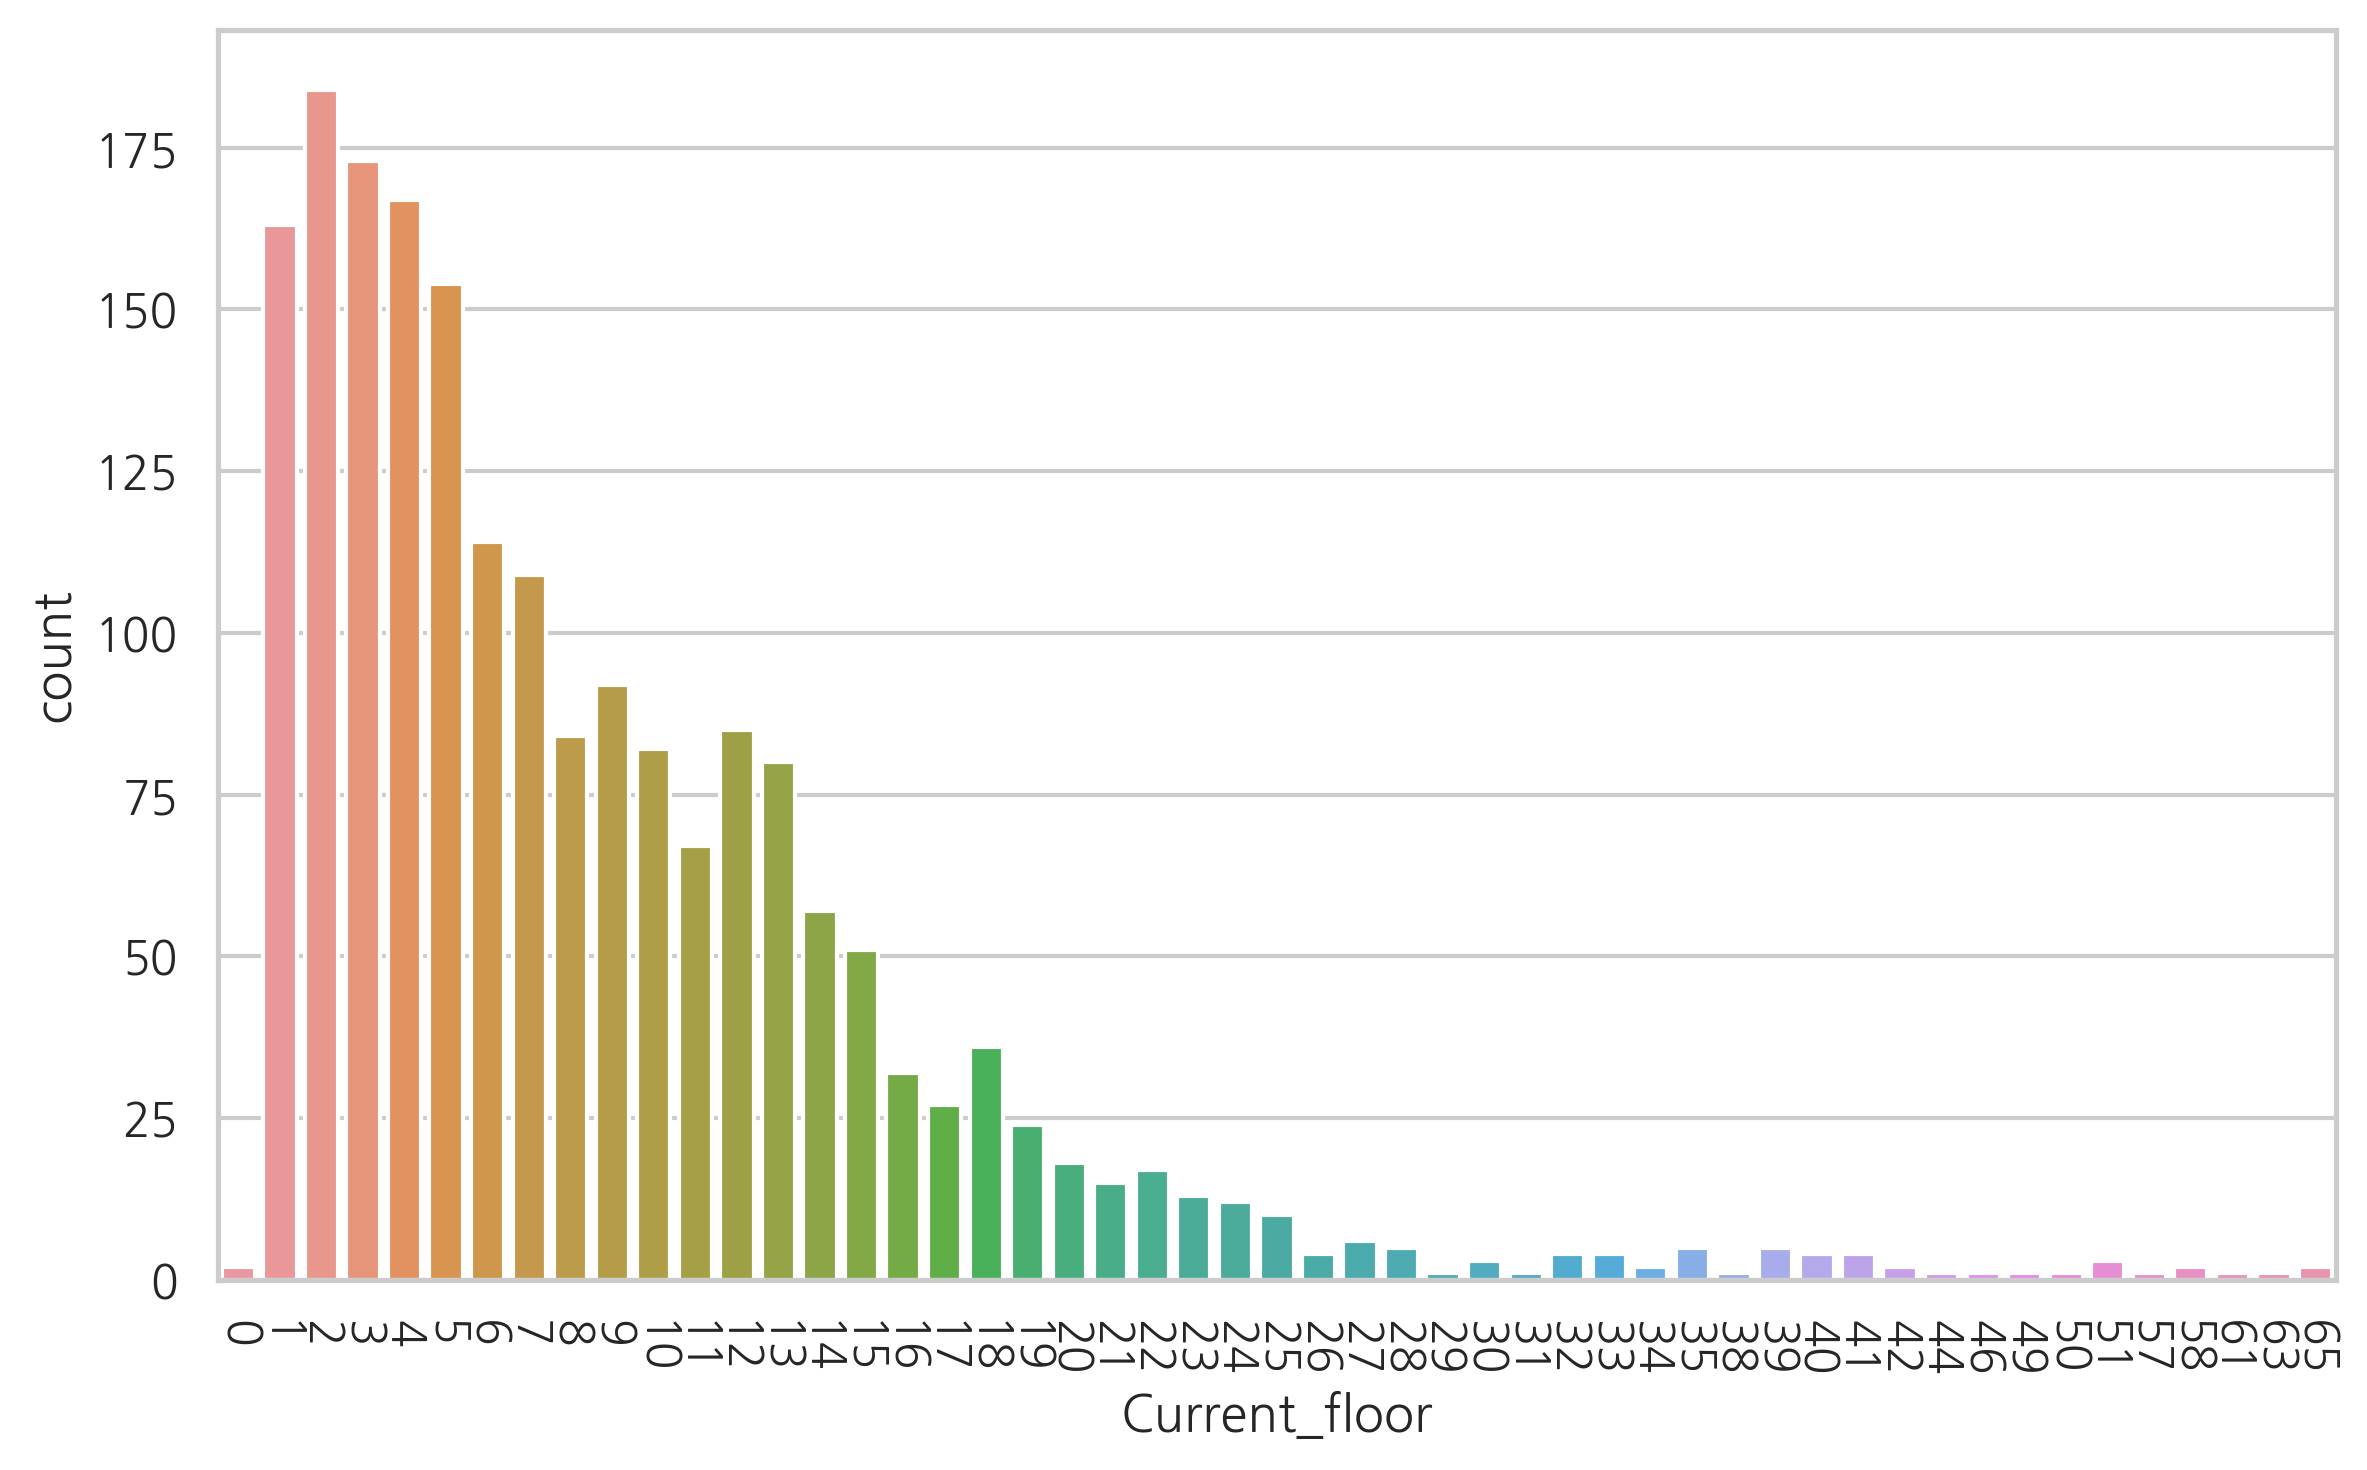

In [91]:

sns.countplot(x="Current_floor", data=train)

plt.xticks(rotation = - 90 )

plt.tight_layout()

plt.show()


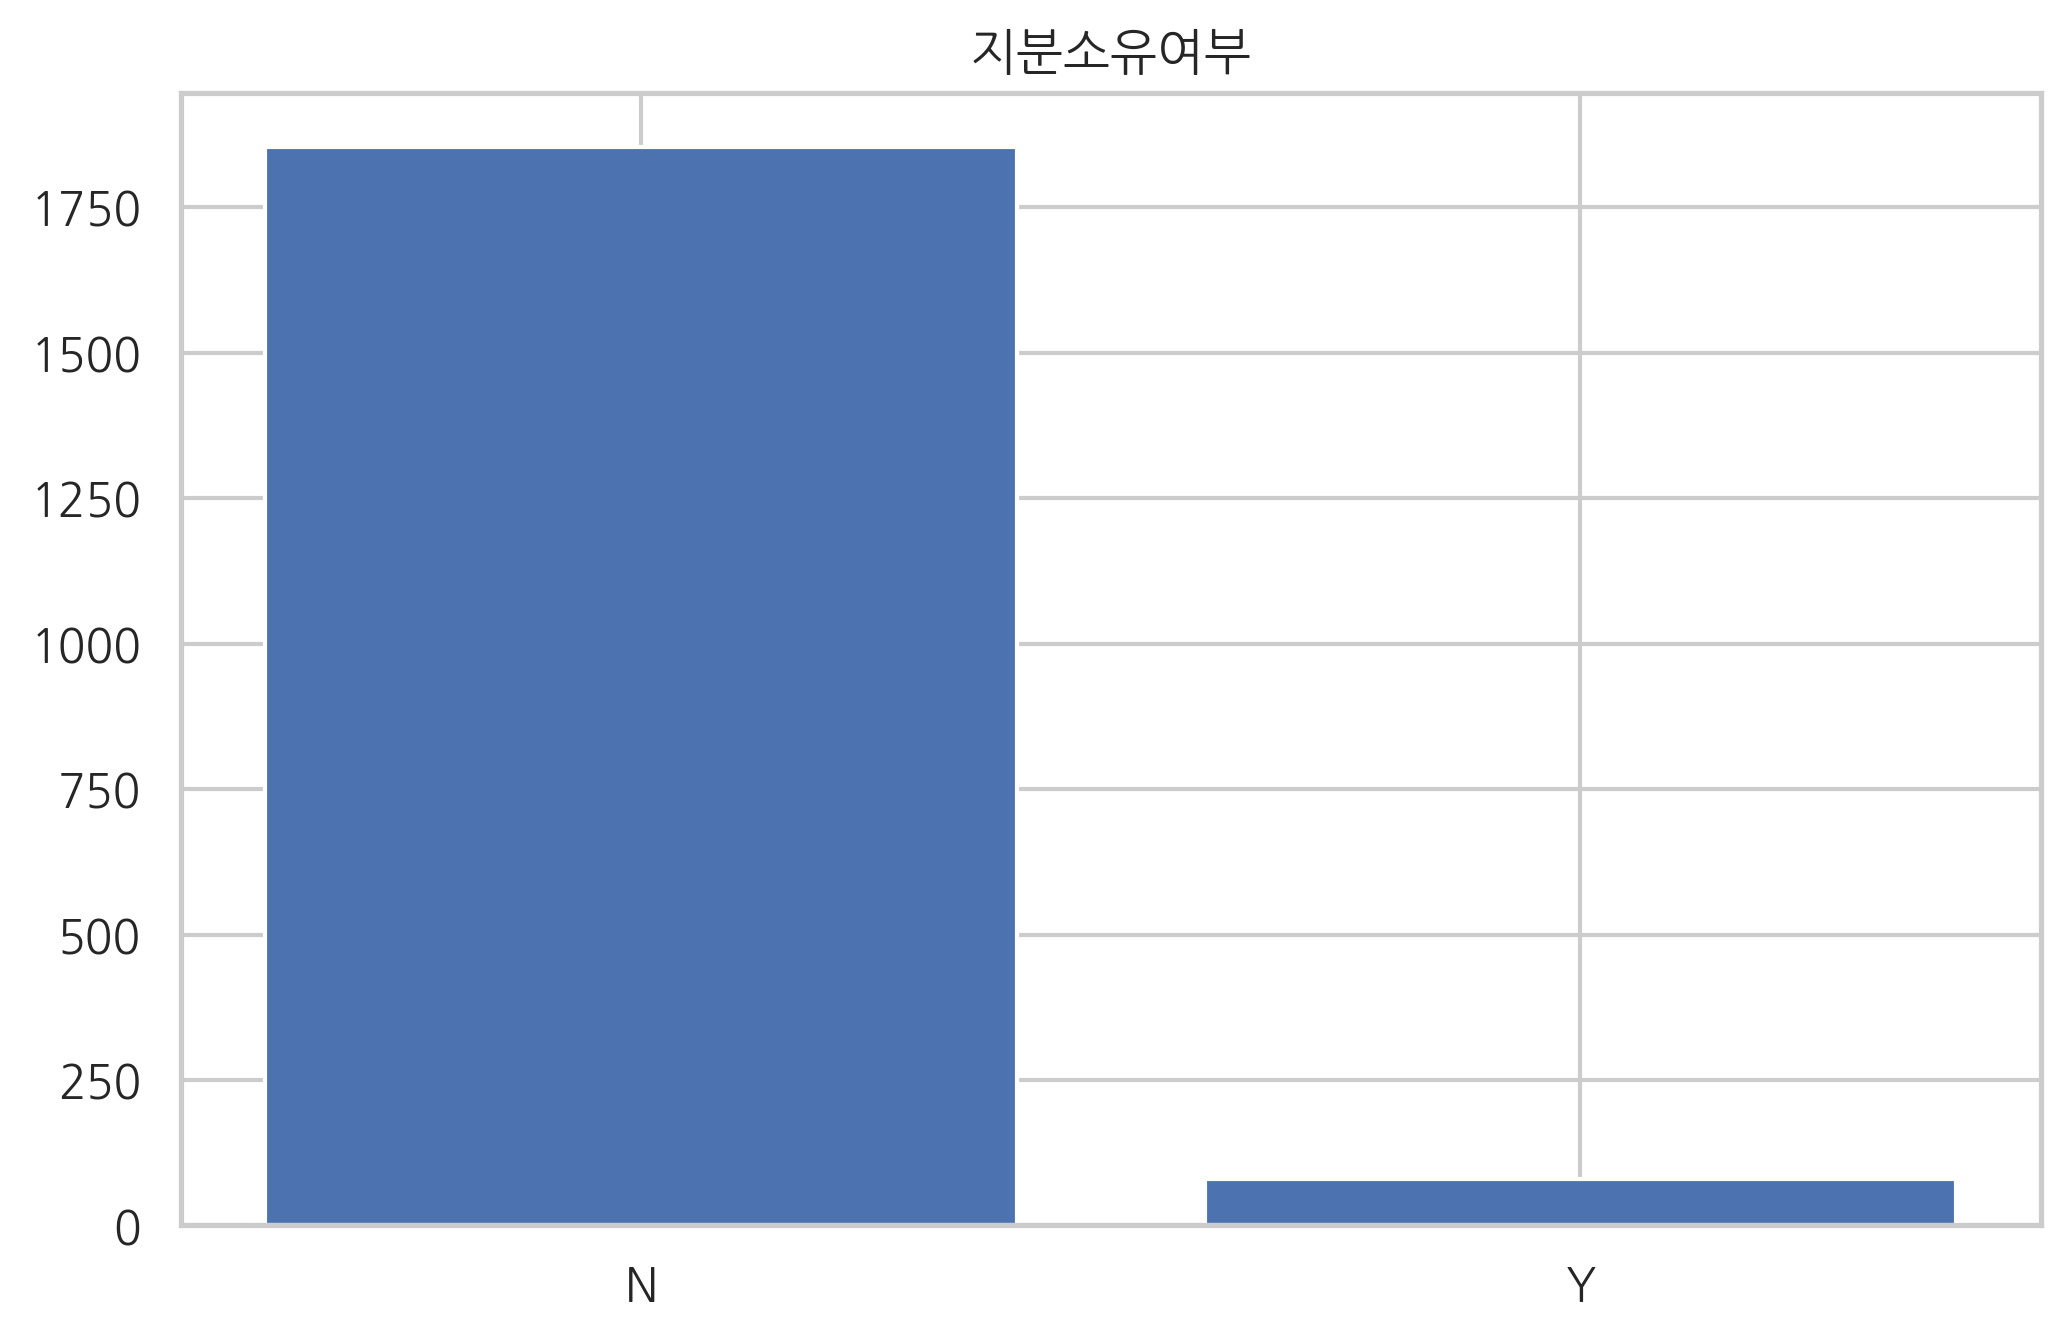

In [92]:
# Share_auction_YorN
Sh_au_yo = pd.Series.value_counts(train.Share_auction_YorN)
plt.bar(Sh_au_yo.index, Sh_au_yo)
plt.title("지분소유여부")
plt.show()

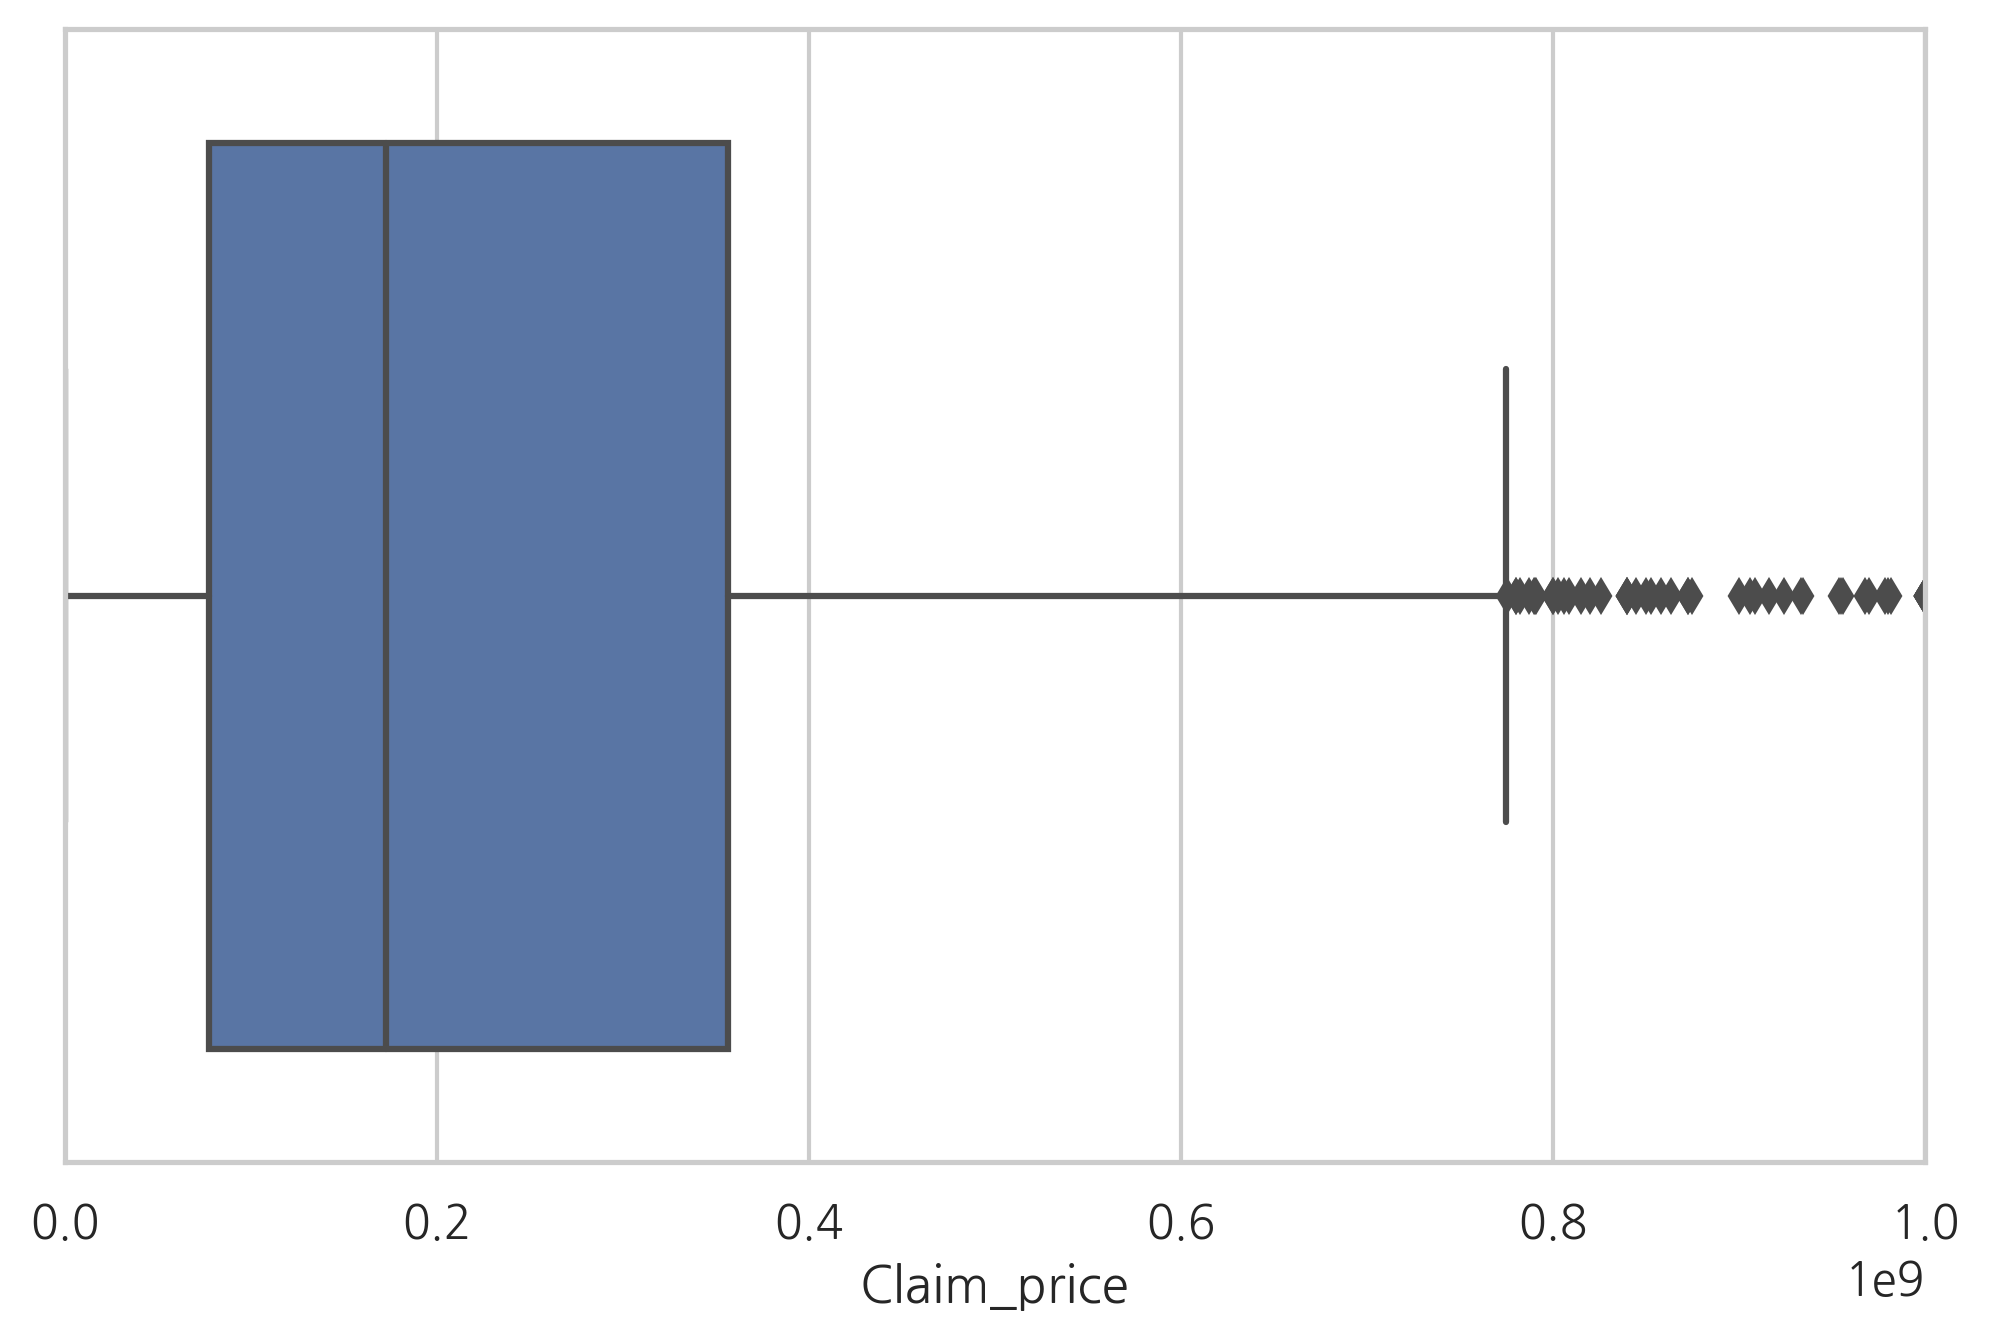

In [85]:
#claim price - 경매 청구 금액
sns.boxplot(x = 'Claim_price', data= train)
plt.xlim(0, 1*1e9)
plt.show()

In [14]:
#Appraisal_company
App_co = pd.Series.value_counts(train.Appraisal_company)
App_co
print(pd.Series.unique(train.Appraisal_company))

['정명감정' '희감정' '혜림감정' '신라감정' '나라감정' '한마음감정' '미래새한감정' '부일감정' '금정감정' '연산감정'
 '명장감정' '문일감정' '미르감정' '국제감정' '드림감정' '대일감정' '대한감정' '내외감정' '오상호감정' '대화감정'
 '태화감정' '하나감정' '써브감정' '부경감정' '통일감정' '삼보감정' '한라감정' '제일감정' '평진감정' '명신감정'
 '산하늘감정' '삼일감정' '가화감정' '극동감정' '태평양감정' 'BNK감정' '프라임감정' '세중감정' '우리감정' '혜인감정'
 '가온감정' '한신감정' '알비감정' '삼창감정' '가람감정' '류선감정' '대우감정' '우성감정' '중앙감정' 'RB감정'
 '준일감정' '석원감정' '경문감정' '구수미감정' '리파인감정' '우민감정' '신원감정' '현감정' '티앤비감정' '자연감정'
 '온날감정' '선감정' '로얄감정' '다원감정' '원중감정' '민현기감정' '경희감정' '지평감정' '서초감정' '성북감정'
 '컬림비아감정' '청학감정' '삼상감정' '정일감정' '태백감정' '문민감정' '한울감정' '성현감정' '무이감정' '나래감정'
 '이응감정' '이노감정' '성민감정' '강진감정' '가인감정' '삼성감정' '계산감정' '라온감정' '국보감정' '정감정'
 '지산감정' '강산감정' '해랑감정' '동인감정' '강림감정' '남산감정' '에이원감정' '지녕감정' '진주감정' '율감정'
 '세아감정' '내일감정' '신성감정' '신명감정' '공감감정' '이정희감정' '현대기업감정' '두환감정' '지우감정' '온나라감정'
 '생림감정' '우주감정' '동부감정' '한미감정' '해솔감정' '시현감정' '한감정' '대신감정' '동우감정' '건감정'
 '인헌감정' '더존감정' '그린감정' '미강감정' '하률감정' '한국씨티감정' '수서감정' '신평감정' '신화감정' '새인감정'
 '최연순감정' '하보나감정' '바른감정' '새온감정' '현산감정' '엘리트감정' '대성감정' 'L.H감정' 'Y

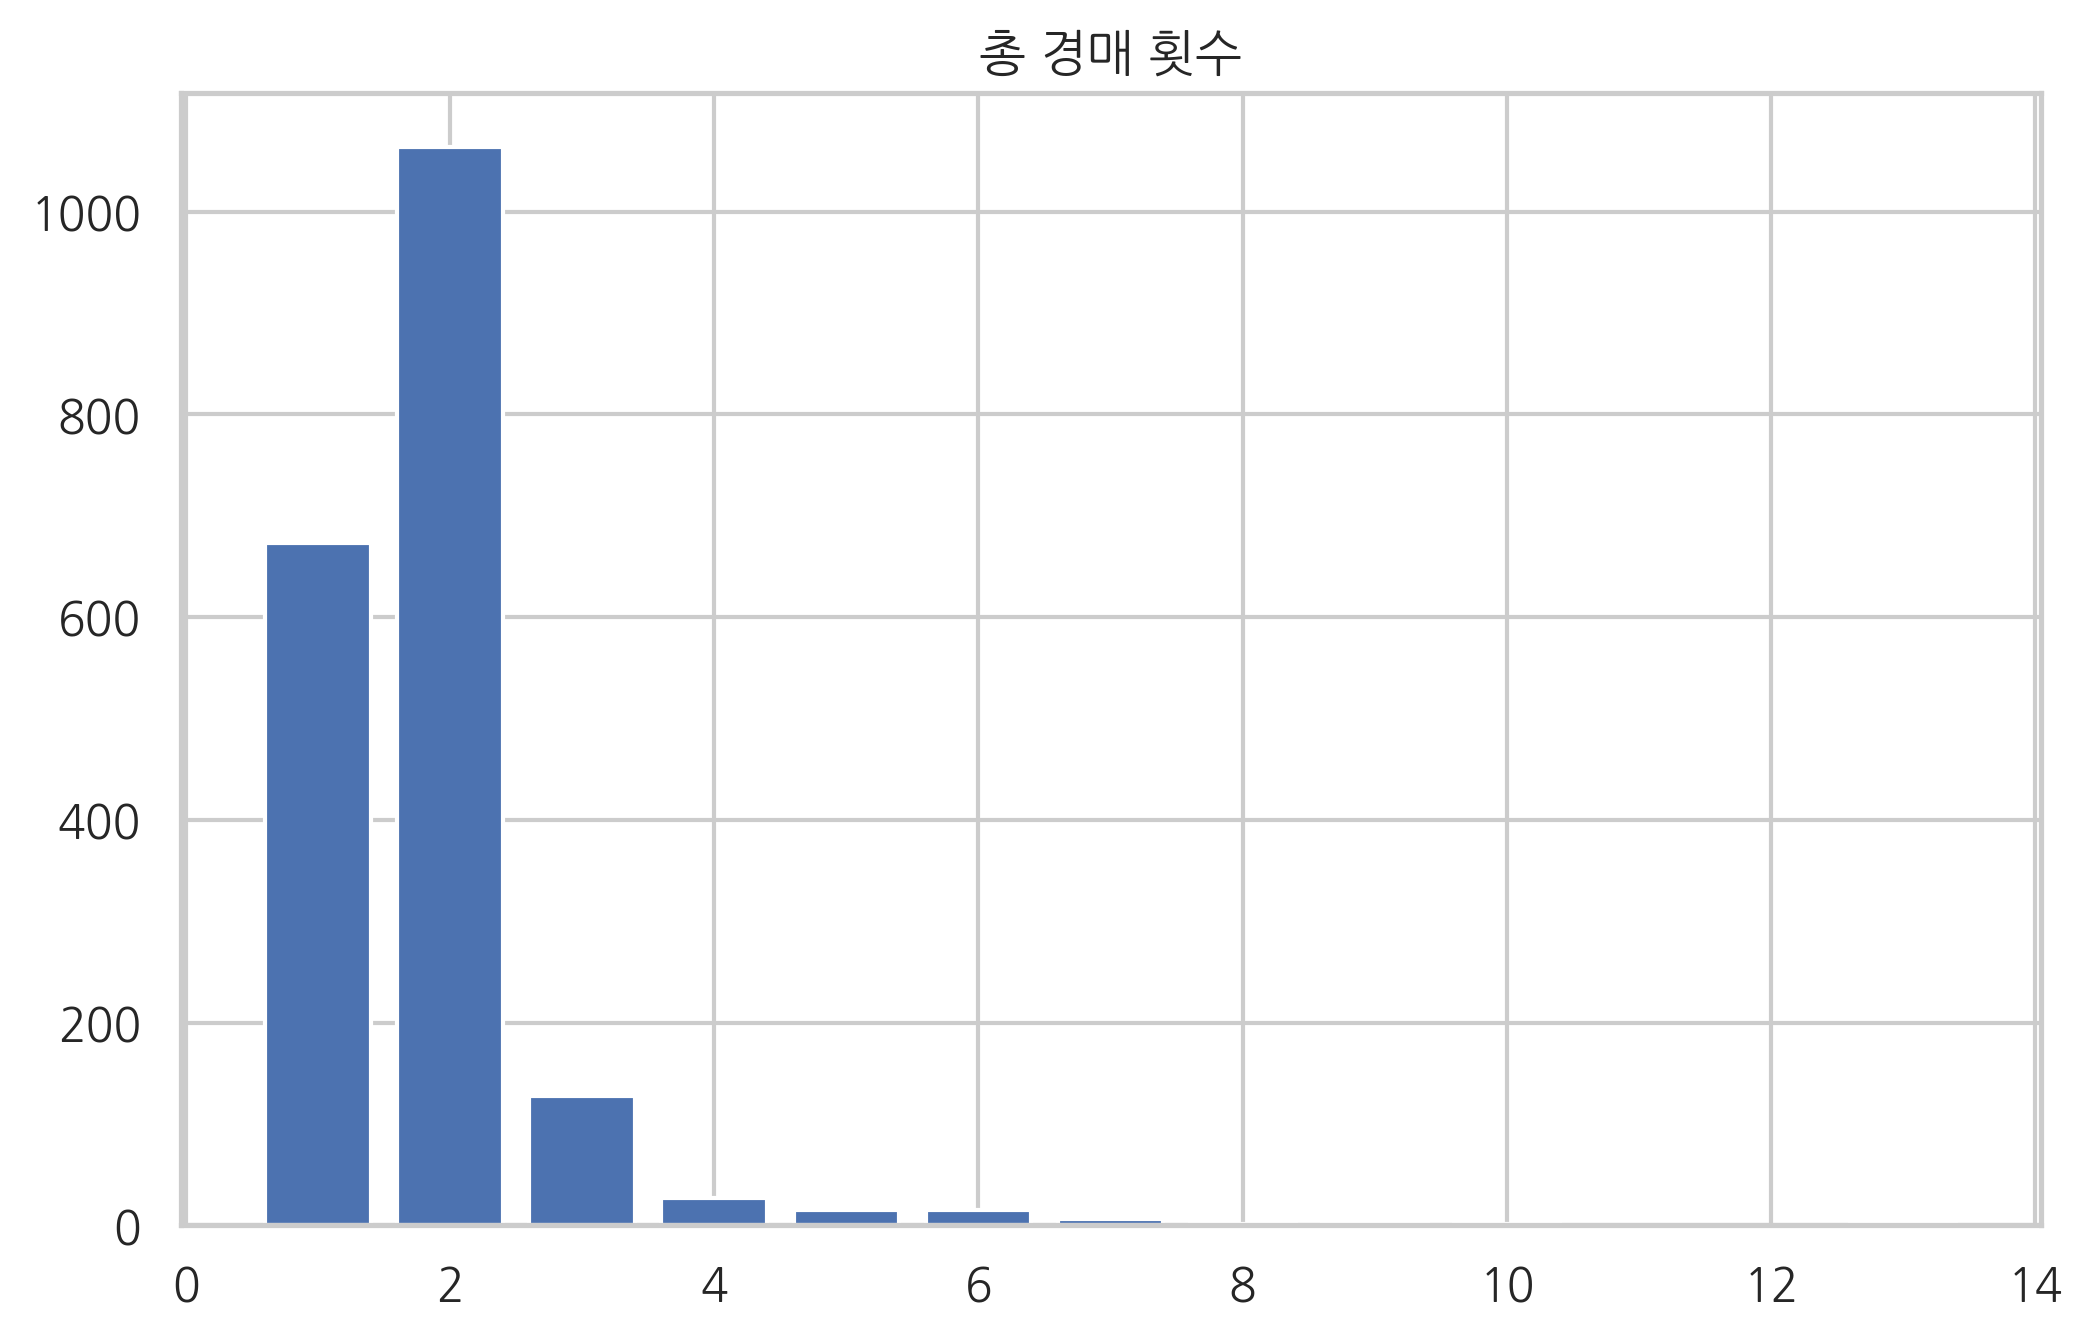

In [18]:
# Auction_count 총 경매 횟수
Auc_co = pd.Series.value_counts(train.Auction_count)
plt.bar(Auc_co.index, Auc_co)
plt.title("총 경매 횟수")
plt.show()

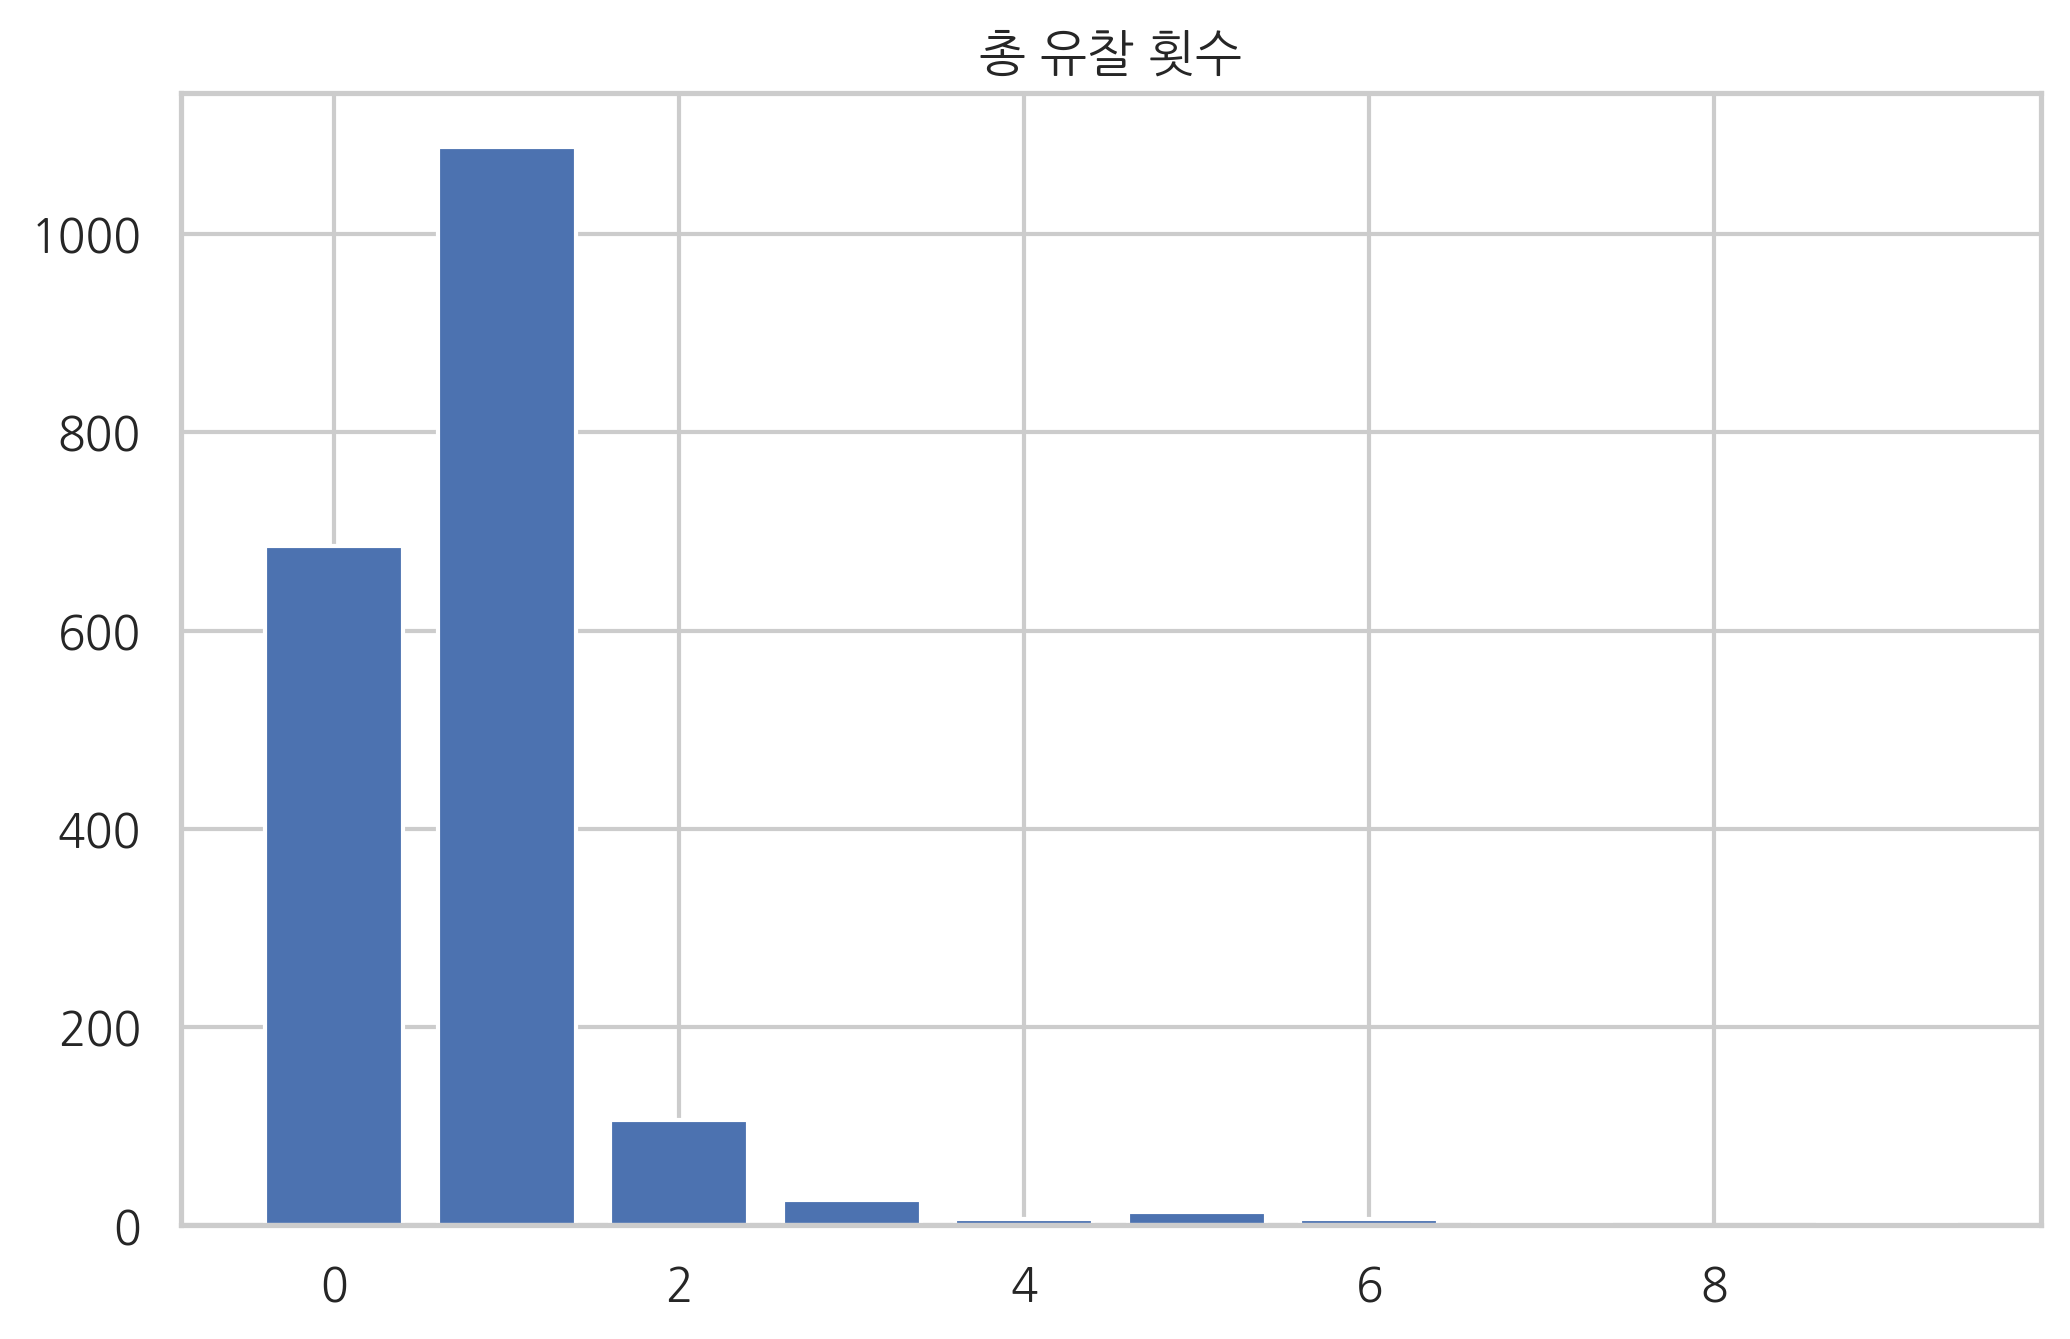

In [19]:
#Auction_miscarriage_count 총 유찰 횟수
Auc_miss_co = pd.Series.value_counts(train.Auction_miscarriage_count)
plt.bar(Auc_miss_co.index, Auc_miss_co)
plt.title("총 유찰 횟수")
plt.show()

In [86]:
# 연도별 경매 낙찰건수
train['Final_auction_date'] = pd.to_datetime(train['Final_auction_date'], errors='coerce')
train["F_Year"] = train.Final_auction_date.dt.year
train["F_Month"] = train.Final_auction_date.dt.month
train["F_DayOfYear"] = train.Final_auction_date.dt.dayofyear
train["F_DayOfMonth"] = train.Final_auction_date.dt.daysinmonth #며칠인지
train["F_DayOfWeek"] = train.Final_auction_date.dt.dayofweek #몇요일인지
train["F_WeekOfYear"] = train.Final_auction_date.dt.weekofyear #몇번째 주
train["F_Weekday"] = train.Final_auction_date.dt.weekday
train["F_IsMonthStart"] = train.Final_auction_date.dt.is_month_start
train["F_IsMonthEnd"] = train.Final_auction_date.dt.is_month_end

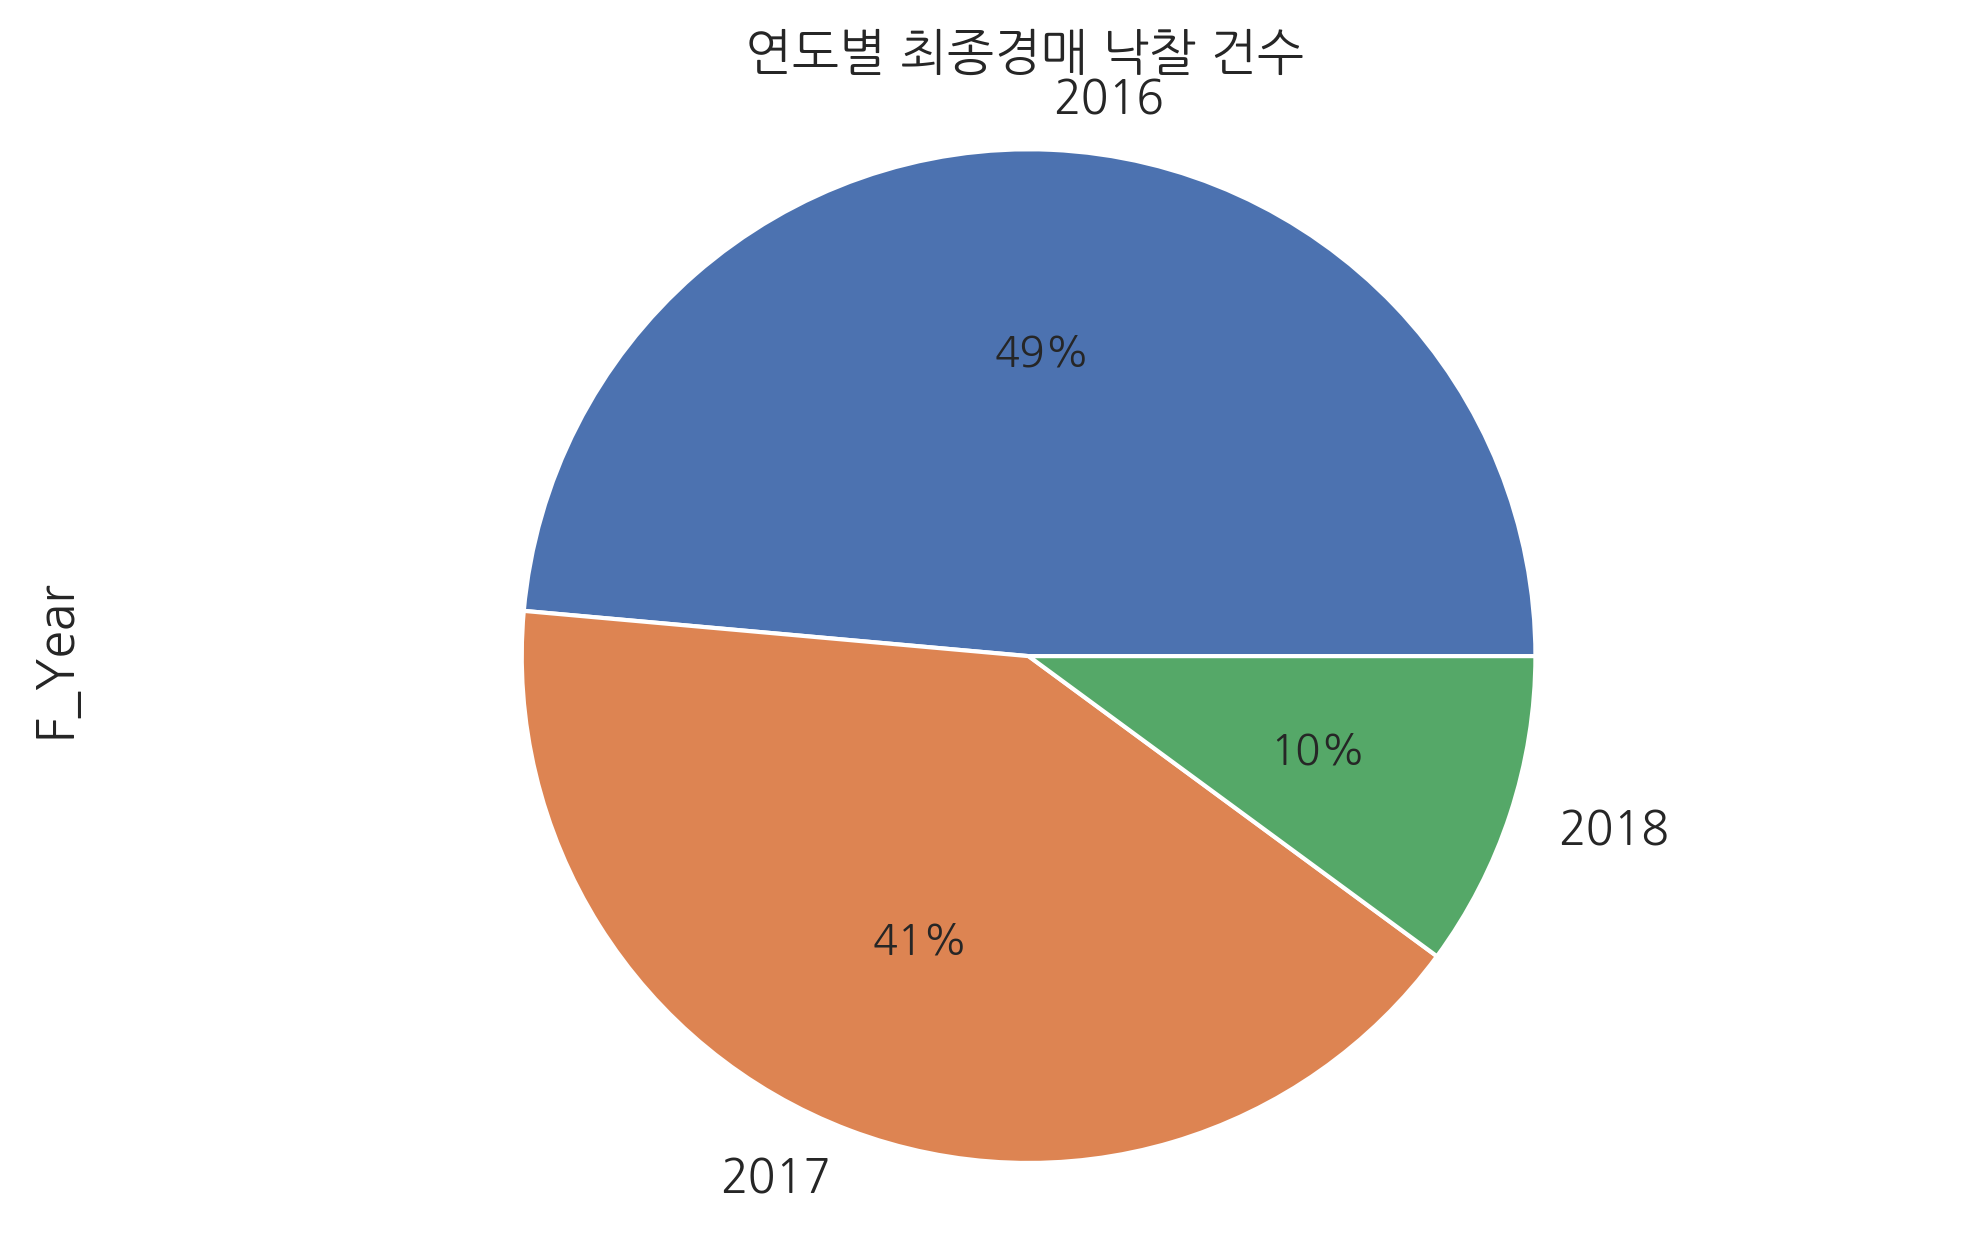

In [87]:
df1 = train.F_Year.value_counts()
df1.plot.pie(autopct='%2.f%%')
plt.axis('equal')
plt.title("연도별 최종경매 낙찰 건수")
plt.show()

In [94]:
#Creditor
print(pd.Series.unique(train.Creditor))

['베리타스자산관리대부' '흥국저축은행' '국민은행' '고려저축은행' 'Private' '서울보증보험' '천마(새)' '대형선망수협'
 '디에이치대부' '코카콜라음료' '한화저축은행' '프라임대부' '대부F&D' 'HK저축은행' '부산은행' '농협은행'
 '청룡동(새)' '케이에이제7차유동화전문' '신용보증기금' '반야월농협' '제이티캐피탈' '오케이캐피탈대부' '우리은행'
 '대구은행' '삼성카드' '영진건설' '한화손해보험' '하나은행' '유진대부금융' '동부화재해상보험' '비에스금융대부'
 '(주)티베이' '범일5동(새)' '기술보증기금' '중소기업은행' '신한카드' '해운대신협' '승학(새)' '승학신협' '두산건설'
 '동래농협' '농협생명보험' '한국주택금융공사' '현대캐피탈' 'NH농협캐피탈' '신한생명보험' '동부산농협' '경북대구낙농협'
 '부영벽산아파트입주자대표회의' '한국씨티은행' 'KB국민카드' '디지비캐피탈' '베스트피플대부' '세종상호저축은행' '경남은행'
 '북부산(새)' '한국무역보험공사' '스카이저축은행' '에이치에스제일차유동화전문' '영우유통' '명륜동(새)' '구서2동(새)'
 '남천천신협' '부곡동(새)' '한화생명보험' '영남자원' '비엔케이캐피탈' '대양석유(주)' '부산주례(새)' '대청(새)'
 '중부(새)' '기술신용보증기금' '범일동(새)' '경산농협' '국제저축은행' '그랜드코리아레저' '부산동부신협' '신한은행'
 '웰릭스에프앤아이대부' '대구태영신협' '부산평화(새)' '진주서부농협' '감천1동(새)' '제1,2구잠수기수협' '농소농협'
 'SC은행' '진해수협' '서1동(새)' '현대모비스' '부산화명(새)' '성가신협' '제네시스유동화전문' '아주캐피탈'
 '광안신협' '시민공원(새)' 'JT캐피탈' '북부산신협' '사직1동(새)' '신괴정(새)' '진주저축은행' '감만동(새)'
 '중앙농협' '페퍼저축은행' '늘푸른사상(새)' '금호상사' '새남해(새)' '대부에프앤디' 'KB캐피탈' '서부(새)'
 '

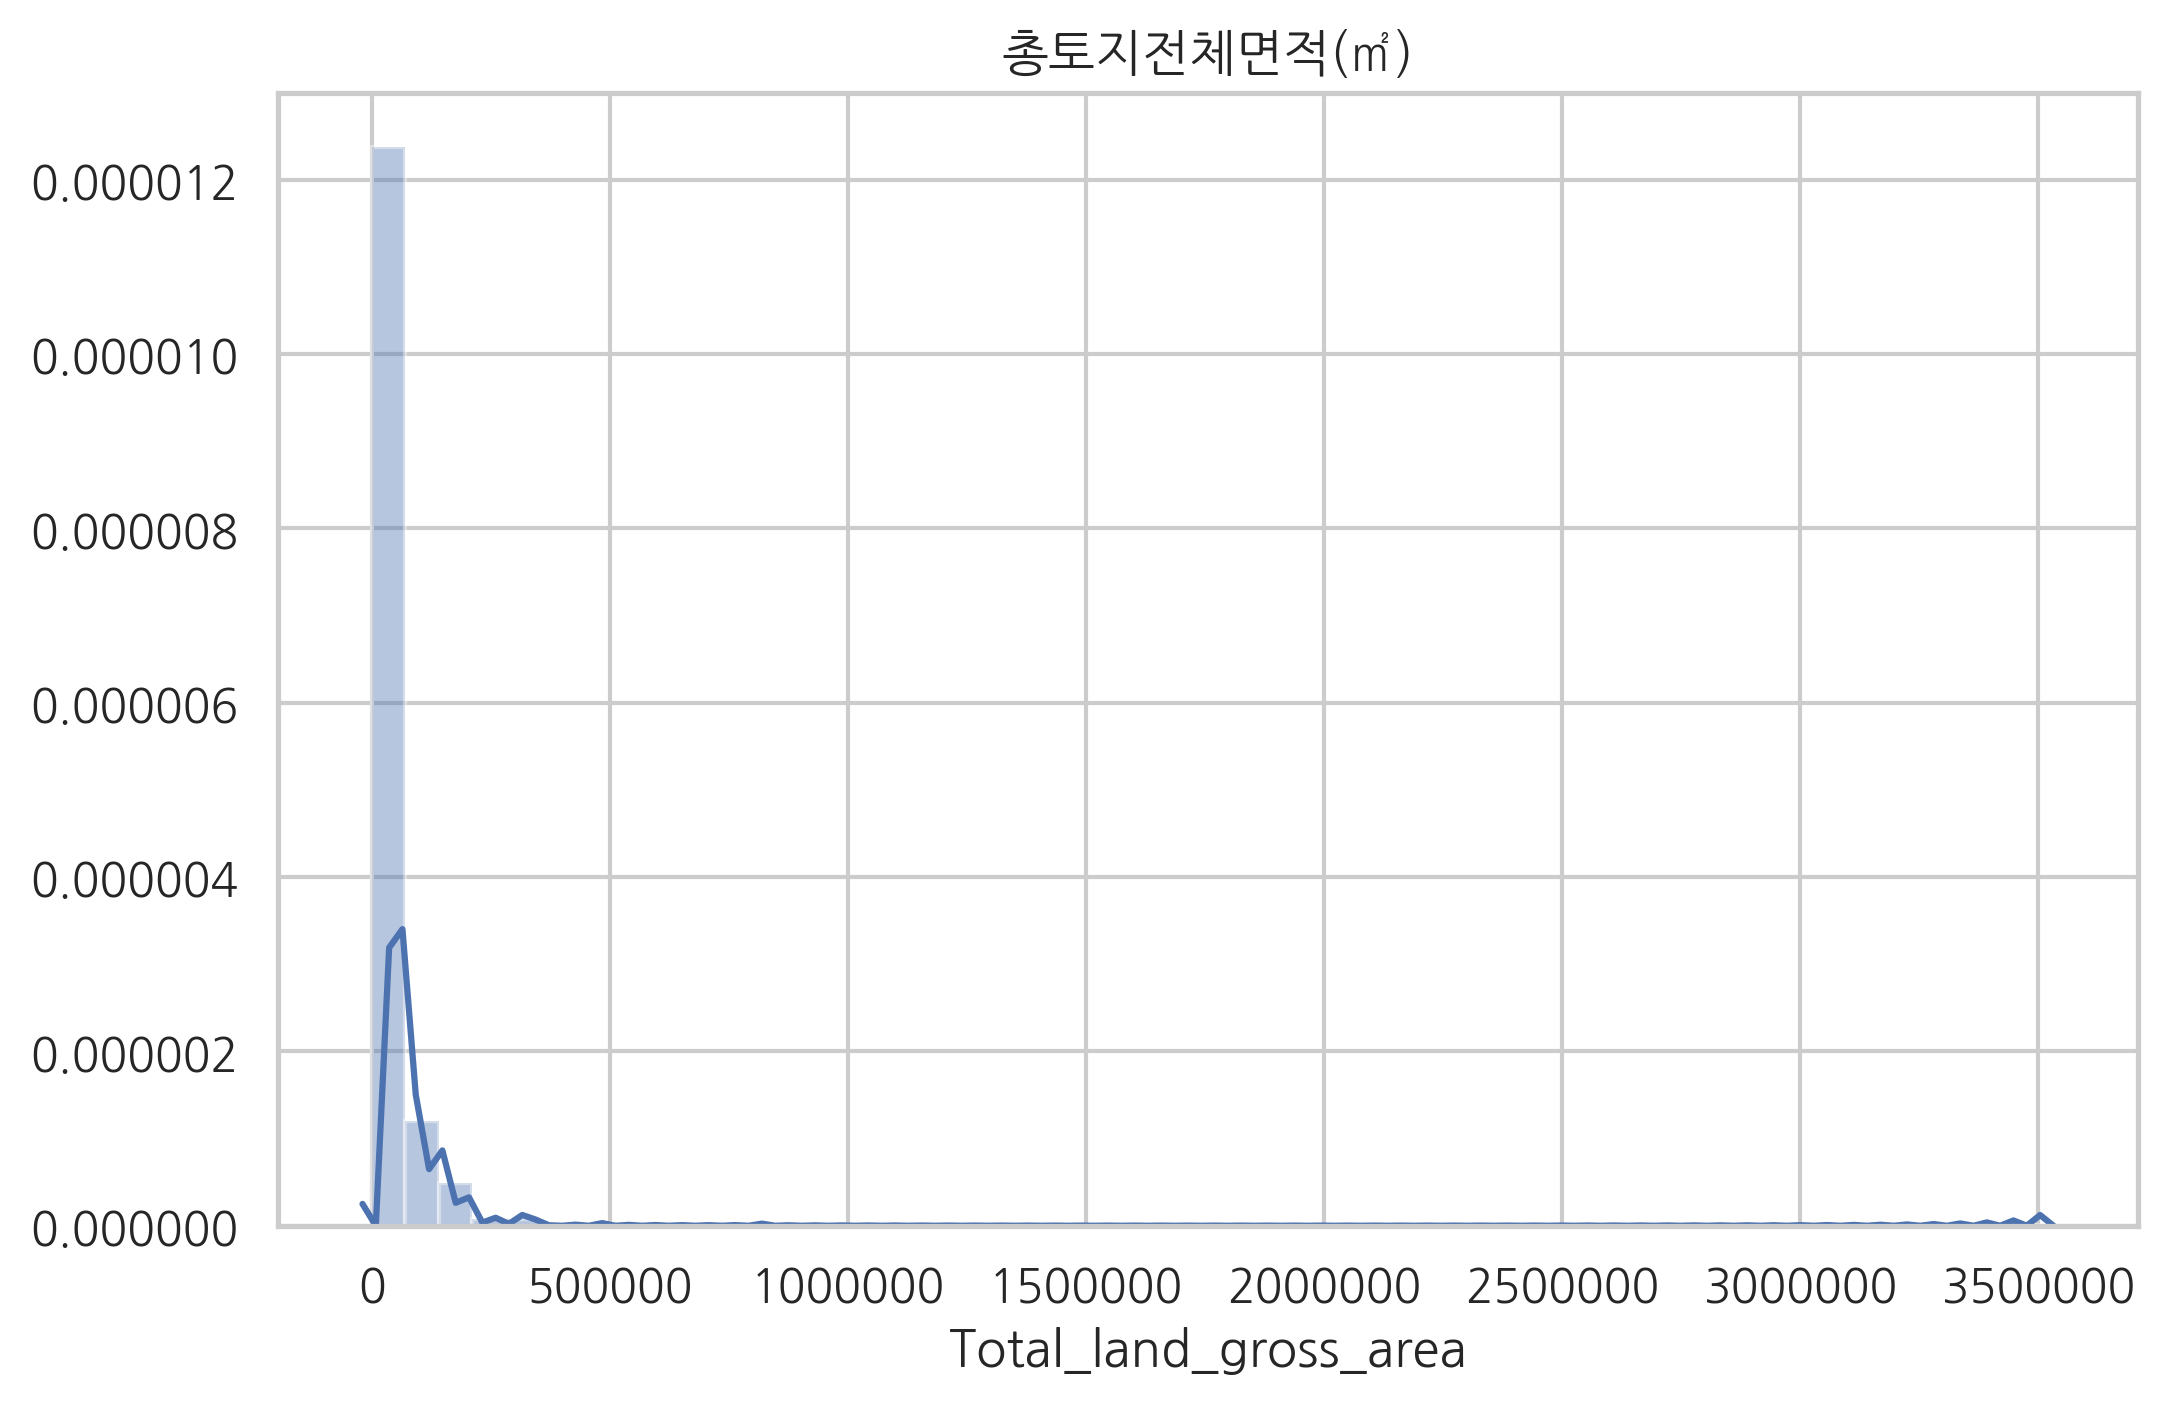

In [20]:
#Total_land_gross_area

sns.distplot(train.Total_land_gross_area)
plt.title("총토지전체면적(㎡)")
plt.show()

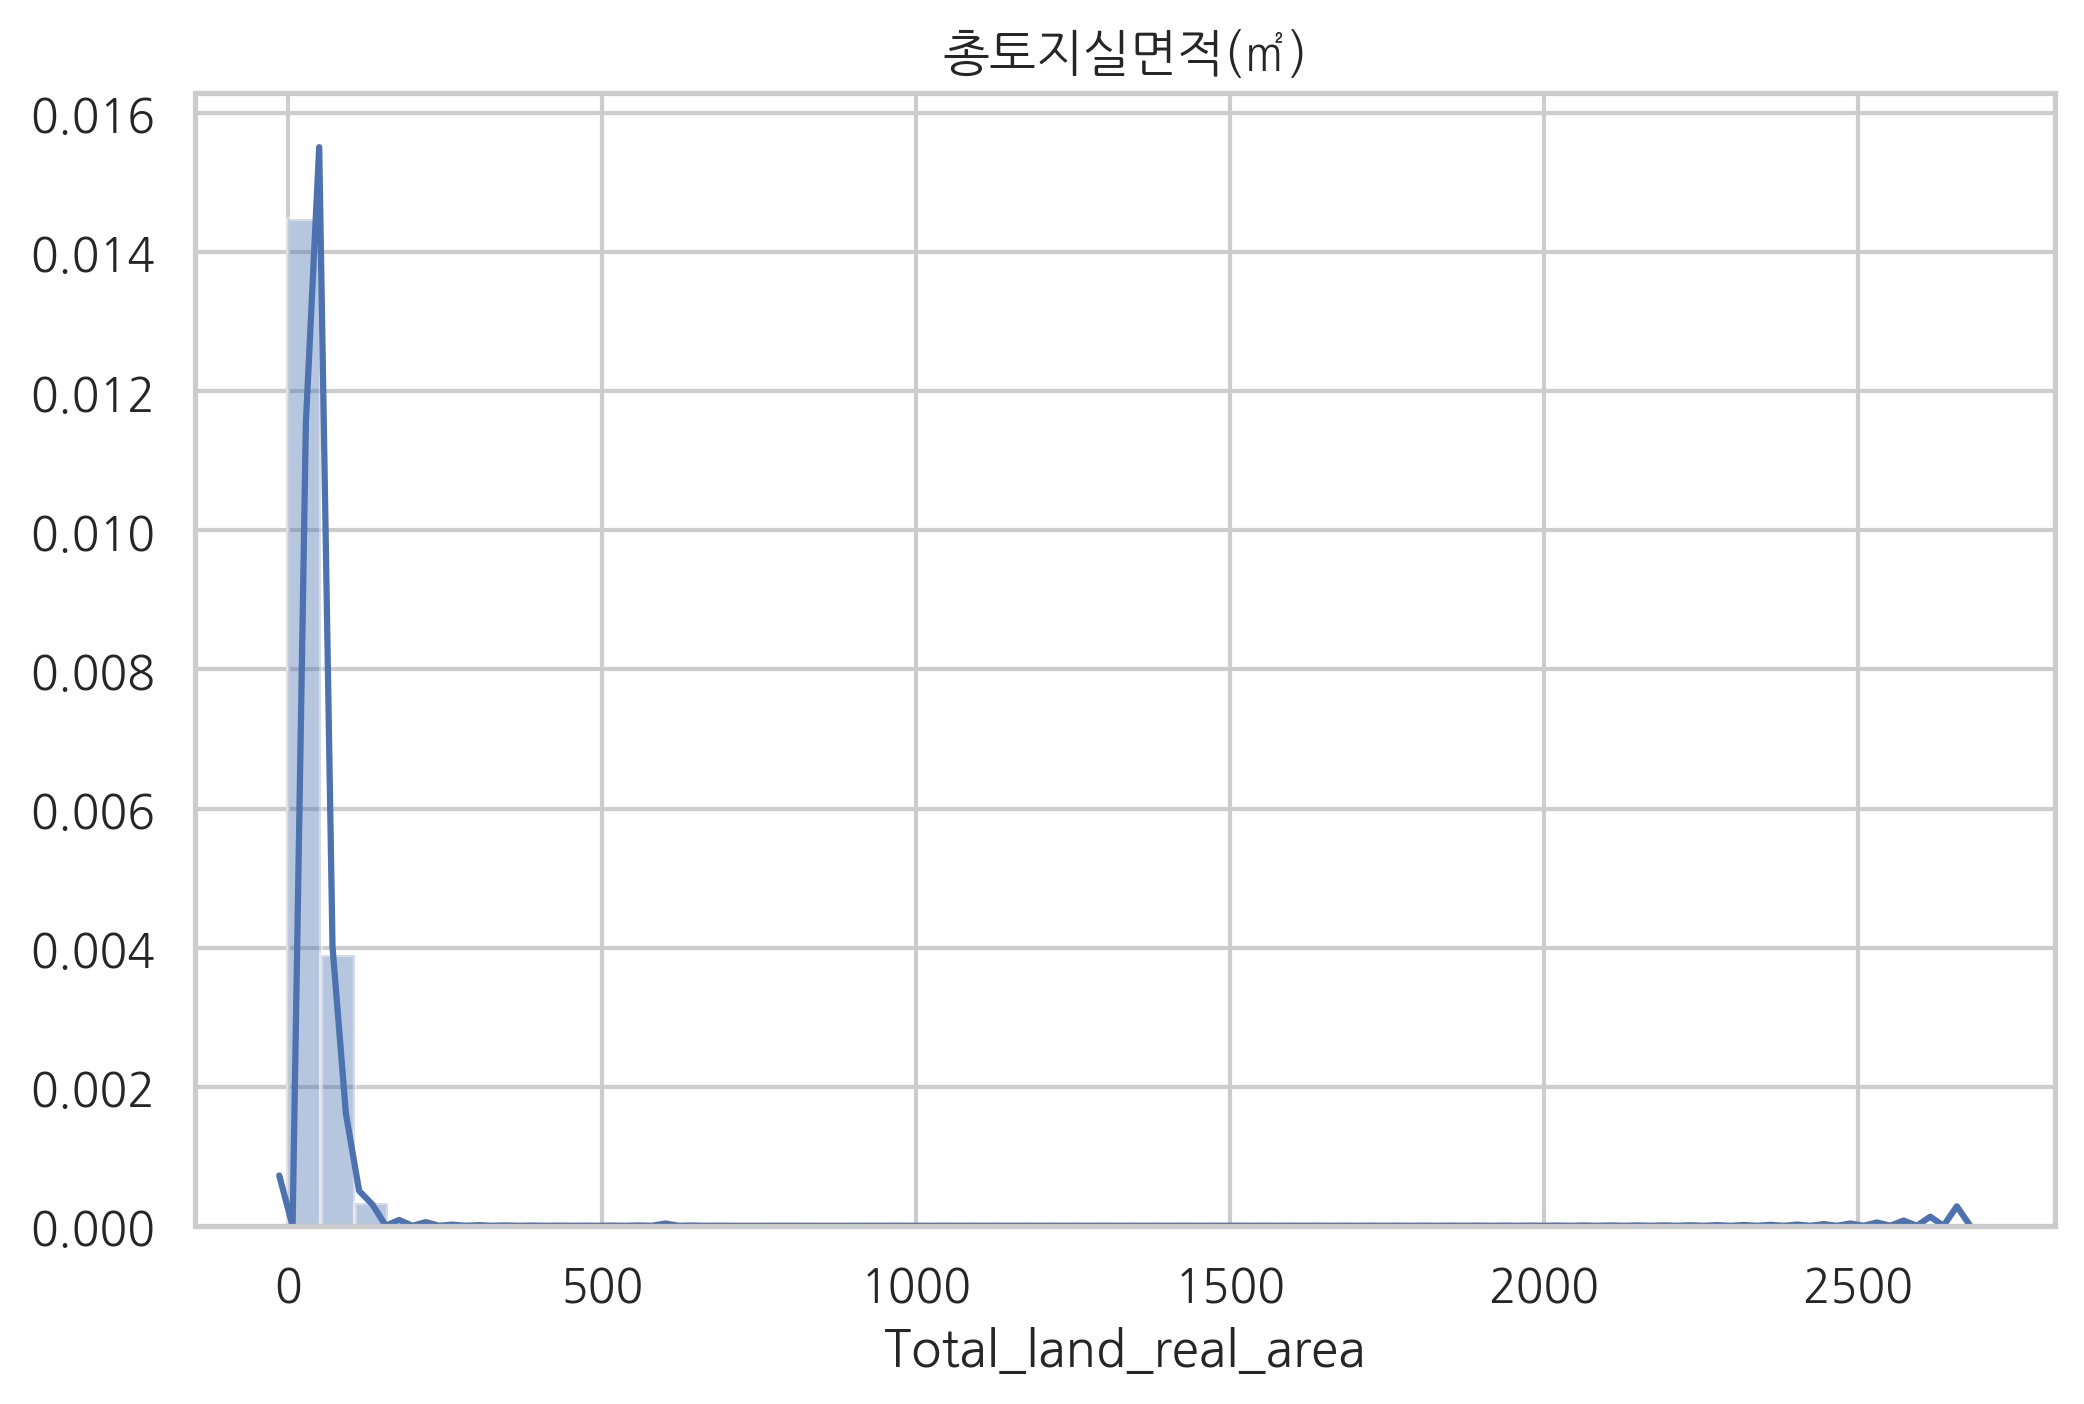

In [21]:
#Total_land_real_area
sns.distplot(train.Total_land_real_area)
plt.title("총토지실면적(㎡)")
plt.show()

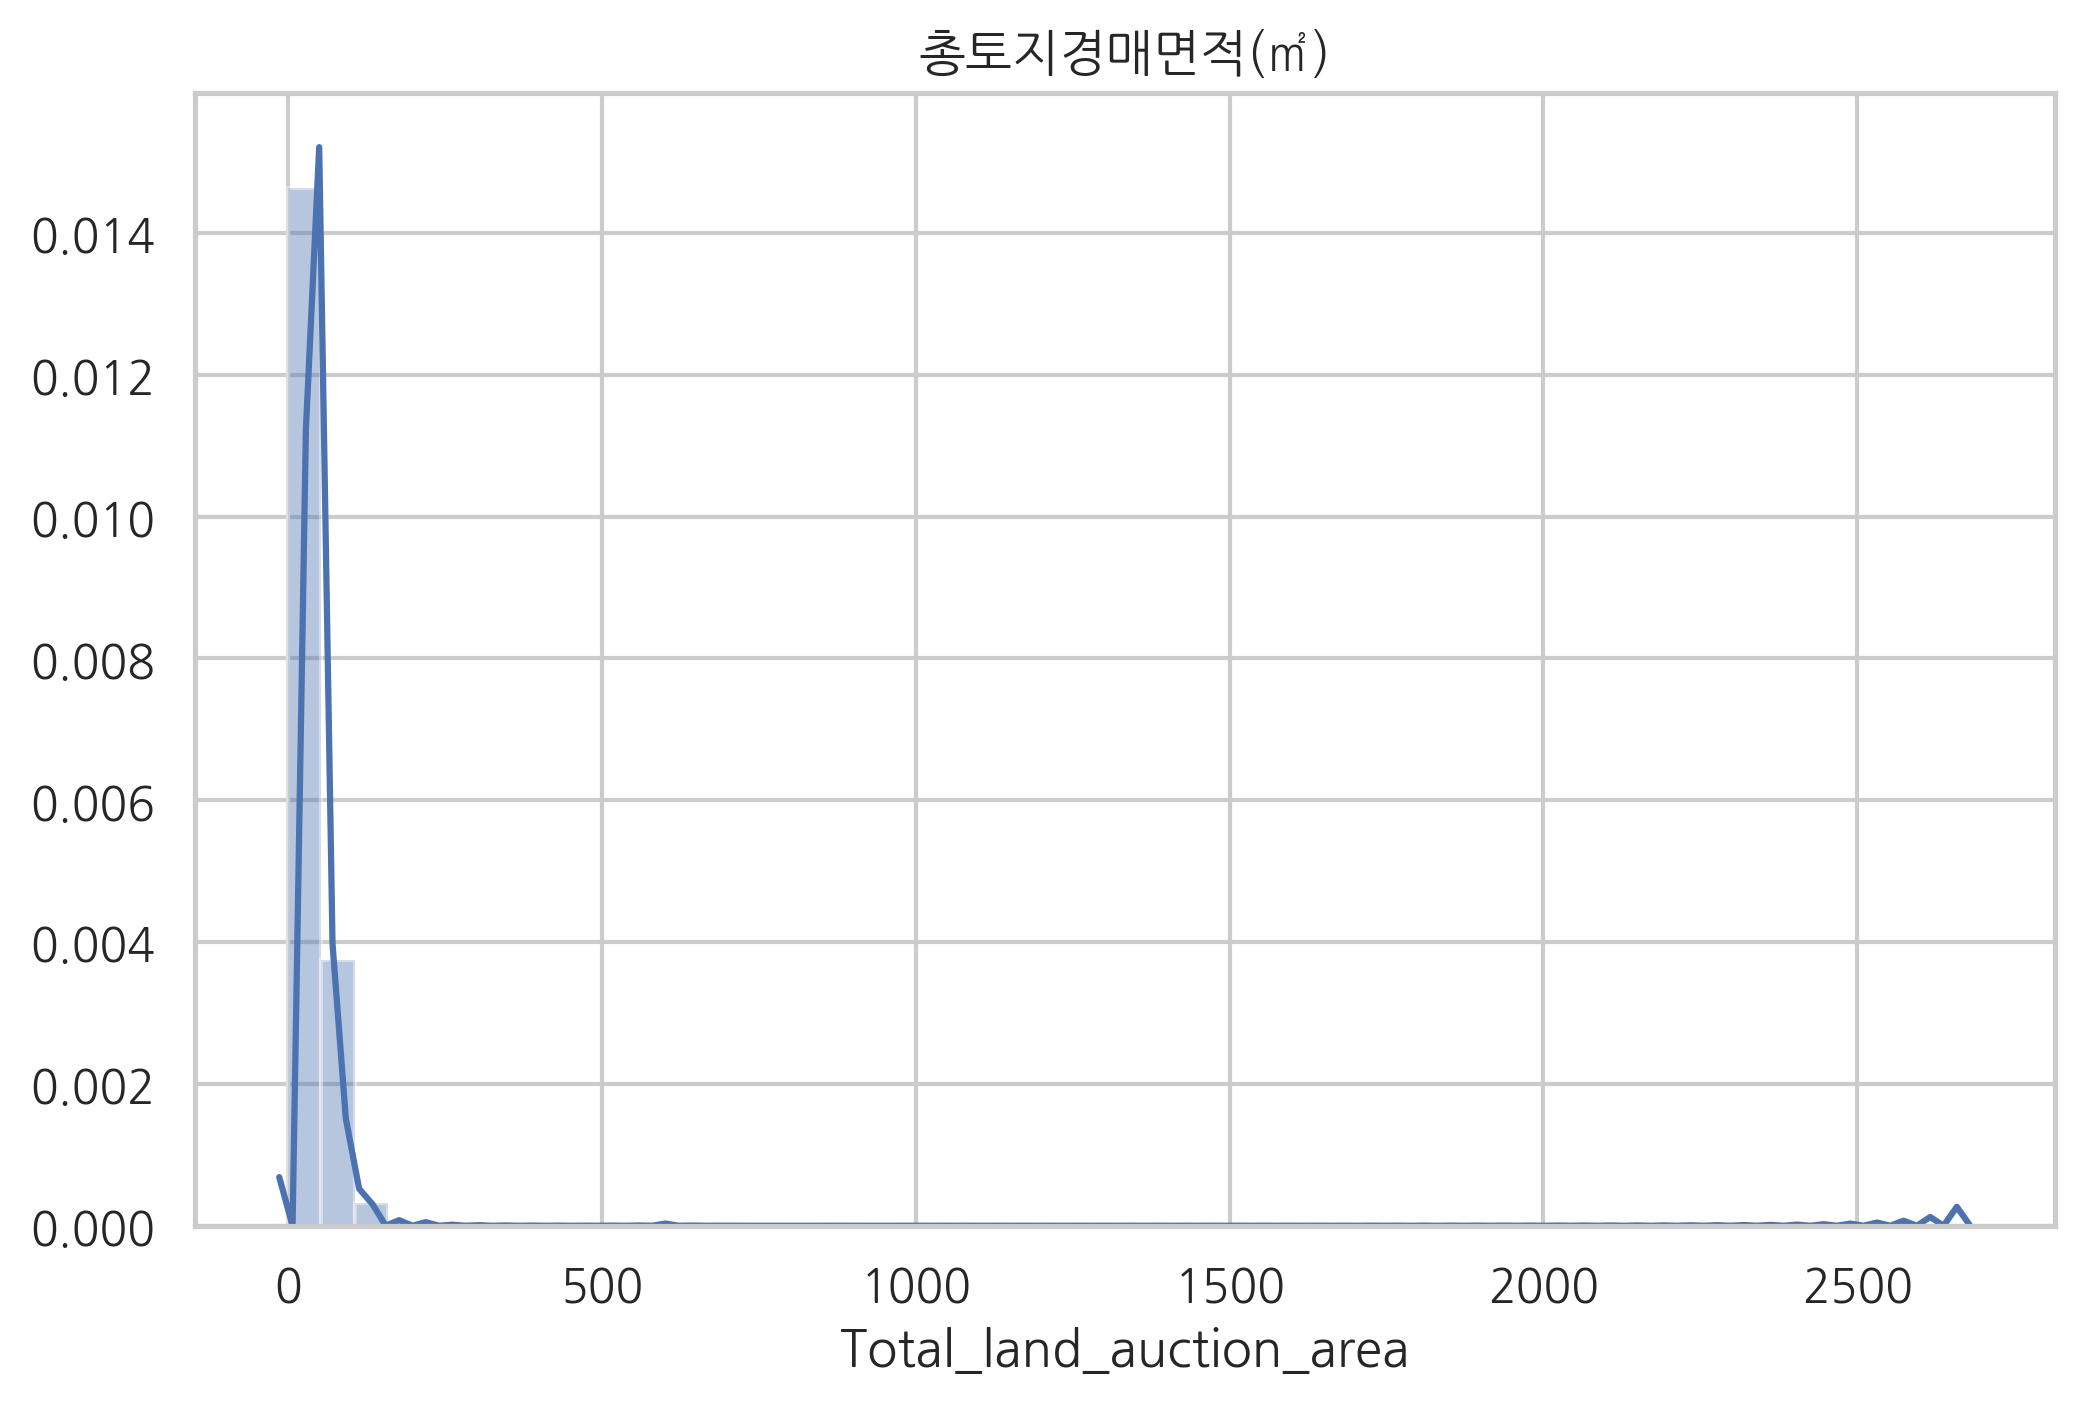

In [22]:
# Total_land_auction_area
sns.distplot(train.Total_land_auction_area)
plt.title("총토지경매면적(㎡)")
plt.show()

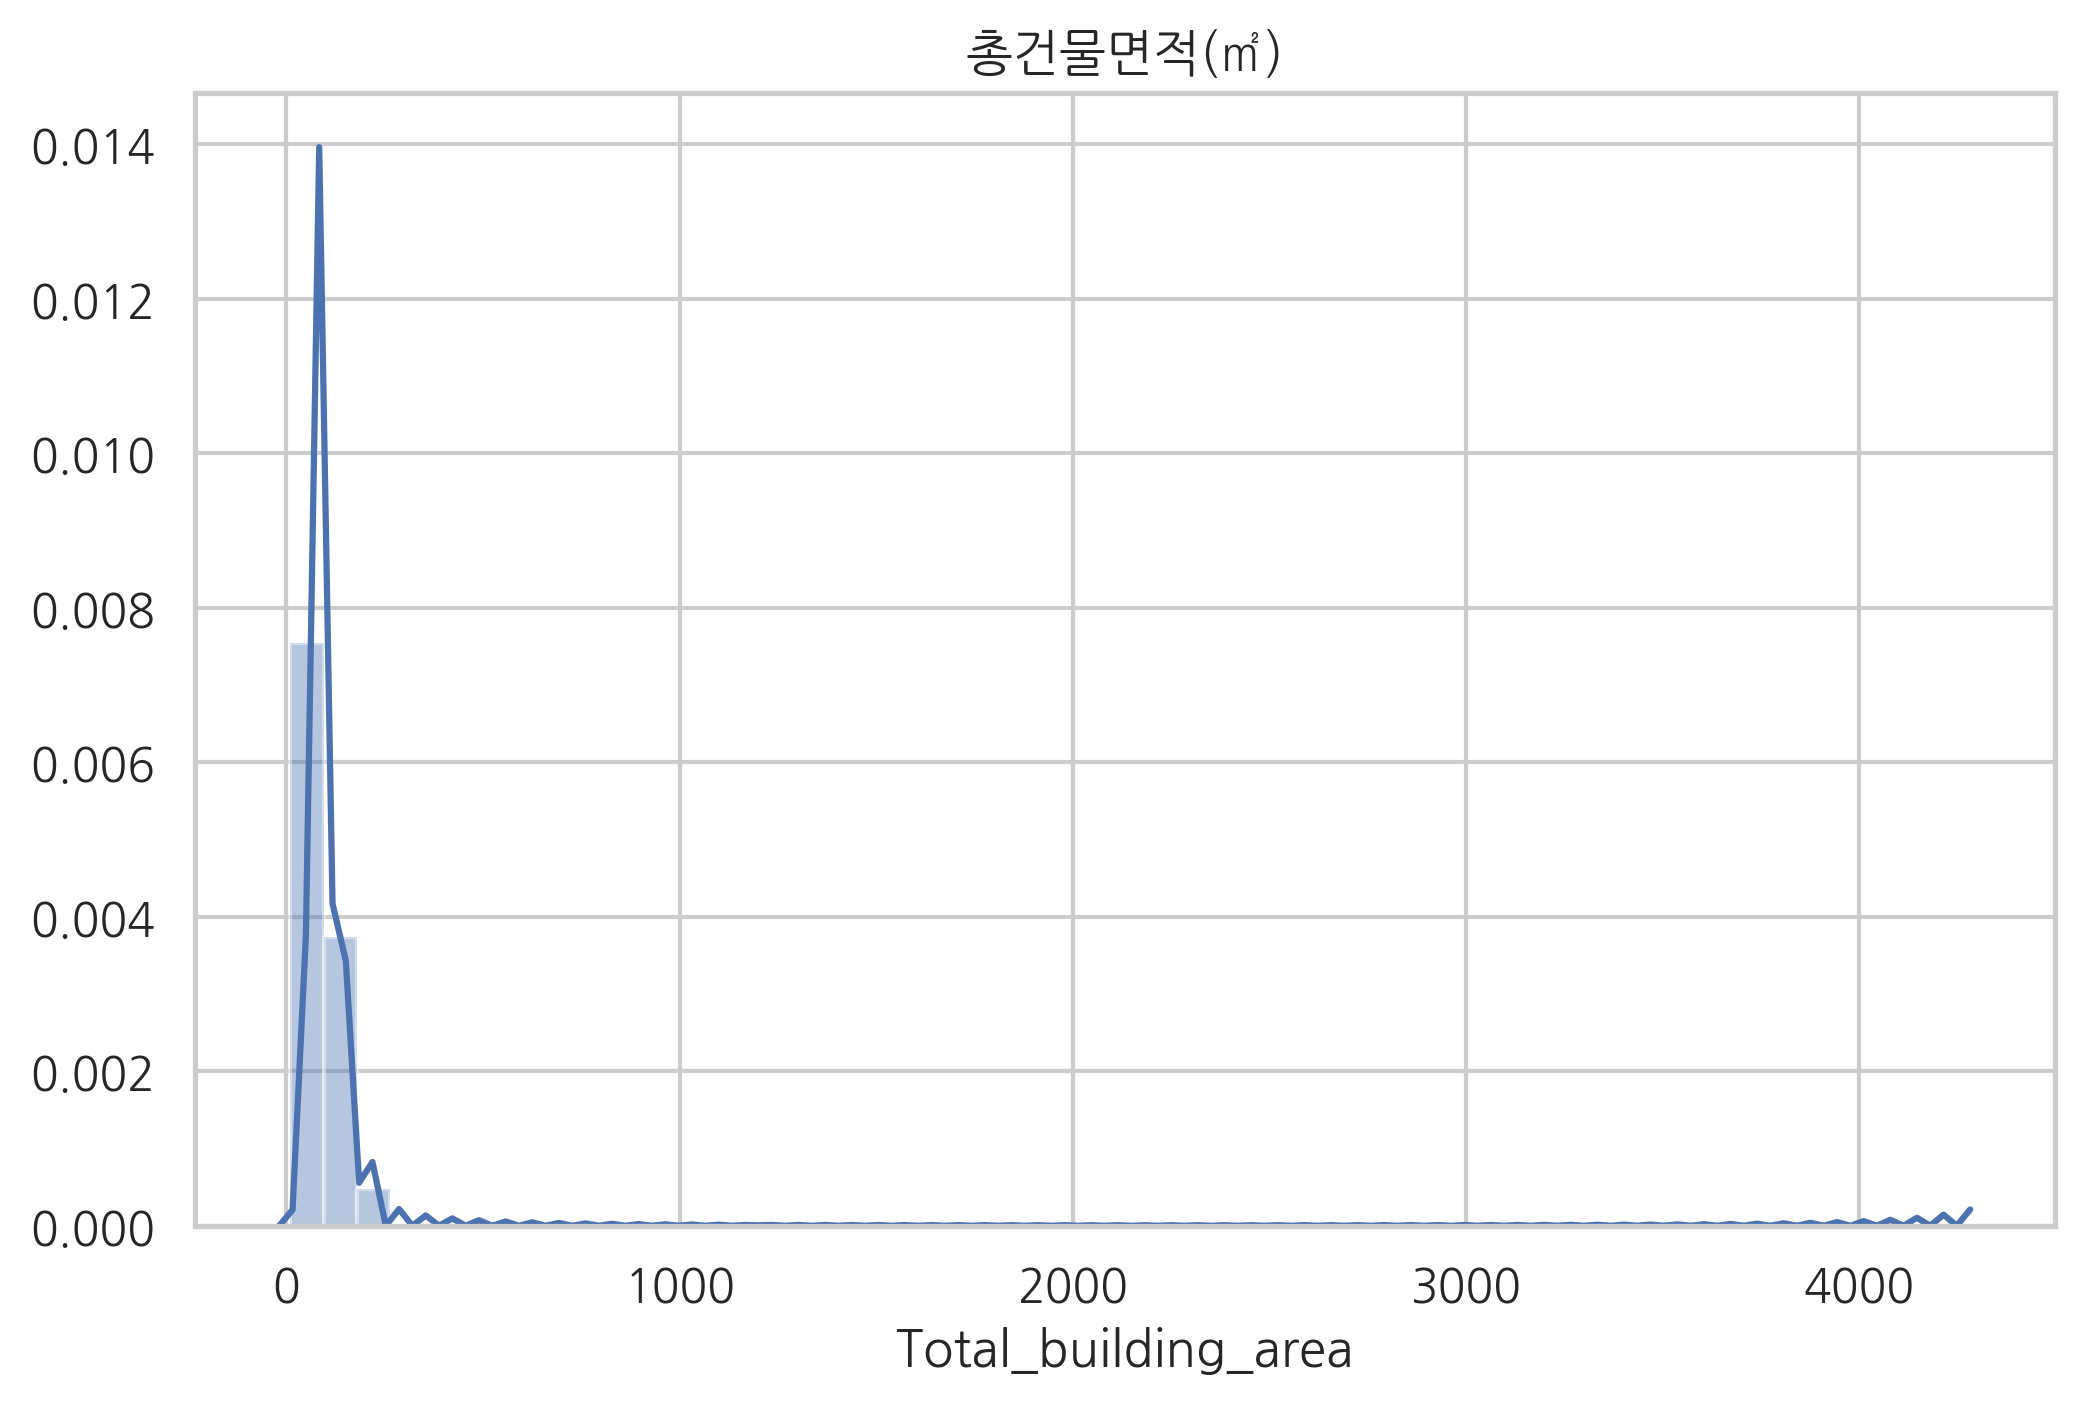

In [24]:
# Total_building_area
sns.distplot(train.Total_building_area)
plt.title("총건물면적(㎡)")
plt.show()

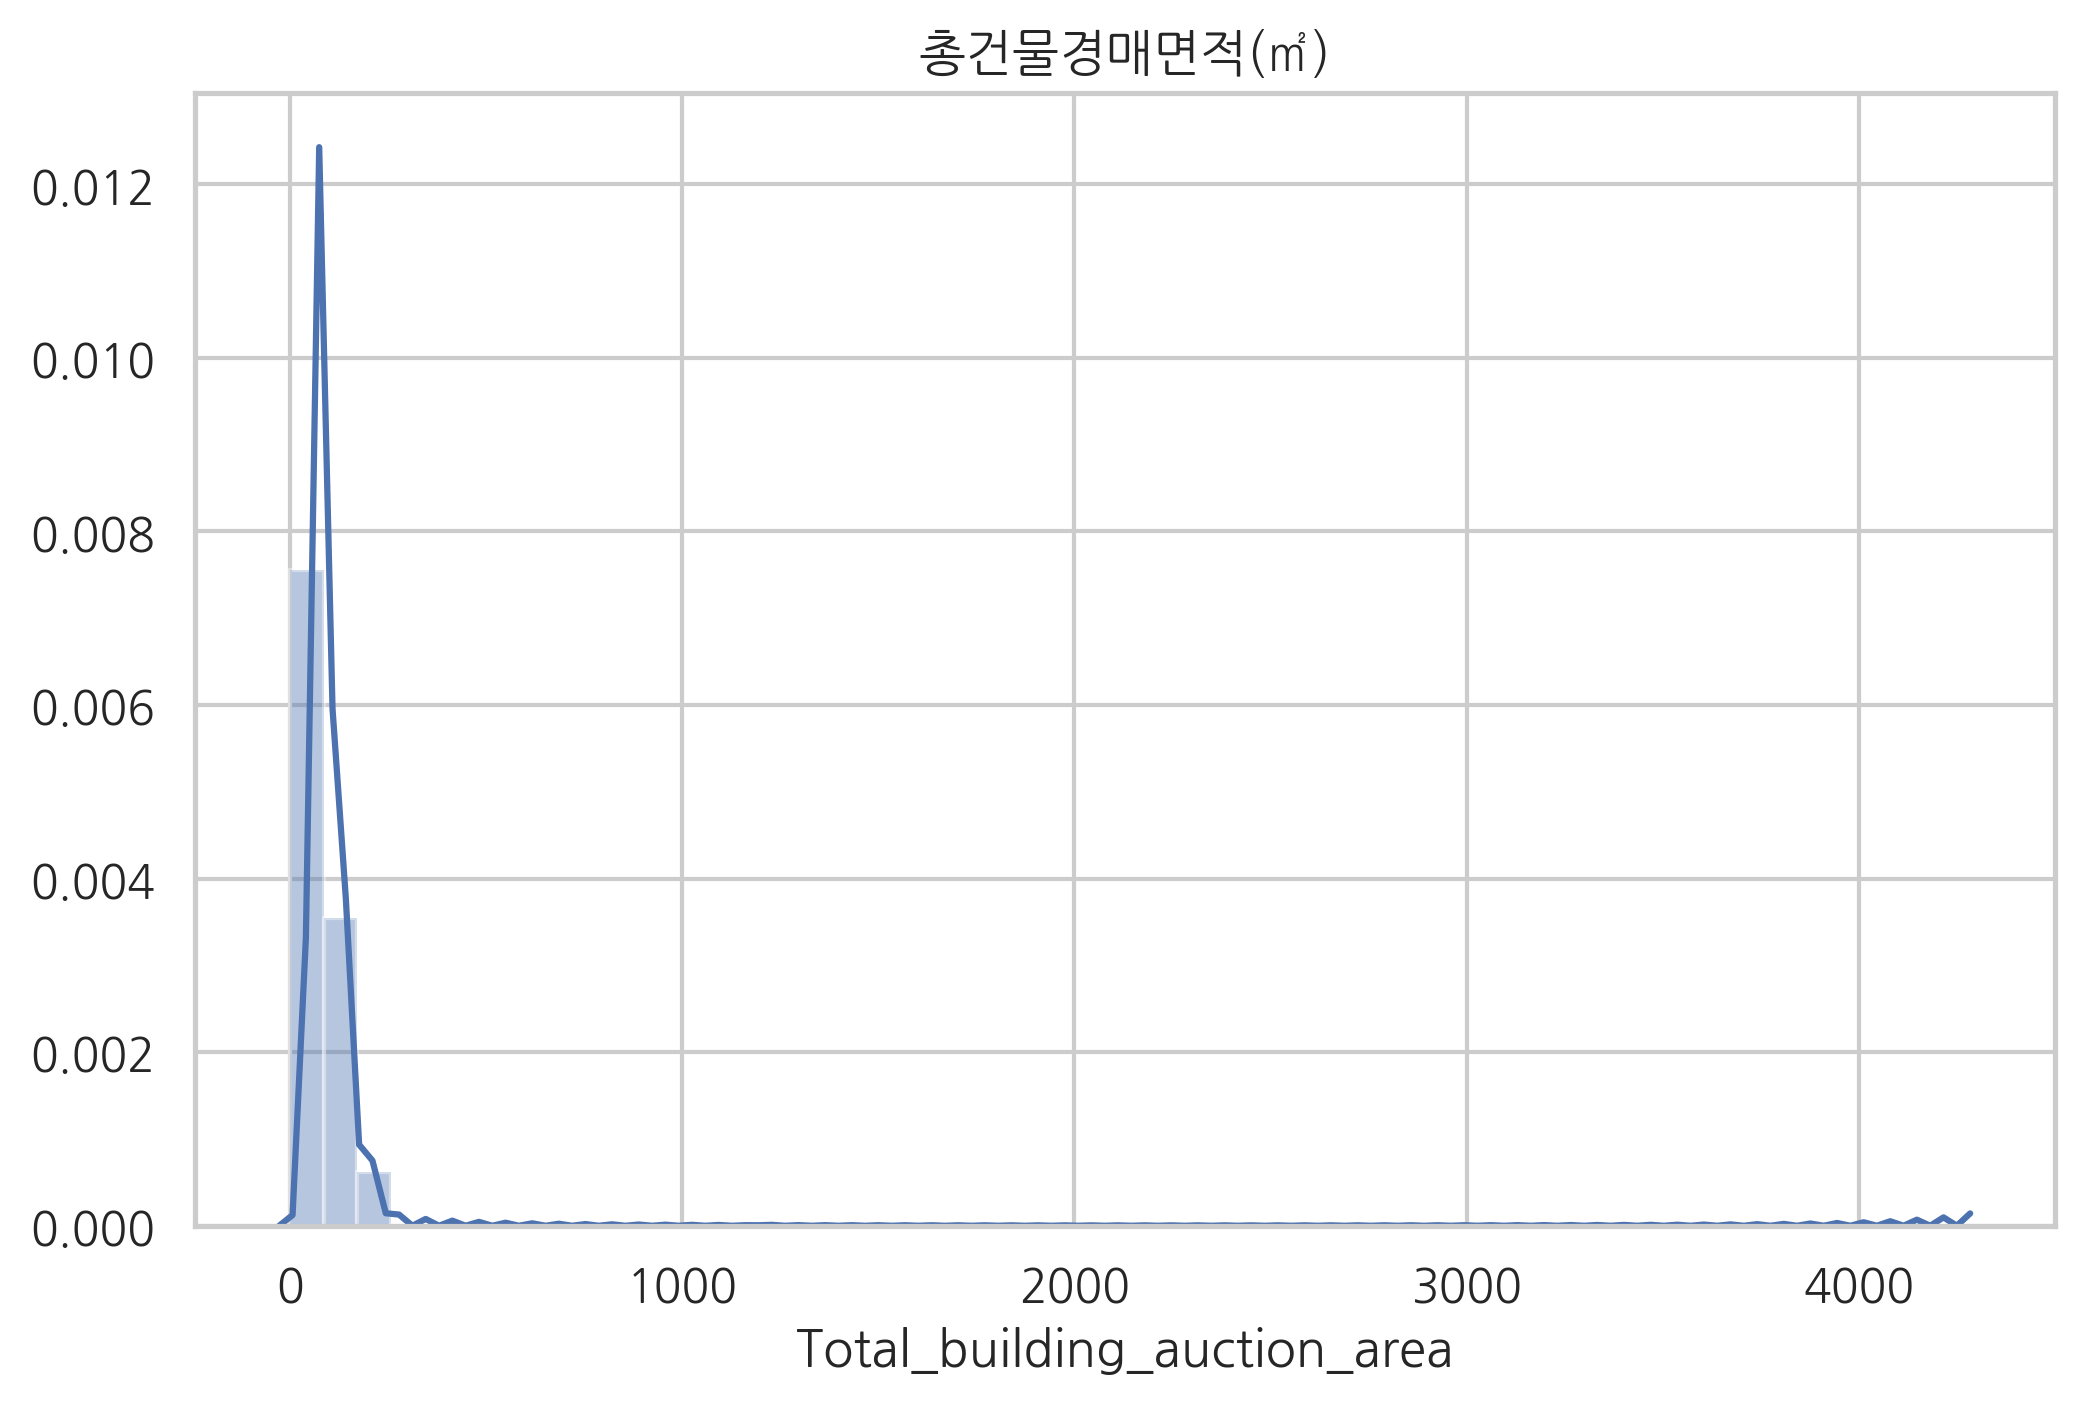

In [25]:
#Total_building_auction_area
sns.distplot(train.Total_building_auction_area)
plt.title("총건물경매면적(㎡)")
plt.show()

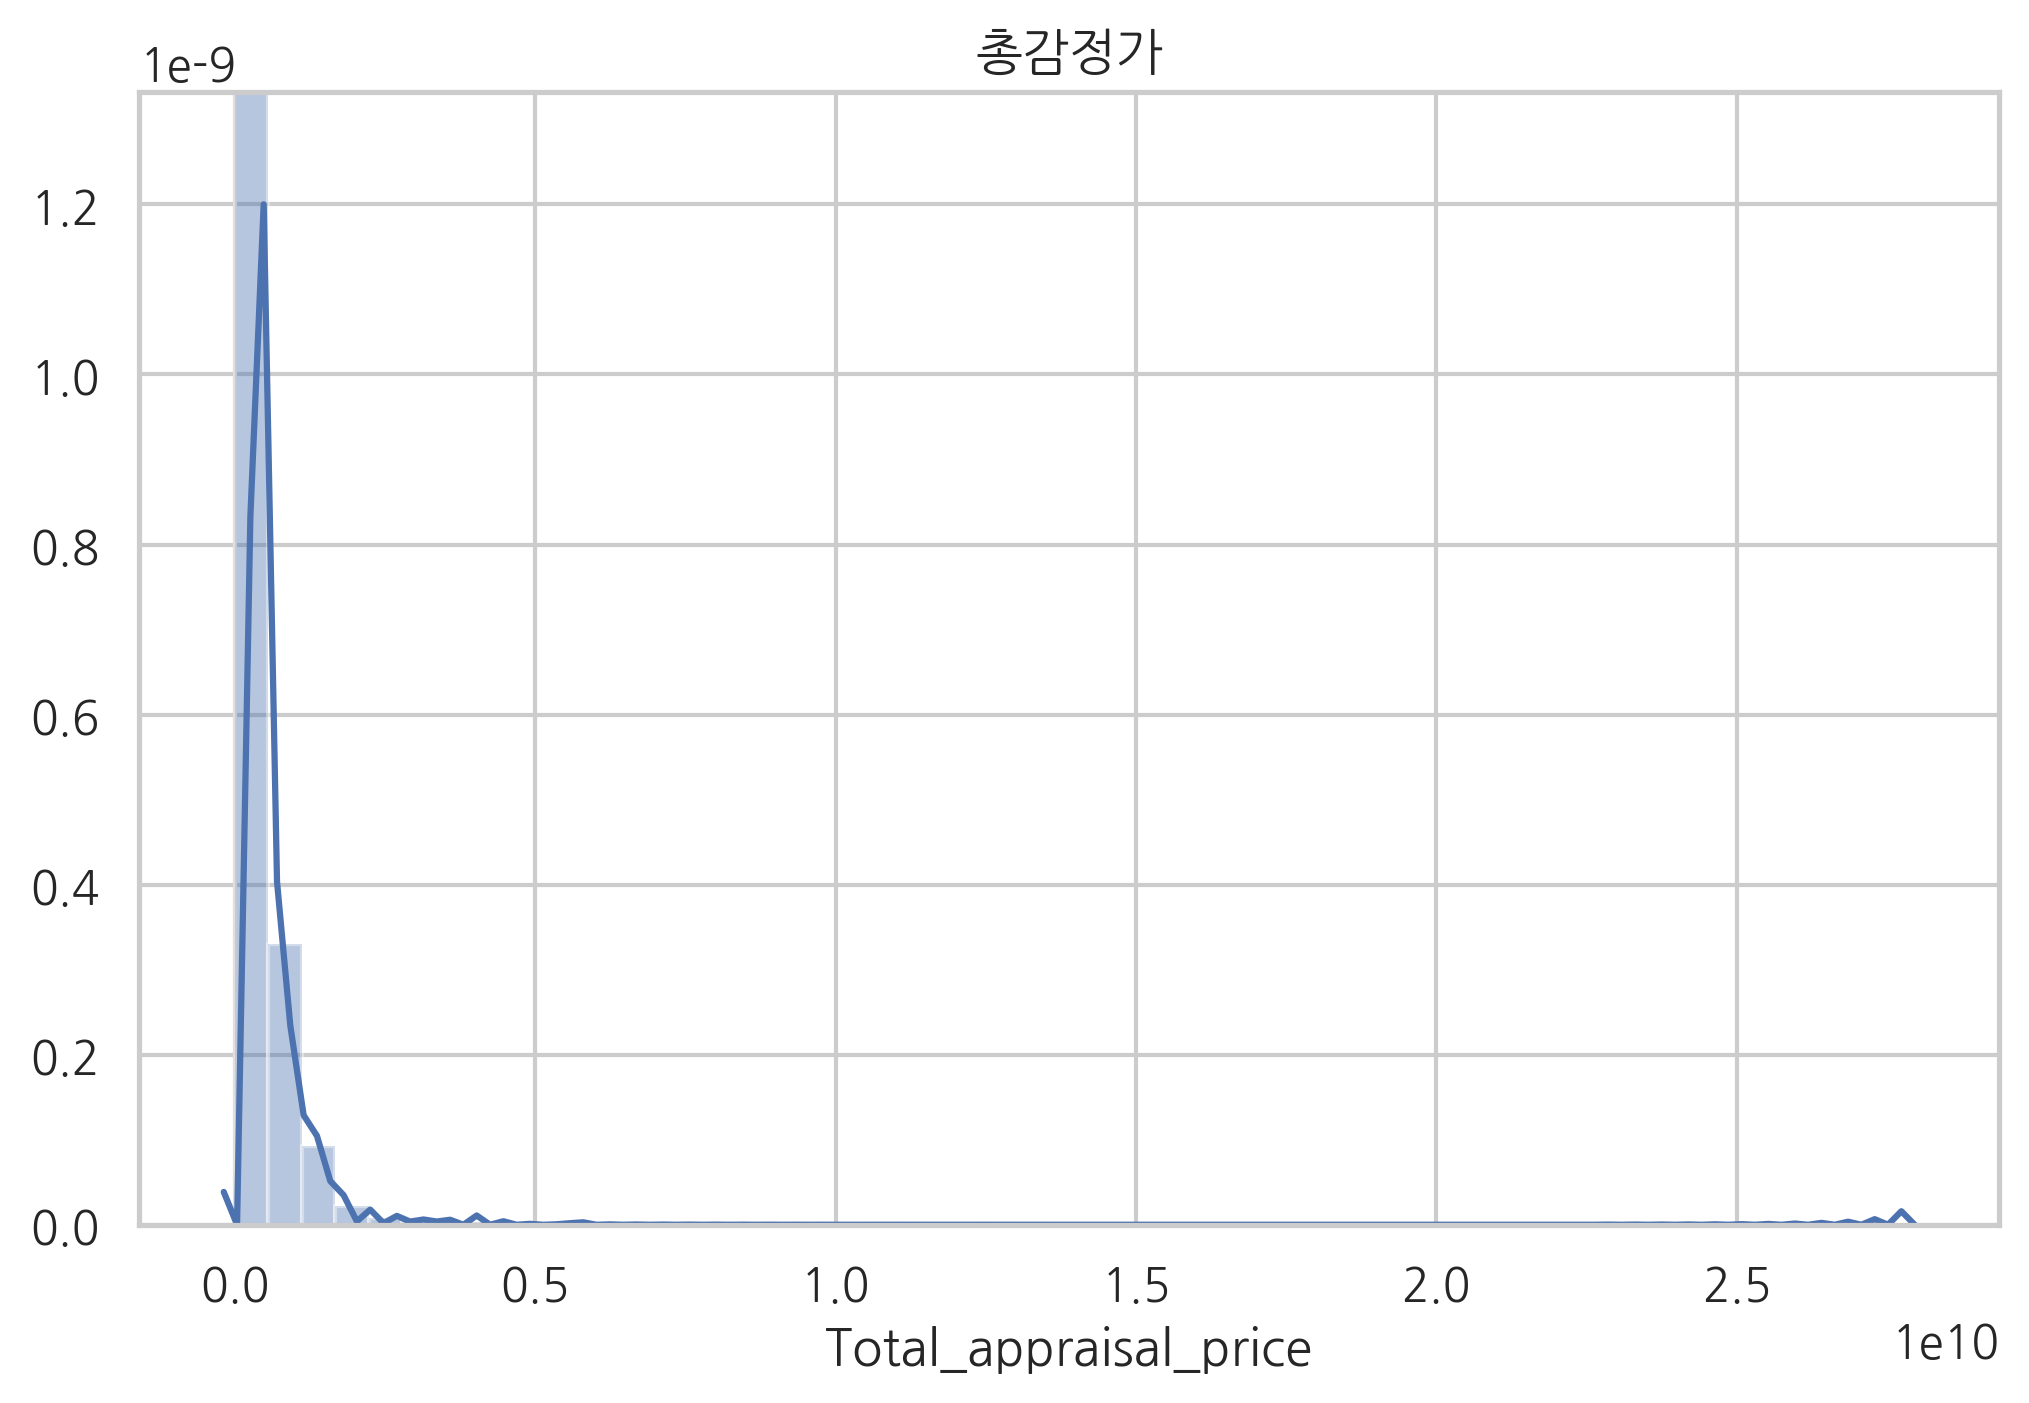

In [26]:
#Total_appraisal_price
sns.distplot(train.Total_appraisal_price)
plt.title("총감정가")
plt.show()

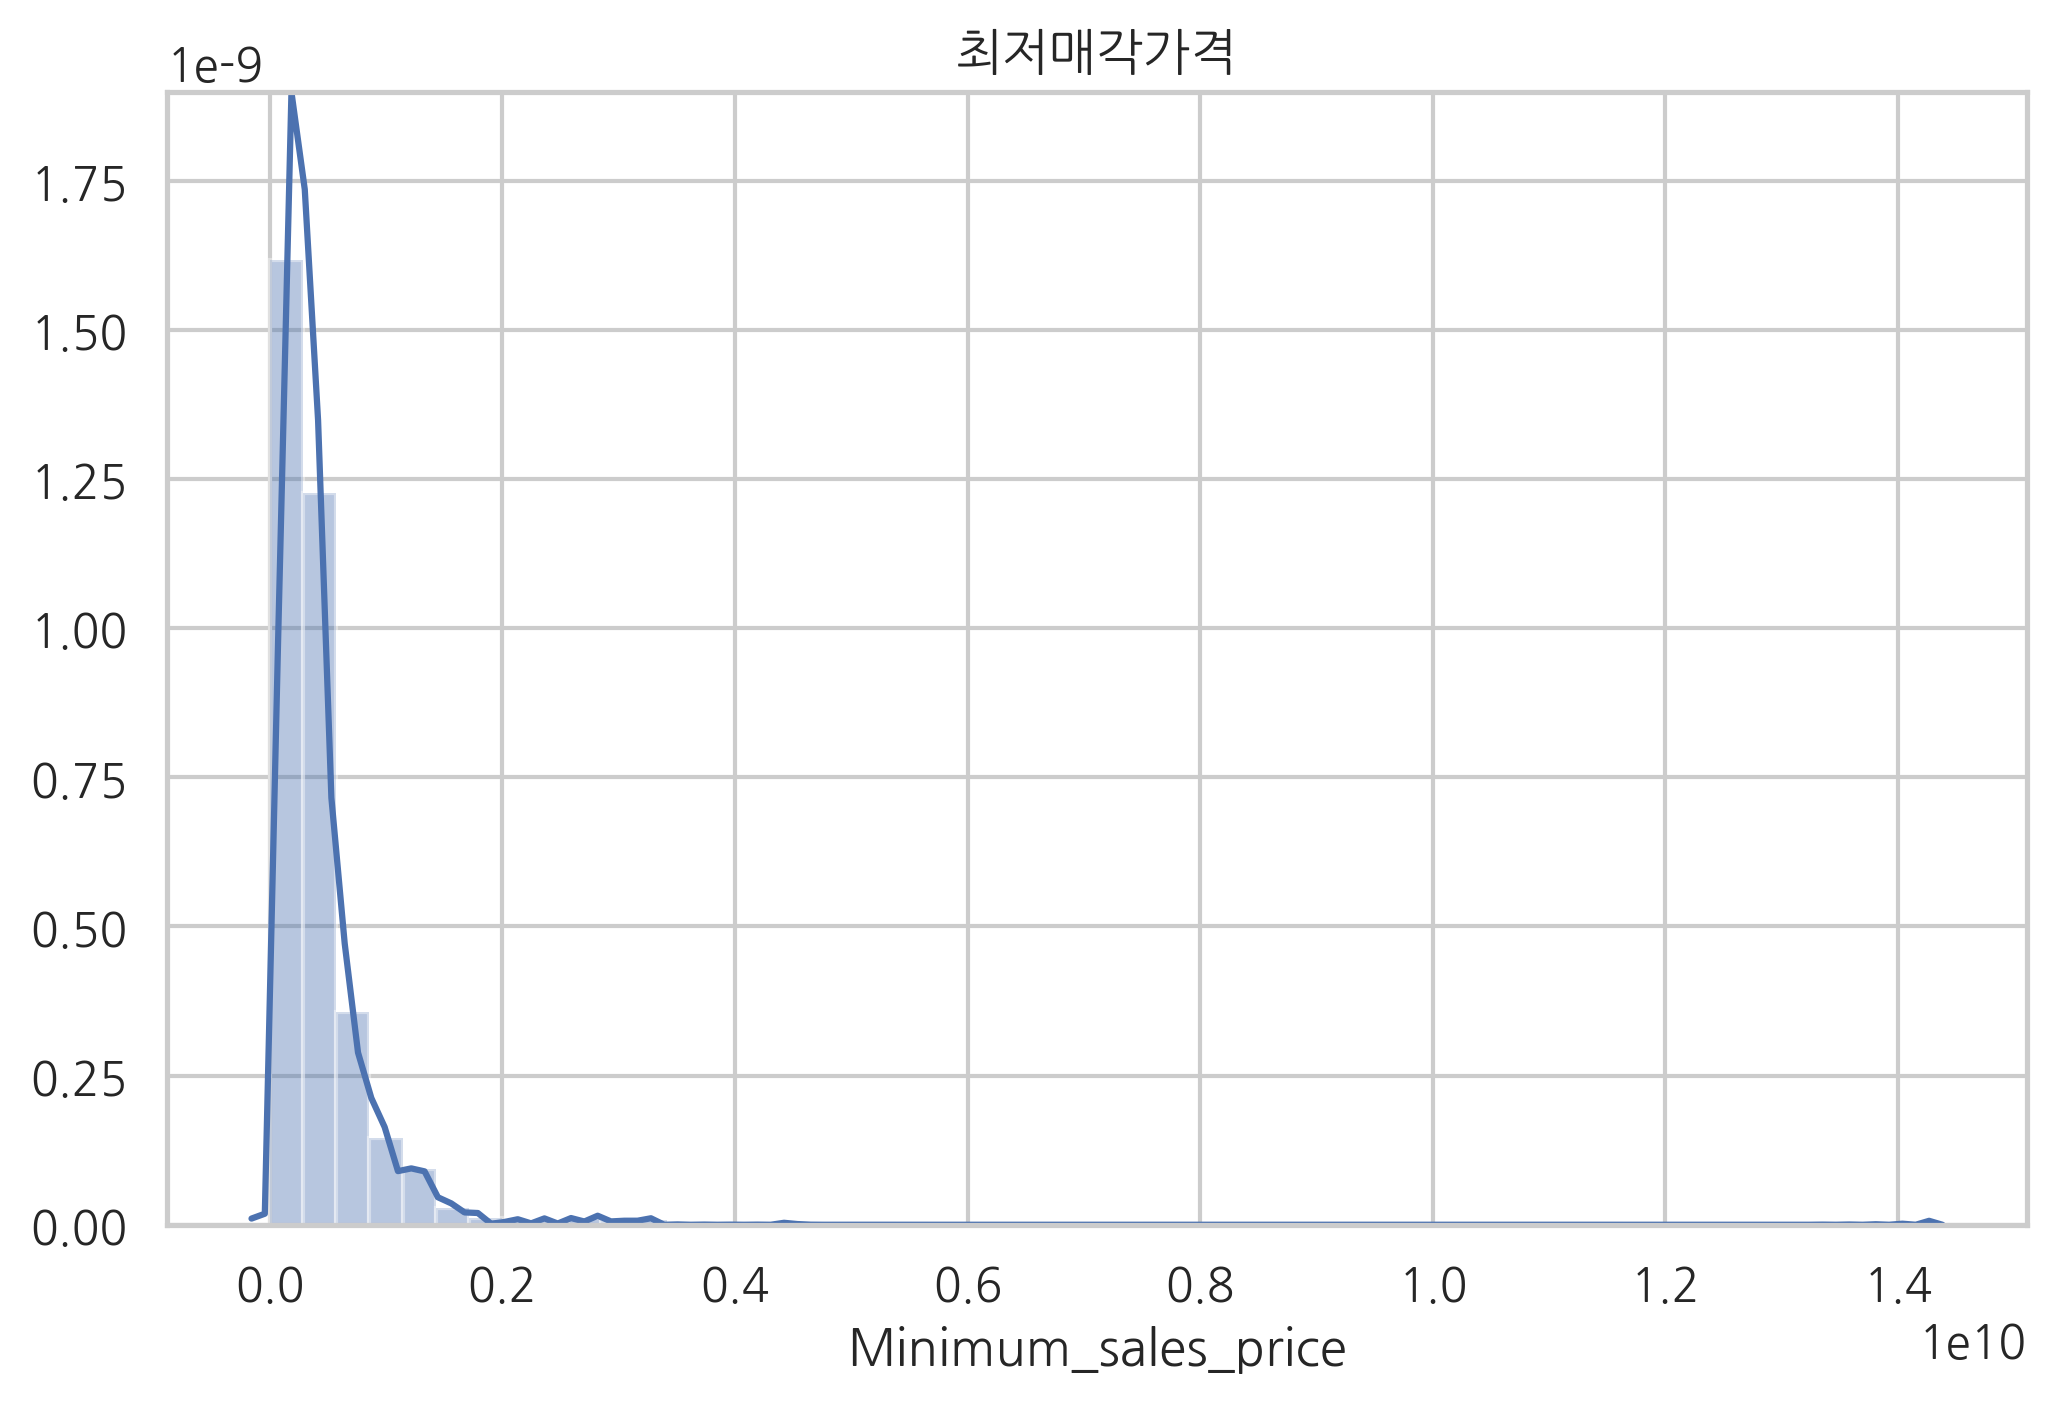

In [27]:
#Minimum_sales_price
sns.distplot(train.Minimum_sales_price)
plt.title("최저매각가격")
plt.show()

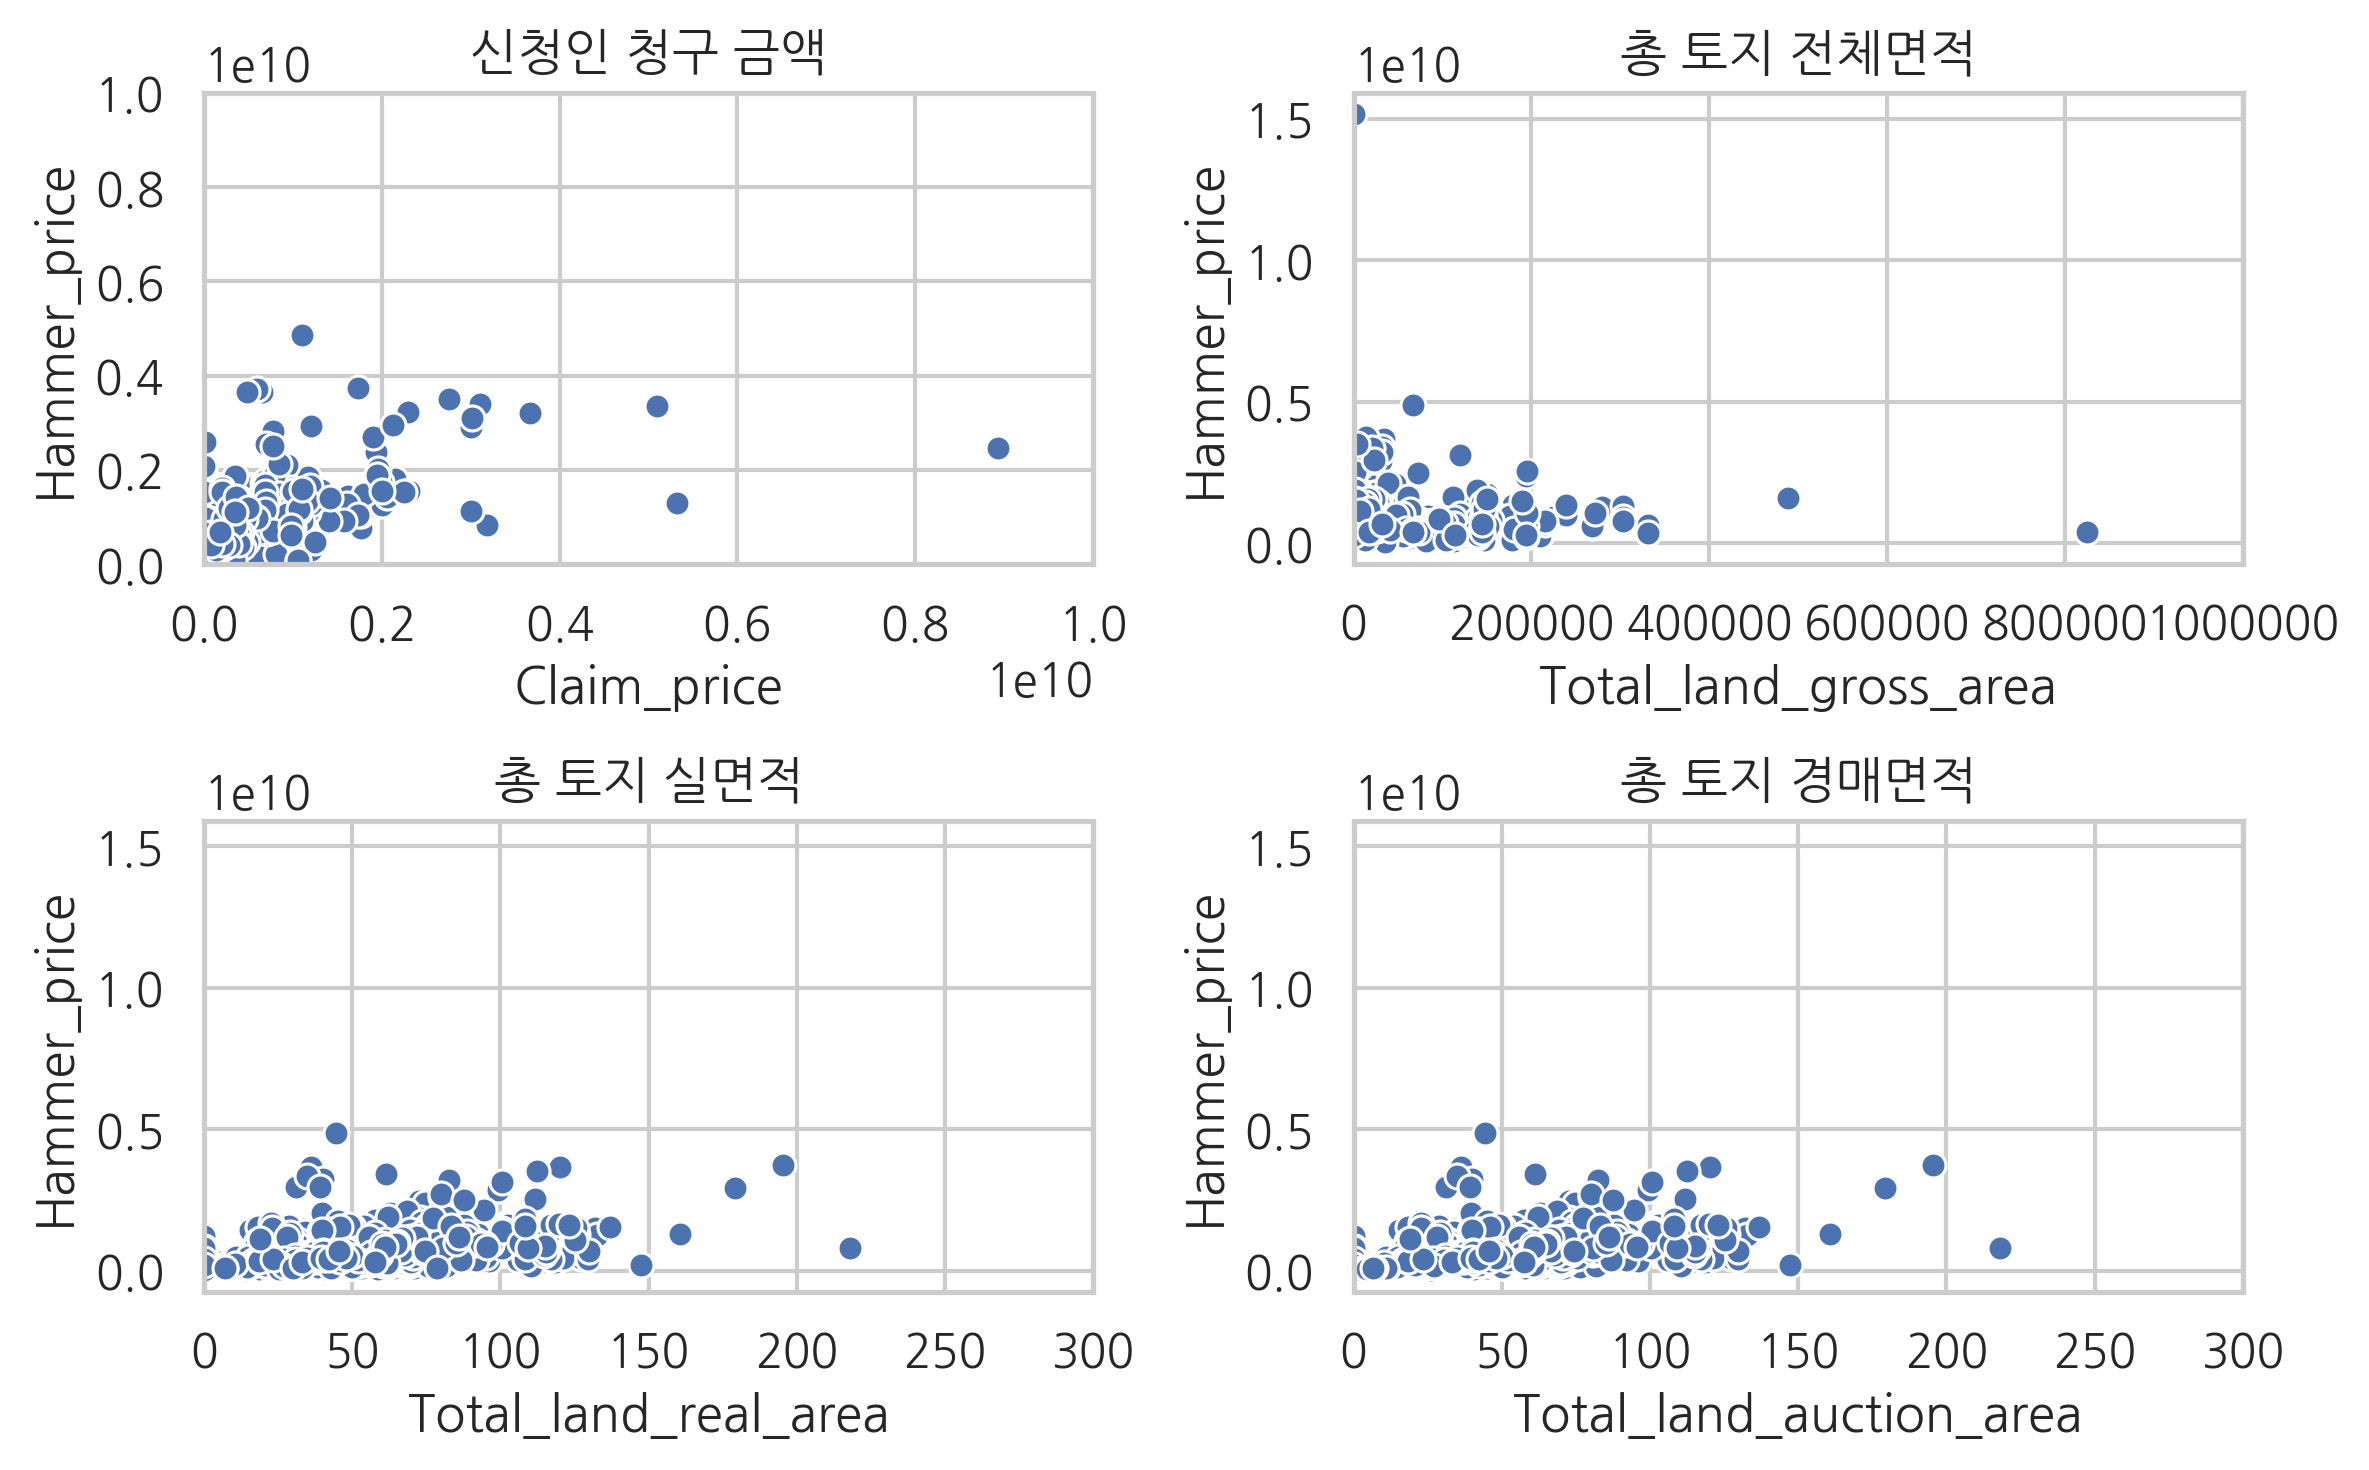

In [52]:
plt.subplot(221)
sns.scatterplot(train.Claim_price, train.Hammer_price)
plt.xlim(0, 1*1e10)
plt.ylim(0, 1*1e10)
plt.title('신청인 청구 금액')
plt.subplot(222)
sns.scatterplot(train.Total_land_gross_area, train.Hammer_price)
plt.xlim(0, 1000000)
plt.title('총 토지 전체면적')
plt.subplot(223)
sns.scatterplot(train.Total_land_real_area, train.Hammer_price)
plt.xlim(0, 300)
plt.title('총 토지 실면적')
plt.subplot(224)
sns.scatterplot(train.Total_land_auction_area, train.Hammer_price)
plt.xlim(0, 300)

plt.title('총 토지 경매면적')

plt.tight_layout()
plt.show()

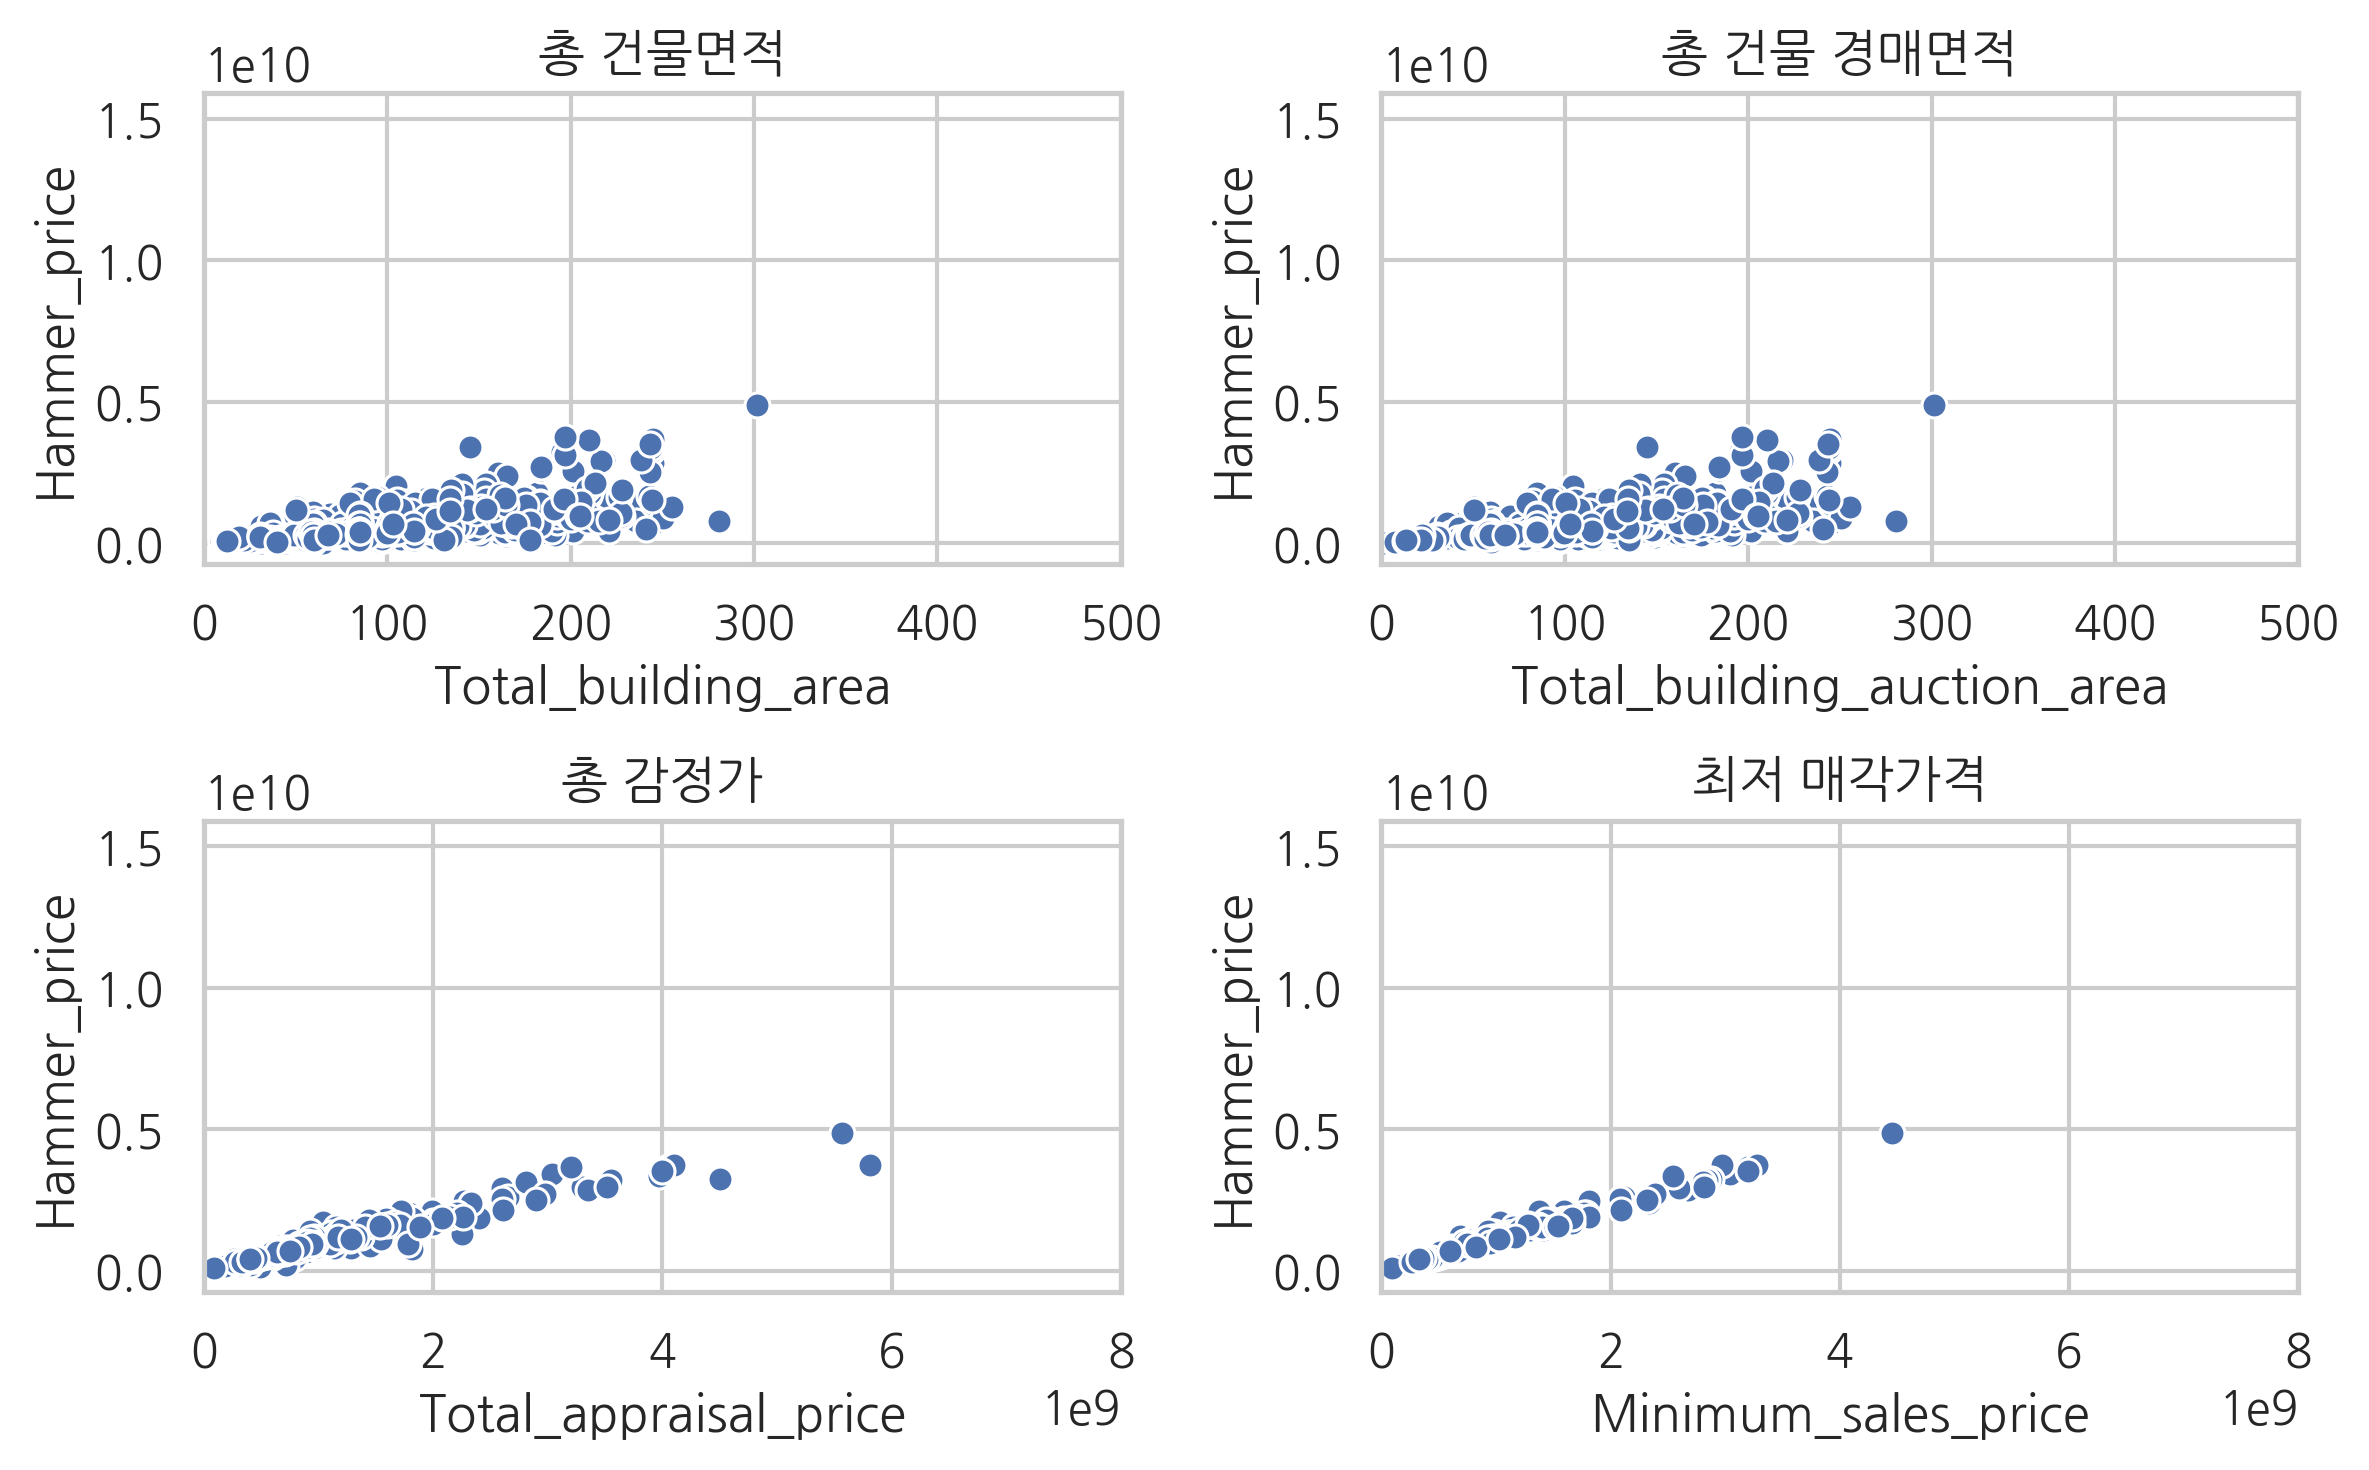

In [59]:
plt.subplot(221)
sns.scatterplot(train.Total_building_area, train.Hammer_price)
plt.xlim(0, 500)
plt.title('총 건물면적')
plt.subplot(222)
sns.scatterplot(train.Total_building_auction_area, train.Hammer_price)
plt.xlim(0, 500)
plt.title('총 건물 경매면적')
plt.subplot(223)
sns.scatterplot(train.Total_appraisal_price, train.Hammer_price)
plt.xlim(0, 8000000000)
plt.title('총 감정가')
plt.subplot(224)
sns.scatterplot(train.Minimum_sales_price, train.Hammer_price)
plt.xlim(0, 8000000000)
plt.title('최저 매각가격')

plt.tight_layout()
plt.show()

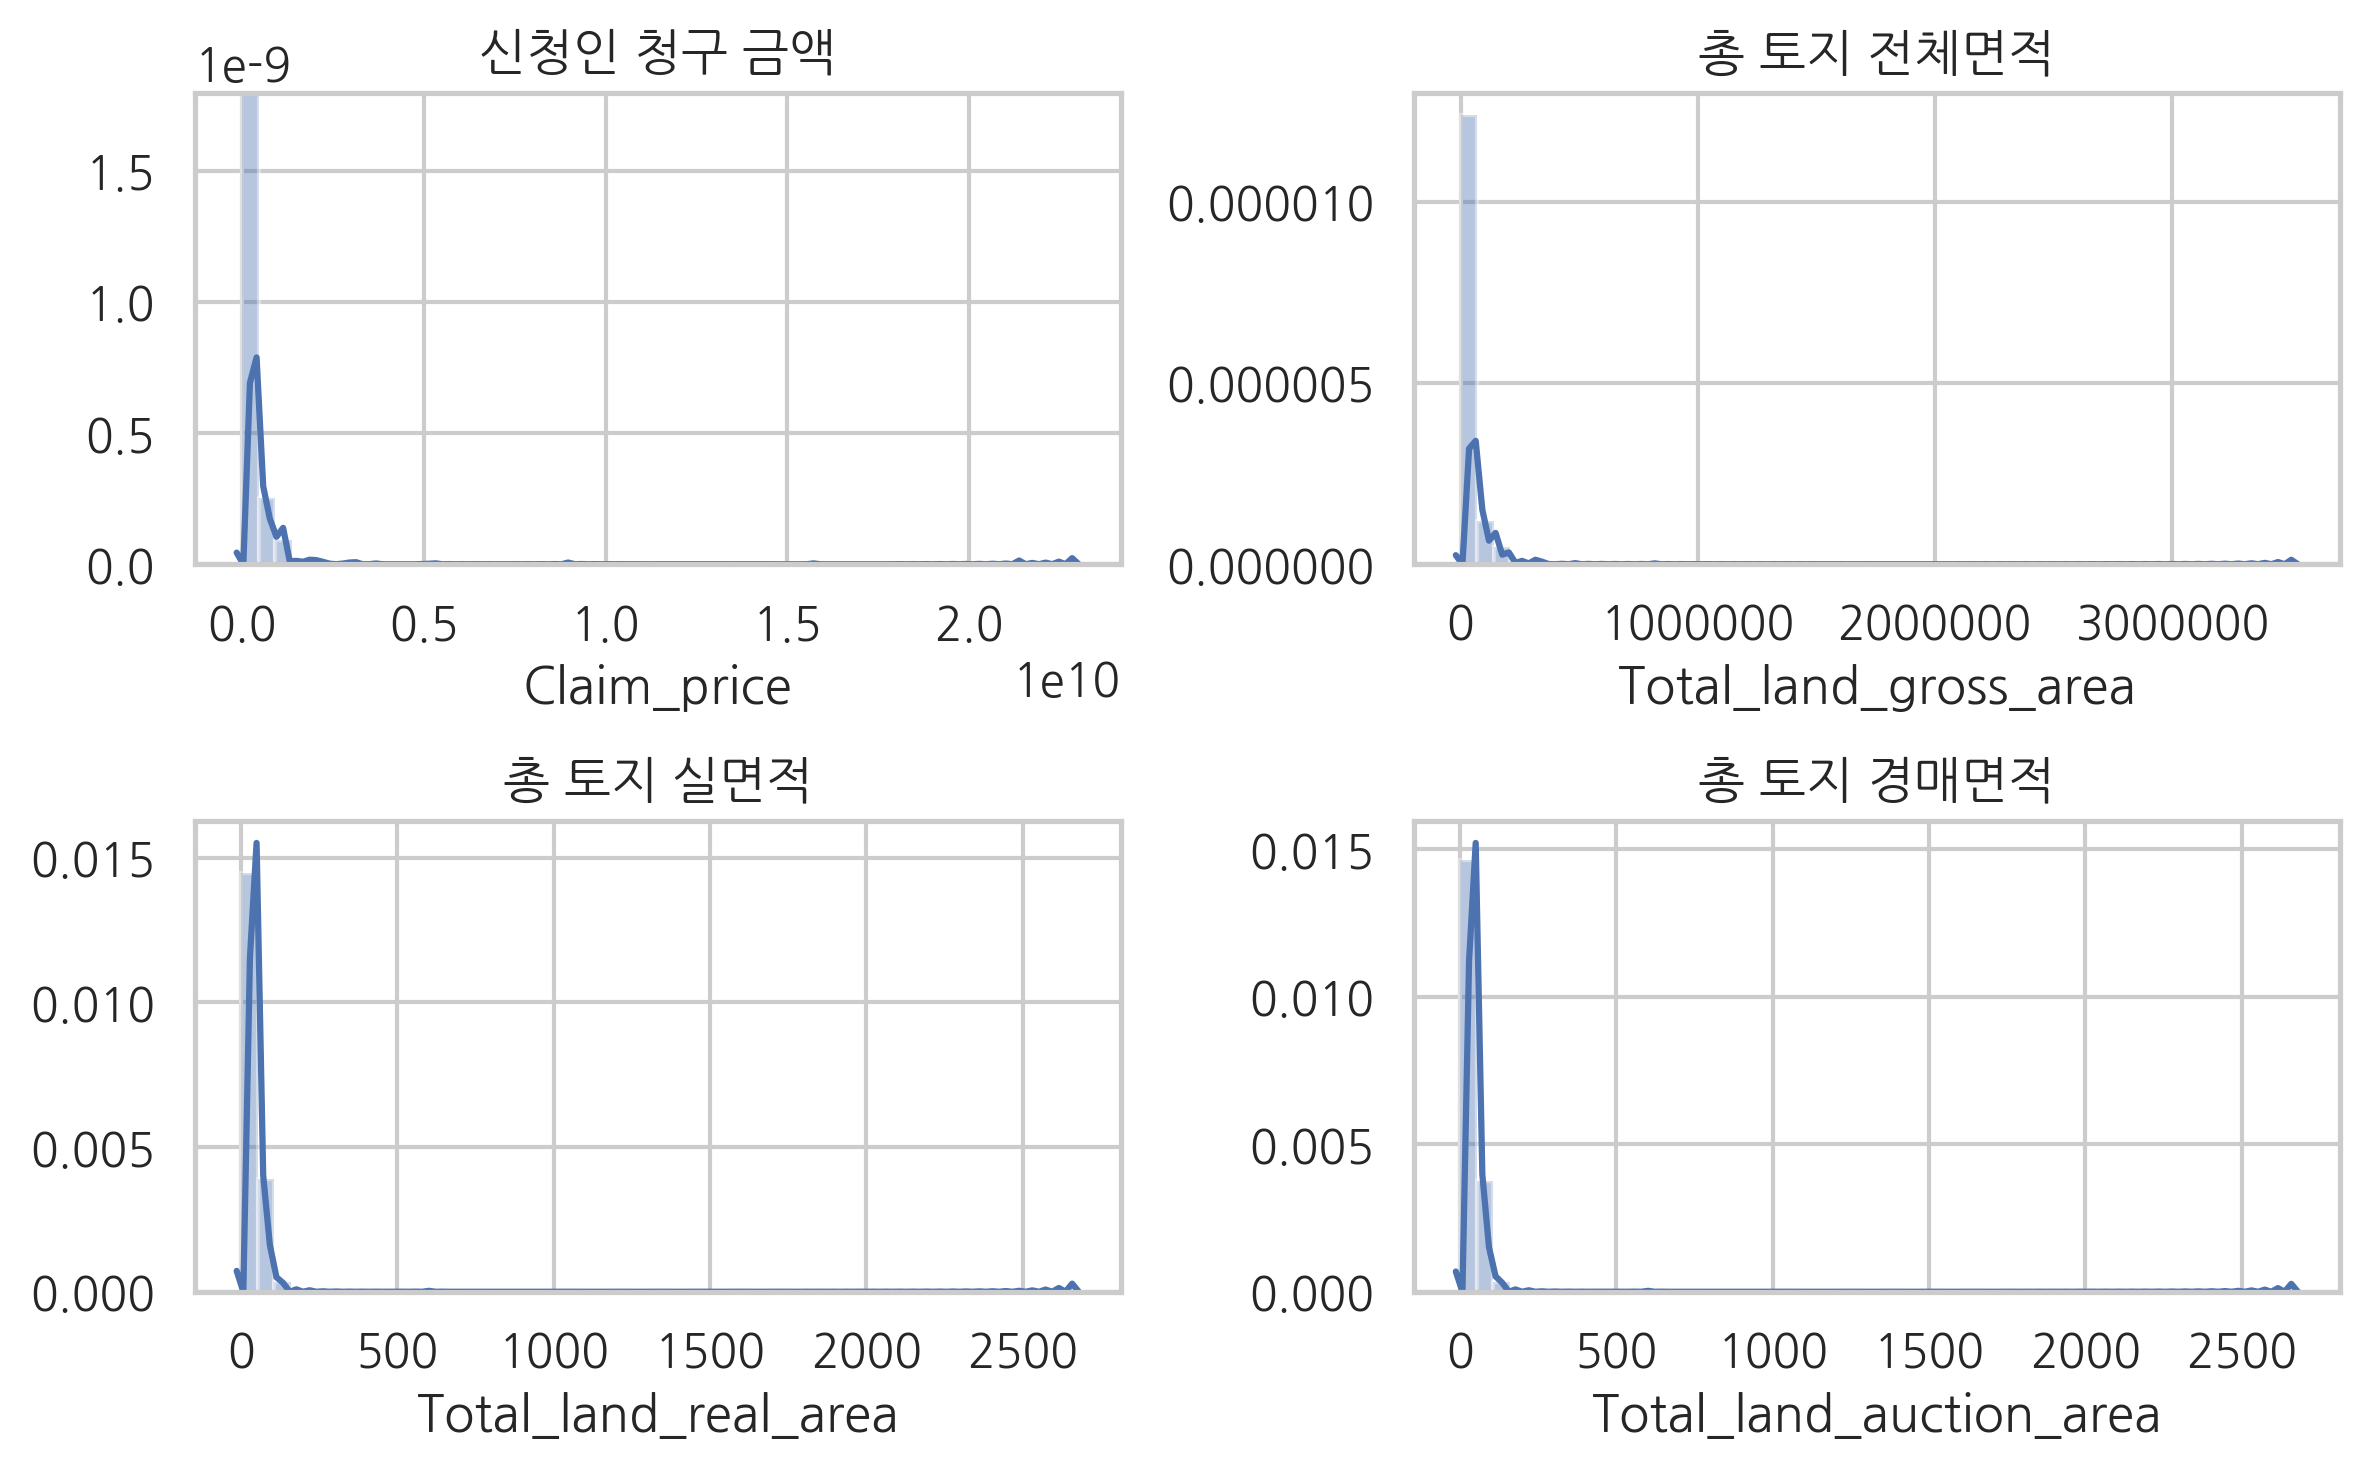

In [69]:
plt.subplot(221)
sns.distplot(train.Claim_price)
plt.title('신청인 청구 금액')
plt.subplot(222)
sns.distplot(train.Total_land_gross_area)
plt.title('총 토지 전체면적')
plt.subplot(223)
sns.distplot(train.Total_land_real_area)
plt.title('총 토지 실면적')
plt.subplot(224)
sns.distplot(train.Total_land_auction_area)
plt.title('총 토지 경매면적')

plt.tight_layout()
plt.show()

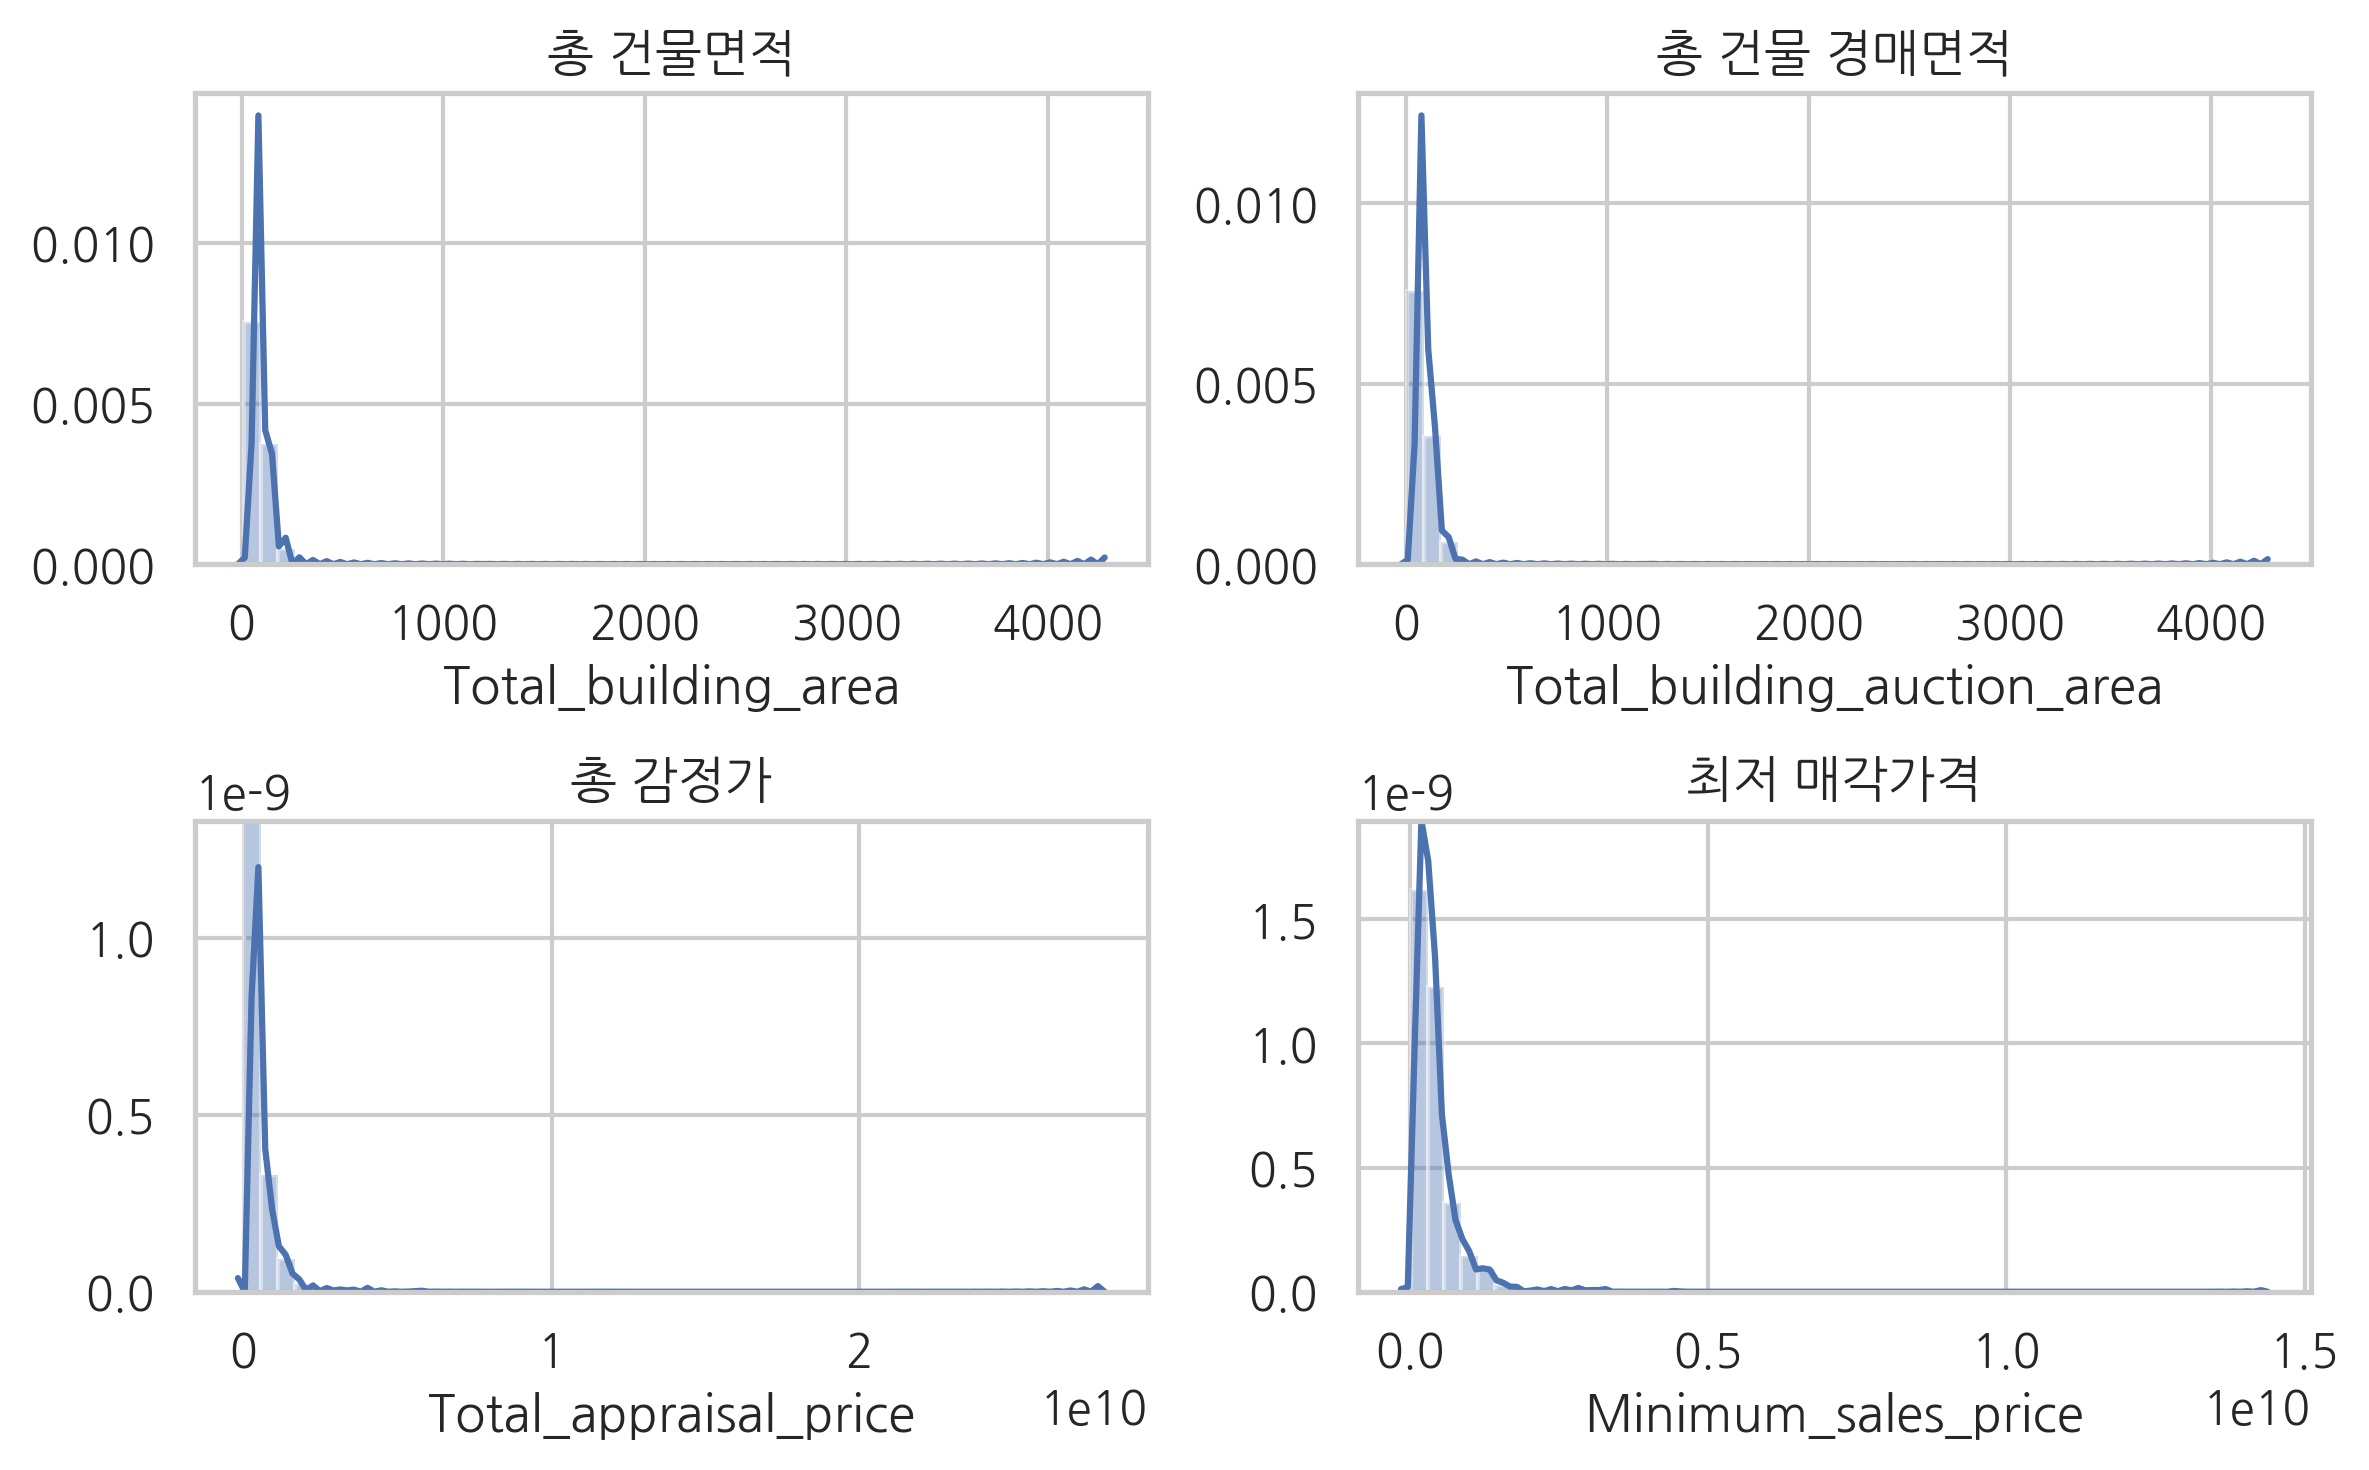

In [70]:
plt.subplot(221)
sns.distplot(train.Total_building_area)
plt.title('총 건물면적')
plt.subplot(222)
sns.distplot(train.Total_building_auction_area)
plt.title('총 건물 경매면적')
plt.subplot(223)
sns.distplot(train.Total_appraisal_price)
plt.title('총 감정가')
plt.subplot(224)
sns.distplot(train.Minimum_sales_price)
plt.title('최저 매각가격')

plt.tight_layout()
plt.show()

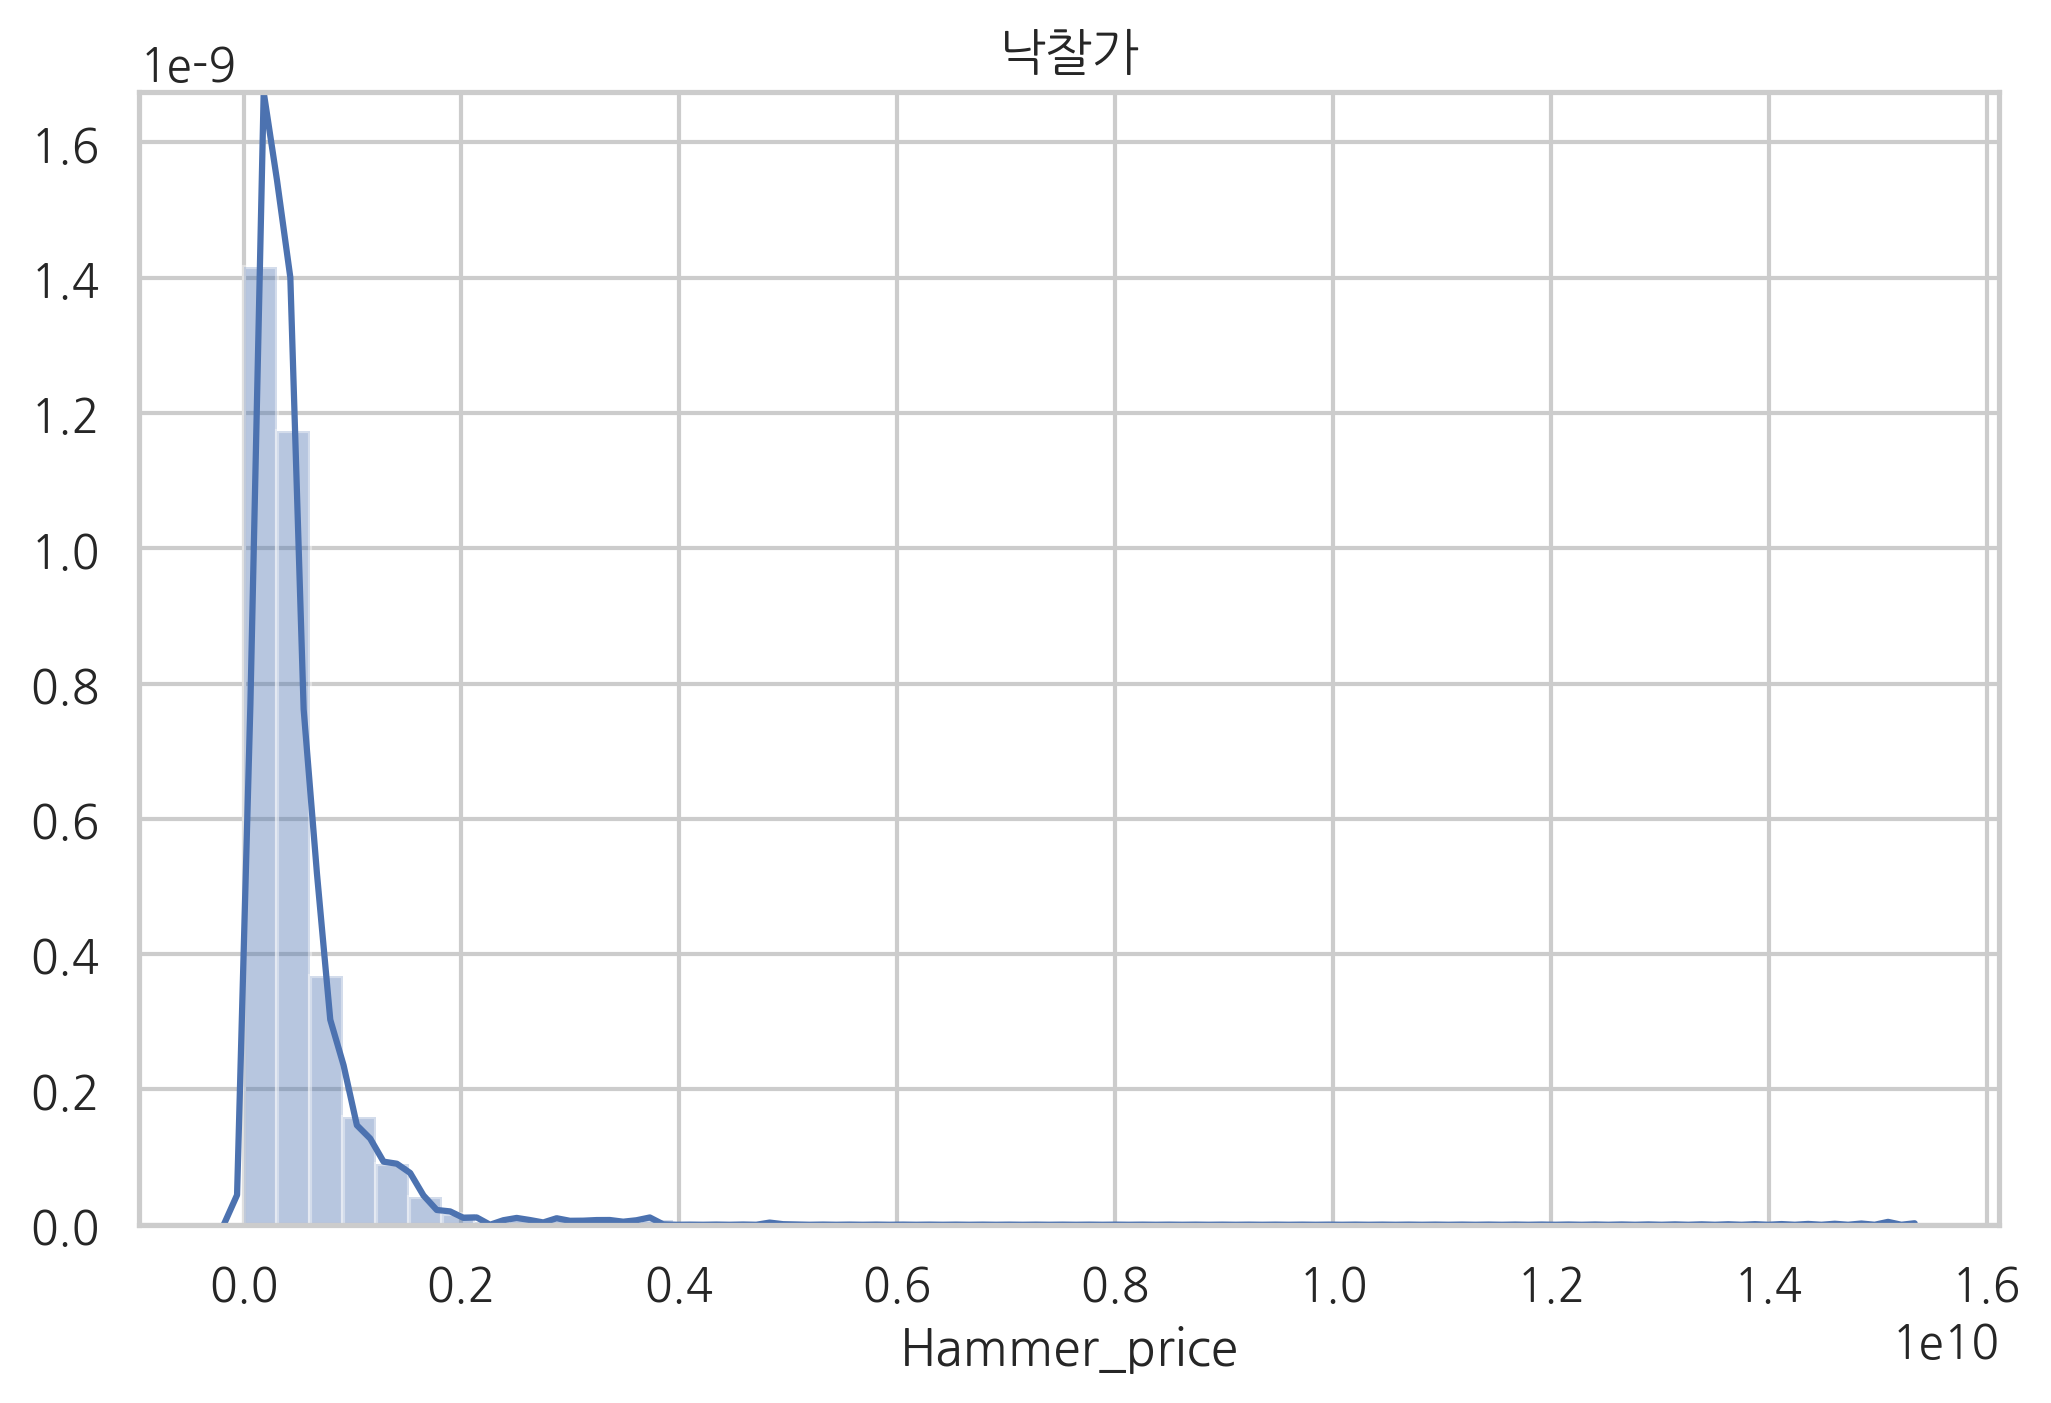

In [75]:
#Hammer_price
sns.distplot(train.Hammer_price)
plt.title("낙찰가")
plt.show()

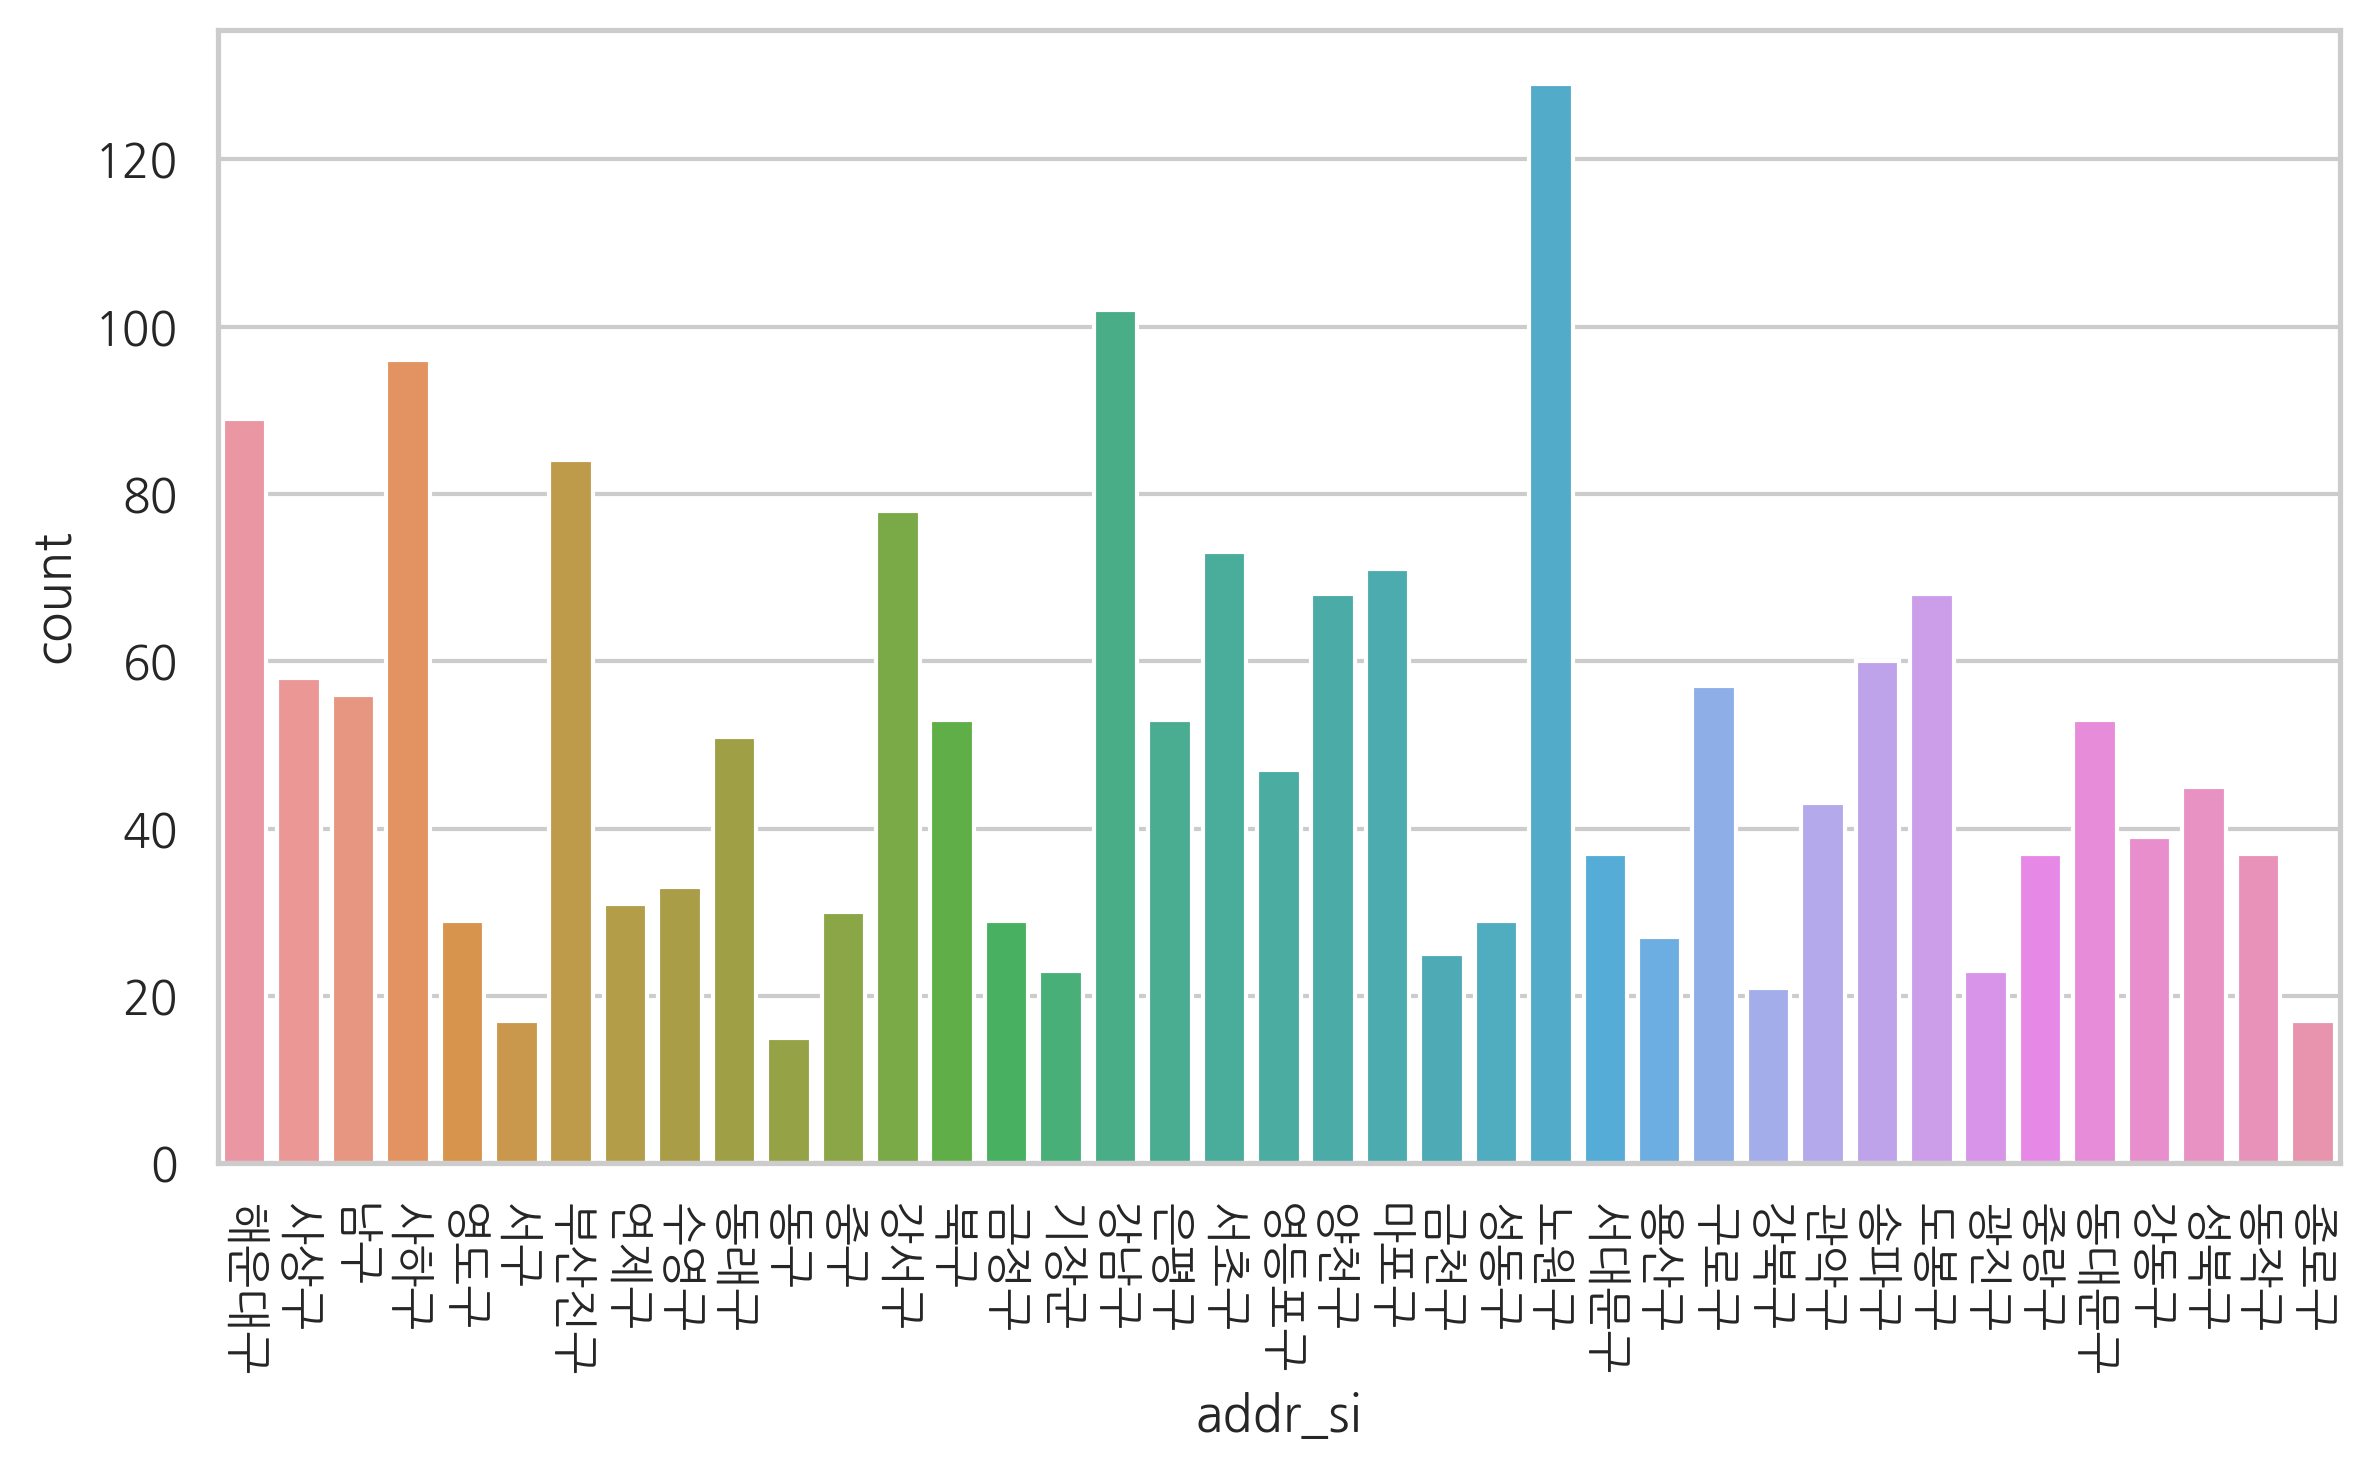

In [78]:
sns.countplot(x="addr_si", data=train)
plt.xticks(rotation = - 90 )
plt.tight_layout()
plt.show()

In [80]:
# folium 패키지
import folium

In [81]:
# 서울 부산 위도 경도 지정. 초기 zoom 10
seoul_map = folium.Map(location=[37.56667,126.97806], zoom_start=10)
busan_map = folium.Map(location=[35.18,129.08], zoom_start=10)